In [13]:
import pandas as pd
import numpy as np
import gc

In [14]:
pq_path = "../data/sae_arrets_full.parquet"

needed = [
    "IdCourse","RangArretAsc","DateCourse",
    "CodeLong","C_Ligne","C_SensAppl",
    "DistanceInterArret","TempsInterArretRealise","EcartDepart","NbMontees","NbDescentes",
    "DTDepartTheo",
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp",
    "C_TypeAppl",
]

df = pd.read_parquet(
    pq_path,
    columns=needed,
    engine="pyarrow",
    filters=[("C_TypeAppl", "=", 0)],
)

df = df.drop_duplicates(subset=["IdCourse","RangArretAsc"], keep="first")

In [15]:
seg_src = df
del df

# --- 0) Parse datetimes ---
time_cols = [
    "DTDepartTheo","DTArriveeTheo", 
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
]
for c in time_cols:
    if c in seg_src.columns:
        seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")

# --- 1) Basic casting / trimming ---
if "RangArretAsc" in seg_src.columns:
    seg_src["RangArretAsc"] = pd.to_numeric(seg_src["RangArretAsc"], errors="coerce")
if "C_Ligne" in seg_src.columns:
    seg_src["C_Ligne"] = pd.to_numeric(seg_src["C_Ligne"], errors="coerce")
seg_src["CodeLong"] = seg_src.get("CodeLong", "").astype(str).str.strip()
if "C_SensAppl" in seg_src.columns:
    seg_src["C_SensAppl"] = seg_src["C_SensAppl"].astype(str).str.strip()
for c in ["DistanceInterArret","TempsInterArretRealise","EcartDepart","NbMontees","NbDescentes"]:
    if c in seg_src.columns:
        seg_src[c] = pd.to_numeric(seg_src[c], errors="coerce")

# --- 2) Sort and build previous-stop columns (within a trip/course) ---
by = ["IdCourse","RangArretAsc"] if "IdCourse" in seg_src.columns else ["C_Ligne","DateCourse","RangArretAsc"]
seg_src = seg_src.sort_values(by, kind="mergesort")
grp = seg_src.groupby("IdCourse") if "IdCourse" in seg_src.columns else seg_src.groupby(["C_Ligne","DateCourse"])

seg_src["prev_CodeLong"] = grp["CodeLong"].shift(1)

# previous-window exit
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg_src.columns):
    seg_src["prev_DT_win_out"] = grp["DTSortieFenetreArretReal"].shift(1)
    seg_src["prev_DT_win_in"]  = grp["DTEntreeFenetreArretReal"].shift(1)
else:
    seg_src["prev_DT_win_out"] = np.nan
    seg_src["prev_DT_win_in"]  = np.nan

# fallbacks
seg_src["prev_DT_atp_in"]   = grp["DTEntreeArretAtp"].shift(1) if "DTEntreeArretAtp" in seg_src.columns else np.nan
seg_src["prev_DT_sched_dep"]= grp["DTDepartTheo"].shift(1)     if "DTDepartTheo" in seg_src.columns else np.nan

# upstream demand / punctuality
for c in ["NbMontees","NbDescentes","EcartDepart"]:
    if c in seg_src.columns:
        seg_src[f"prev_{c}"] = grp[c].shift(1)
        # ### --- CORRECTION FOR MOMENTUM --- ###
        # Create the 2-hop lag on the *same dataframe*
        if c == "EcartDepart":
             seg_src[f"prev_prev_{c}"] = grp[c].shift(2)

# --- 3) Keep only rows that have a previous stop (i.e., valid link) ---
seg = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]

# --- 4) Targets from single sources ---
# 4a) Link Target
seg["link_s"] = seg.get("TempsInterArretRealise")
seg.loc[(seg["link_s"]<=0) | (seg["link_s"]>1800), "link_s"] = np.nan

# 4b) Dwell Target (and 1-hop / 2-hop features)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()
    seg.loc[(seg["dwell_s"]<0) | (seg["dwell_s"]>900), "dwell_s"] = np.nan
    
    # We must re-group on the 'seg' dataframe to lag dwell
    grp_seg = seg.groupby("IdCourse") if "IdCourse" in seg.columns else seg.groupby(["C_Ligne","DateCourse"])
    seg["dwell_prev_s"] = grp_seg["dwell_s"].shift(1)
    seg["dwell_prev_prev_s"] = grp_seg["dwell_s"].shift(2)
else:
    seg["dwell_s"] = np.nan
    seg["dwell_prev_s"] = np.nan
    seg["dwell_prev_prev_s"] = np.nan
    
seg.loc[(seg["dwell_prev_s"]<0) | (seg["dwell_prev_s"]>900), "dwell_prev_s"] = np.nan
seg.loc[(seg["dwell_prev_prev_s"]<0) | (seg["dwell_prev_prev_s"]>900), "dwell_prev_prev_s"] = np.nan

# 4c) Punctuality signals (and 1-hop / 2-hop / momentum features)
seg["E_i"]    = pd.to_numeric(seg.get("EcartDepart"), errors="coerce")
seg["E_prev"] = pd.to_numeric(seg.get("prev_EcartDepart"), errors="coerce")

# ### --- CORRECTION FOR MOMENTUM --- ###
# Now we use the correctly-aligned 2-hop lag column
seg["E_prev_prev"] = pd.to_numeric(seg.get("prev_prev_EcartDepart"), errors="coerce")
seg["momentum_s"] = seg["E_prev"] - seg["E_prev_prev"]
seg["momentum_s"] = seg["momentum_s"].fillna(0) # Fill first 2 stops (NaNs) with 0 momentum

# --- 5) Upstream demand (1-hop) ---
seg["board_prev"]  = pd.to_numeric(seg.get("prev_NbMontees"),   errors="coerce")
seg["alight_prev"] = pd.to_numeric(seg.get("prev_NbDescentes"), errors="coerce")

# --- 6) Distance feature ---
seg["distance_m"] = pd.to_numeric(seg.get("DistanceInterArret"), errors="coerce")
seg.loc[seg["distance_m"]<0, "distance_m"] = np.nan

# --- 7) Time anchor for features ---
seg["link_start_time"] = seg["prev_DT_win_out"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_atp_in"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_sched_dep"]

# Drop rows without any anchor time or target
seg = seg[pd.notna(seg["link_start_time"]) & pd.notna(seg["link_s"])].copy()

# --- 8) Calendar & cyclical features ---
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["period168"] = seg["dow"]*24 + seg["hour"]

# --- 9) IDs for grouping/filters ---
seg["line"] = seg.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in seg.columns else "NA"
seg["dir"]  = seg.get("C_SensAppl", "NA").astype(str)

seg["link_start_time"] = pd.to_datetime(seg["link_start_time"], errors="coerce")


In [16]:


# ==============================================================================
# BLOCK 2: Baseline & Hero Feature Engineering (MEMORY-SAFE, SAME FEATURES)
# ==============================================================================

# 1) Define Train/Val/Test Split (Chronological)
TRAIN_END_DATE = pd.Timestamp("2025-11-21 23:59:59")
VAL_END_DATE   = pd.Timestamp("2025-11-24 23:59:59")
TEST_END_DATE  = pd.Timestamp("2025-11-30 23:59:59")

# Advanced Feature Engineering (Headway)

print("Sorting for headway calculation...")
seg.sort_values(by=["line", "dir", "from_stop", "link_start_time"], inplace=True)
seg["prev_bus_time"] = seg.groupby(["line", "dir", "from_stop"])["link_start_time"].shift(1)
seg["headway_s"] = (seg["link_start_time"] - seg["prev_bus_time"]).dt.total_seconds()
seg.loc[seg["headway_s"] > 3600, "headway_s"] = np.nan
seg.loc[seg["headway_s"] < 0, "headway_s"] = np.nan
seg.sort_values(by=["link_start_time"], inplace=True)
print(f"Headway generated. Valid headways: {seg['headway_s'].notna().mean():.1%}")

t = seg["link_start_time"]
mask_train_full = t <= TRAIN_END_DATE
mask_val_full   = (t > TRAIN_END_DATE) & (t <= VAL_END_DATE)
mask_test_full  = (t > VAL_END_DATE) & (t <= TEST_END_DATE)

print(f"Train samples: {mask_train_full.sum():,}")
print(f"Val samples:   {mask_val_full.sum():,}")
print(f"Test samples:  {mask_test_full.sum():,}")

# 2) Empirical Baseline (Median per Segment + Period168) on TRAIN only
#    Avoid seg.set_index([...]) on 11M rows (RAM spike). Use hashed key instead.
seg["SegmentKey"] = seg["SegmentKey"].astype("category")

pair_key = pd.util.hash_pandas_object(seg[["SegmentKey", "period168"]], index=False)
pair_key_train = pair_key[mask_train_full]

baseline_lookup = (
    seg.loc[mask_train_full]
      .groupby(pair_key_train, sort=False)["link_s"]
      .median()
)

segment_fallback = (
    seg.loc[mask_train_full]
      .groupby("SegmentKey", observed=True, sort=False)["link_s"]
      .median()
)

seg["bl_median"]   = pair_key.map(baseline_lookup).astype("float32")
seg["bl_fallback"] = seg["SegmentKey"].map(segment_fallback).astype("float32")
seg["bl_median"]   = seg["bl_median"].fillna(seg["bl_fallback"])

# 3) Target Residual
seg["target_residual"] = (seg["link_s"] - seg["bl_median"]).astype("float32")

del baseline_lookup, segment_fallback, pair_key_train
gc.collect()

# 4) Network State (Congestion Proxy) — train-only stats, applied to all rows
print("Generating Network Congestion Index...")
seg["speed_mps"] = (seg["distance_m"] / seg["link_s"]).astype("float32")

train_speed = seg.loc[mask_train_full].copy()

# create time buckets on both seg and train slice
seg["time_bucket"] = seg["link_start_time"].dt.floor("15min")

free_flow_map = seg.loc[mask_train_full].groupby("SegmentKey", observed=True)["speed_mps"].quantile(0.85)
seg["free_flow_speed"] = seg["SegmentKey"].map(free_flow_map).astype("float32")
seg["perf_ratio"] = (seg["speed_mps"] / seg["free_flow_speed"]).astype("float32")

network_state = seg.loc[mask_train_full].groupby("time_bucket", sort=False)["perf_ratio"].median()
network_state_shifted = network_state.shift(1)

seg["network_congestion_index"] = seg["time_bucket"].map(network_state_shifted).astype("float32").fillna(1.0)
# 5) Last Trip on Same Segment (Lag-1) — SAME as your original
print("Generating 'Last Trip' features...")
seg.sort_values(by=["SegmentKey", "link_start_time"], inplace=True)
grp_seg = seg.groupby("SegmentKey", observed=True, sort=False)

seg["last_trip_link_s"] = grp_seg["link_s"].shift(1)
seg["last_trip_end_time"] = grp_seg["link_start_time"].shift(1)
seg["gap_from_last_trip_s"] = (seg["link_start_time"] - seg["last_trip_end_time"]).dt.total_seconds()

seg["feat_last_trip_s"] = np.where(
    seg["gap_from_last_trip_s"] <= 1800,
    seg["last_trip_link_s"],
    seg["bl_median"]
).astype("float32")

seg["is_last_trip_fresh"] = (seg["gap_from_last_trip_s"] <= 1800).astype("int8")

# ==============================================================================
# BLOCK 2 Add-on: Weather + Daylight (NO MERGE; SAME FEATURES)
# ==============================================================================

print("Loading and adding external weather and daylight data...")

# --- Weather (hourly) ---
weather_df = pd.read_csv("../data/weather-info.csv")
weather_df["time"] = pd.to_datetime(weather_df["time"])
weather_df.rename(columns={
    "temperature_2m (°C)": "temperature_2m",
    "rain (mm)": "rain",
    "snowfall (cm)": "snowfall",
}, inplace=True)

seg["time_bucket_hour"] = seg["link_start_time"].dt.floor("h")

w = weather_df.set_index("time")[["temperature_2m", "rain", "snowfall"]]
seg["temperature_2m"] = seg["time_bucket_hour"].map(w["temperature_2m"]).astype("float32")
seg["rain"]           = seg["time_bucket_hour"].map(w["rain"]).fillna(0).astype("float32")
seg["snowfall"]       = seg["time_bucket_hour"].map(w["snowfall"]).fillna(0).astype("float32")

# --- Daylight (daily) ---
daylight_df = pd.read_csv("../data/daylight-info.csv")
daylight_df["date_bucket"] = pd.to_datetime(daylight_df["time"]).dt.floor("D")
daylight_df["sunrise"] = pd.to_datetime(daylight_df["sunrise (iso8601)"])
daylight_df["sunset"]  = pd.to_datetime(daylight_df["sunset (iso8601)"])

seg["date_bucket"] = seg["link_start_time"].dt.floor("D")

sunrise_map = daylight_df.drop_duplicates("date_bucket").set_index("date_bucket")["sunrise"]
sunset_map  = daylight_df.drop_duplicates("date_bucket").set_index("date_bucket")["sunset"]

seg["sunrise"] = seg["date_bucket"].map(sunrise_map)
seg["sunset"]  = seg["date_bucket"].map(sunset_map)

# fill + feature (same logic)
seg["temperature_2m"] = seg["temperature_2m"].ffill()
seg["sunrise"] = seg["sunrise"].ffill().bfill()
seg["sunset"]  = seg["sunset"].bfill().ffill()

seg["is_daylight"] = (
    (seg["link_start_time"] >= seg["sunrise"]) &
    (seg["link_start_time"] <= seg["sunset"])
).astype("int8")

# cleanup temps (same as your original intent)
seg.drop(columns=["time_bucket_hour", "date_bucket", "sunrise", "sunset"], inplace=True, errors="ignore")


print("Generating rolling local congestion features (15-min buckets)...")

# 0) Time bucket (re-use your existing 15min bucket if present)
if "time_bucket" not in seg.columns:
    seg["time_bucket"] = seg["link_start_time"].dt.floor("15min")

# 1) Build a small bucket-level table on TRAIN+VAL+TEST horizon (optional trim)
#    If you want: limit to <= TEST_END_DATE to save memory/time
seg_roll_src = seg.loc[seg["link_start_time"] <= TEST_END_DATE,
                       ["SegmentKey", "from_stop", "line", "time_bucket", "link_s"]].copy()

# ---------- SegmentKey-level rolling ----------
seg_tb = (
    seg_roll_src.groupby(["SegmentKey", "time_bucket"], observed=True, as_index=False)
               .agg(tb_med=("link_s", "median"),
                    tb_mean=("link_s", "mean"),
                    tb_cnt=("link_s", "size"))
               .sort_values(["SegmentKey", "time_bucket"])
)

def _roll_group(g):
    # leak-safe: only past buckets
    med = g["tb_med"].shift(1)
    mean = g["tb_mean"].shift(1)
    cnt = g["tb_cnt"].shift(1)

    g["seg_roll_med_1h"]  = med.rolling(4, min_periods=1).median()
    g["seg_roll_mean_1h"] = mean.rolling(4, min_periods=1).mean()
    g["seg_roll_std_1h"]  = mean.rolling(4, min_periods=2).std()
    g["seg_roll_cnt_1h"]  = cnt.rolling(4, min_periods=1).sum()
    return g

seg_tb = seg_tb.groupby("SegmentKey", observed=True, sort=False, group_keys=False).apply(_roll_group)
seg_tb = seg_tb[["SegmentKey", "time_bucket", "seg_roll_med_1h", "seg_roll_mean_1h", "seg_roll_std_1h", "seg_roll_cnt_1h"]]

# merge back (map-like merge, small table)
seg = seg.merge(seg_tb, on=["SegmentKey", "time_bucket"], how="left")


# ---------- from_stop-level rolling ----------
from_tb = (
    seg_roll_src.groupby(["from_stop", "time_bucket"], observed=True, as_index=False)
               .agg(tb_med=("link_s", "median"),
                    tb_mean=("link_s", "mean"),
                    tb_cnt=("link_s", "size"))
               .sort_values(["from_stop", "time_bucket"])
)

def _roll_group_from(g):
    med = g["tb_med"].shift(1)
    mean = g["tb_mean"].shift(1)
    cnt = g["tb_cnt"].shift(1)

    g["from_roll_med_1h"]  = med.rolling(4, min_periods=1).median()
    g["from_roll_mean_1h"] = mean.rolling(4, min_periods=1).mean()
    g["from_roll_std_1h"]  = mean.rolling(4, min_periods=2).std()
    g["from_roll_cnt_1h"]  = cnt.rolling(4, min_periods=1).sum()
    return g

from_tb = from_tb.groupby("from_stop", observed=True, sort=False, group_keys=False).apply(_roll_group_from)
from_tb = from_tb[["from_stop", "time_bucket", "from_roll_med_1h", "from_roll_mean_1h", "from_roll_std_1h", "from_roll_cnt_1h"]]

seg = seg.merge(from_tb, on=["from_stop", "time_bucket"], how="left")


# ---------- line-level rolling ----------
line_tb = (
    seg_roll_src.groupby(["line", "time_bucket"], observed=True, as_index=False)
               .agg(tb_med=("link_s", "median"),
                    tb_mean=("link_s", "mean"),
                    tb_cnt=("link_s", "size"))
               .sort_values(["line", "time_bucket"])
)

def _roll_group_line(g):
    med = g["tb_med"].shift(1)
    mean = g["tb_mean"].shift(1)
    cnt = g["tb_cnt"].shift(1)

    g["line_roll_med_1h"]  = med.rolling(4, min_periods=1).median()
    g["line_roll_mean_1h"] = mean.rolling(4, min_periods=1).mean()
    g["line_roll_std_1h"]  = mean.rolling(4, min_periods=2).std()
    g["line_roll_cnt_1h"]  = cnt.rolling(4, min_periods=1).sum()
    return g

line_tb = line_tb.groupby("line", observed=True, sort=False, group_keys=False).apply(_roll_group_line)
line_tb = line_tb[["line", "time_bucket", "line_roll_med_1h", "line_roll_mean_1h", "line_roll_std_1h", "line_roll_cnt_1h"]]

seg = seg.merge(line_tb, on=["line", "time_bucket"], how="left")


# 2) Types + fills
roll_cols = [
    "seg_roll_med_1h","seg_roll_mean_1h","seg_roll_std_1h","seg_roll_cnt_1h",
    "from_roll_med_1h","from_roll_mean_1h","from_roll_std_1h","from_roll_cnt_1h",
    "line_roll_med_1h","line_roll_mean_1h","line_roll_std_1h","line_roll_cnt_1h",
]
for c in roll_cols:
    seg[c] = seg[c].astype("float32")

# Optional: ratios to baseline (often strong)
seg["seg_roll_med_ratio_1h"]  = (seg["seg_roll_med_1h"]  / seg["bl_median"]).astype("float32")
seg["from_roll_med_ratio_1h"] = (seg["from_roll_med_1h"] / seg["bl_median"]).astype("float32")
seg["line_roll_med_ratio_1h"] = (seg["line_roll_med_1h"] / seg["bl_median"]).astype("float32")

print("Rolling features done.")

print("Weather and Daylight features added.")

Sorting for headway calculation...
Headway generated. Valid headways: 94.1%
Train samples: 3,863,565
Val samples:   371,359
Test samples:  774,572
Generating Network Congestion Index...
Generating 'Last Trip' features...
Loading and adding external weather and daylight data...
Generating rolling local congestion features (15-min buckets)...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_11733/2868698957.py:175: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_tb = seg_tb.groupby("SegmentKey", observed=True, sort=False, group_keys=False).apply(_roll_group)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_11733/2868698957.py:202: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  from_tb = from_tb.groupby("from_stop", observed=True, sort

Rolling features done.
Weather and Daylight features added.


In [17]:
seg["SegmentKey"] = seg["SegmentKey"].astype("category")
seg["from_stop"]  = seg["from_stop"].astype("category")
seg["to_stop"]    = seg["to_stop"].astype("category")

In [18]:
# After finishing baseline/feature engineering on seg (bl_median, target_residual, weather/daylight, etc.)

# 0) Create df_ml from seg rows that have a target_residual
valid_rows = seg["target_residual"].notna()
seg.drop_duplicates(subset=["IdCourse","RangArretAsc"], keep="first", inplace=True)
df_ml = seg.loc[valid_rows].copy()

# ============================================================
# NEW BLOCK A: Spatial features from stops_df.csv (Stage 1)
# Insert right after: df_ml = seg.loc[valid_rows].copy()
# ============================================================

stops = pd.read_csv("../data/stops_df.csv")
stops.columns = stops.columns.str.strip()

# Keep only what we need + clean MNLP
stops["MNLP"] = stops["MNLP"].astype(str).str.strip()
stops["X"] = pd.to_numeric(stops["X"], errors="coerce")
stops["Y"] = pd.to_numeric(stops["Y"], errors="coerce")
stops = stops.dropna(subset=["MNLP","X","Y"]).drop_duplicates("MNLP", keep="first")

stop_xy = stops.set_index("MNLP")[["X","Y"]]

# Ensure from_stop / to_stop exist in df_ml
if "from_stop" not in df_ml.columns or "to_stop" not in df_ml.columns:
    ft = df_ml["SegmentKey"].astype(str).str.split("→", n=1, expand=True)
    df_ml["from_stop"] = ft[0].astype(str).str.strip()
    df_ml["to_stop"]   = ft[1].astype(str).str.strip()

# Map coordinates (fast, no merge)
df_ml["from_x"] = df_ml["from_stop"].map(stop_xy["X"])
df_ml["from_y"] = df_ml["from_stop"].map(stop_xy["Y"])
df_ml["to_x"]   = df_ml["to_stop"].map(stop_xy["X"])
df_ml["to_y"]   = df_ml["to_stop"].map(stop_xy["Y"])

# Segment length in projected coords (meters if Geneva grid)
dx = df_ml["to_x"] - df_ml["from_x"]
dy = df_ml["to_y"] - df_ml["from_y"]
df_ml["seg_length_xy_m"] = np.sqrt(dx*dx + dy*dy).astype("float32")

# Optional: mid-point + grid cell features
df_ml["mid_x"] = ((df_ml["from_x"] + df_ml["to_x"]) / 2.0)
df_ml["mid_y"] = ((df_ml["from_y"] + df_ml["to_y"]) / 2.0)

CELL_SIZE_M = 250  # try 250 or 500
x0 = float(stops["X"].min())
y0 = float(stops["Y"].min())
df_ml["cell_x"] = np.floor((df_ml["mid_x"] - x0) / CELL_SIZE_M).astype("Int32")
df_ml["cell_y"] = np.floor((df_ml["mid_y"] - y0) / CELL_SIZE_M).astype("Int32")
df_ml["cell_id"] = (df_ml["cell_x"].astype(str) + "_" + df_ml["cell_y"].astype(str)).astype("category")

# (Optional) drop raw coords if you don’t need them later to save memory
# df_ml.drop(columns=["from_x","from_y","to_x","to_y","mid_x","mid_y","cell_x","cell_y"], inplace=True)


# ============================================================
# NEW BLOCK B: Intersection / signal environment features (Stage 3)
# Replace your carrefour_map creation + merge with this
# ============================================================

def norm_line(x): 
    x = str(x).strip() 
    try: return str(int(float(x))) 
    except: return x

carrefour_df = pd.read_csv("../data/all_carrefour_merged.csv")
carrefour_df.columns = carrefour_df.columns.str.strip()

carrefour_df["carrefour_id"]   = pd.to_numeric(carrefour_df["numero_carrefour"], errors="coerce")
carrefour_df["stop_left"]      = carrefour_df["stop_left"].astype(str).str.strip()
carrefour_df["stop_right"]     = carrefour_df["stop_right"].astype(str).str.strip()
carrefour_df["groupe_de_feux"] = carrefour_df["groupe_de_feux"].astype(str).str.strip()
carrefour_df["line"]           = carrefour_df["ligne"].apply(norm_line)
carrefour_df["SegmentKey"]     = carrefour_df["stop_left"] + "→" + carrefour_df["stop_right"]
carrefour_df["dist_stop_to_carrefour_m"] = pd.to_numeric(carrefour_df["feux_mesures"], errors="coerce")

# Segment-level aggregation (keeps density / counts!)
carrefour_feat = (
    carrefour_df.groupby(["SegmentKey","line"], as_index=False)
    .agg(
        n_carrefours=("carrefour_id", lambda s: s.notna().sum()),
        n_unique_carrefours=("carrefour_id", "nunique"),
        n_signal_groups=("groupe_de_feux", lambda s: (s.notna() & (s.astype(str).str.len() > 0)).sum()),
        dist_stop_to_carrefour_m_min=("dist_stop_to_carrefour_m", "min"),
        dist_stop_to_carrefour_m_mean=("dist_stop_to_carrefour_m", "mean"),
    )
)

carrefour_feat["has_signal_segment"] = (carrefour_feat["n_signal_groups"] > 0).astype("int8")
carrefour_feat["has_any_carrefour"]  = (carrefour_feat["n_carrefours"] > 0).astype("int8")

df_ml["line"] = df_ml["line"].apply(norm_line)

# Drop old columns if you had them
for col in ["carrefour_id","groupe_de_feux","dist_stop_to_carrefour_m"]:
    if col in df_ml.columns:
        df_ml.drop(columns=col, inplace=True)

df_ml = df_ml.merge(carrefour_feat, on=["SegmentKey","line"], how="left")

# Fill missing as 0 for counts
for c in ["n_carrefours","n_unique_carrefours","n_signal_groups","has_signal_segment","has_any_carrefour"]:
    df_ml[c] = df_ml[c].fillna(0).astype("int32" if "n_" in c else "int8")

In [19]:
print(f"seg rows: {len(seg):,}")
print(f"ML Ready Dataset: {len(df_ml):,} rows")

seg rows: 5,010,310
ML Ready Dataset: 5,009,560 rows


In [20]:
from pathlib import Path
import numpy as np
import pandas as pd

SIG_ROOT = Path("../data/signal_parquet_db")

signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]

# 1) Build (SegmentKey,line) -> list of (carrefour_id,groupe_de_feux)
pairs = carrefour_df.loc[
    carrefour_df["carrefour_id"].notna() & carrefour_df["groupe_de_feux"].notna(),
    ["SegmentKey","line","carrefour_id","groupe_de_feux"]
].copy()

pairs["carrefour_id"] = pairs["carrefour_id"].astype(int)
pairs["groupe_de_feux"] = pairs["groupe_de_feux"].astype(str).str.strip()
pairs = pairs.drop_duplicates(subset=["SegmentKey","line","carrefour_id","groupe_de_feux"])

print("Unique (SegmentKey,line) with any signal mapping:", pairs[["SegmentKey","line"]].drop_duplicates().shape[0])

# 2) Helper: compute static features for one (carrefour_id, gf)
def compute_signal_stats(sig: pd.DataFrame, gf: str):
    if gf not in sig.columns:
        return None

    s = pd.to_numeric(sig[gf], errors="coerce").ffill().dropna()
    if s.empty:
        return None

    s_int = s.astype("int8")  # RED=1, GREEN=0
    d = s_int.diff()
    green_starts = s_int.index[d == -1].values.astype("datetime64[ns]")

    if len(green_starts) >= 2:
        cyc = np.diff(green_starts).astype("timedelta64[s]").astype("float64")
        cyc = cyc[cyc > 0]
    else:
        cyc = np.array([], dtype="float64")

    if len(cyc) >= 3:
        cycle_length_s = float(np.nanmedian(cyc))
        cycle_stability_cv = float(np.nanstd(cyc) / max(np.nanmean(cyc), 1e-6))
        signal_variability_index = float(
            (np.nanpercentile(cyc, 75) - np.nanpercentile(cyc, 25)) / max(np.nanmedian(cyc), 1e-6)
        )
    elif len(cyc) > 0:
        cycle_length_s = float(np.nanmedian(cyc))
        cycle_stability_cv = np.nan
        signal_variability_index = np.nan
    else:
        cycle_length_s = np.nan
        cycle_stability_cv = np.nan
        signal_variability_index = np.nan

    change_mask = s_int.diff().fillna(0).ne(0)
    change_times = s_int.index[change_mask].to_list()
    if len(change_times) == 0:
        priority_like_trigger_rate = np.nan
    else:
        bounds = [s_int.index[0]] + change_times + [s_int.index[-1]]
        vals = [int(s_int.iloc[0])] + [int(s_int.loc[t]) for t in change_times]

        durations, states = [], []
        for i in range(len(vals)):
            start = bounds[i]
            end = bounds[i + 1]
            dur_s = (end - start) / np.timedelta64(1, "s")
            if dur_s > 0:
                durations.append(float(dur_s))
                states.append(vals[i])

        durations = np.array(durations, dtype="float64")
        states = np.array(states, dtype="int8")

        green_d = durations[states == 0]
        red_d = durations[states == 1]

        if len(green_d) >= 10 or len(red_d) >= 10:
            g_thr = np.nanpercentile(green_d, 90) if len(green_d) else np.nan
            r_thr = np.nanpercentile(red_d, 10) if len(red_d) else np.nan
            flags = []
            if len(green_d):
                flags.append((green_d > g_thr).mean())
            if len(red_d):
                flags.append((red_d < r_thr).mean())
            priority_like_trigger_rate = float(np.nanmean(flags)) if flags else np.nan
        else:
            priority_like_trigger_rate = np.nan

    return cycle_length_s, cycle_stability_cv, priority_like_trigger_rate, signal_variability_index

# 3) Compute per (SegmentKey,line) by aggregating over all mapped (carrefour_id,gf)
rows_out = []
for (segkey, line), sub in pairs.groupby(["SegmentKey","line"], sort=False):
    stats_list = []

    for cid, gf in sub[["carrefour_id","groupe_de_feux"]].itertuples(index=False, name=None):
        path = SIG_ROOT / f"signal_{int(cid)}.parquet"
        if not path.exists():
            continue

        sig = pd.read_parquet(path)
        sig.index = pd.to_datetime(sig.index, errors="coerce")
        sig = sig[~sig.index.isna()].sort_index()
        sig = sig[~sig.index.duplicated(keep="last")]

        out = compute_signal_stats(sig, gf)
        if out is not None:
            stats_list.append(out)

    if len(stats_list) == 0:
        continue

    arr = np.array(stats_list, dtype="float64")  # shape (k,4)
    rows_out.append({
        "SegmentKey": segkey,
        "line": line,
        "cycle_length_s": float(np.nanmedian(arr[:,0])),
        "cycle_stability_cv": float(np.nanmedian(arr[:,1])),
        "priority_like_trigger_rate": float(np.nanmedian(arr[:,2])),
        "signal_variability_index": float(np.nanmedian(arr[:,3])),
    })

sig_feat = pd.DataFrame(rows_out)
print("Computed signal features for segments:", len(sig_feat))

# 4) Merge into df_ml
for c in signal_static_feat_cols:
    if c not in df_ml.columns:
        df_ml[c] = np.nan

df_ml = df_ml.merge(sig_feat, on=["SegmentKey","line"], how="left", suffixes=("", "_new"))

for c in signal_static_feat_cols:
    if f"{c}_new" in df_ml.columns:
        df_ml[c] = df_ml[c].fillna(df_ml[f"{c}_new"])
        df_ml.drop(columns=[f"{c}_new"], inplace=True)

print("Static signal feature non-null share:")
print(df_ml[signal_static_feat_cols].notna().mean())

Unique (SegmentKey,line) with any signal mapping: 1346
Computed signal features for segments: 88
Static signal feature non-null share:
cycle_length_s                0.034118
cycle_stability_cv            0.034118
priority_like_trigger_rate    0.034118
signal_variability_index      0.034118
dtype: float64


In [21]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

EPS = 1e-6
NUM_THREADS = -1

cat_cols = ["SegmentKey", "line", "dir", "cell_id"]
#cat_cols = ["line", "dir", "cell_id"]
#cat_cols = ["line", "dir"]


for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")


carrefour_feats = [
    "n_carrefours",
    "n_unique_carrefours",
    "n_signal_groups",
    "has_signal_segment",
    "has_any_carrefour",
    "dist_stop_to_carrefour_m_min",
    "dist_stop_to_carrefour_m_mean",
]

# Your existing sets
features_reduced = [
    "distance_m",
    "period168", "dow", "is_weekend",
    "E_prev", "dwell_prev_s",
    "board_prev", "alight_prev",
    "E_prev_prev", "dwell_prev_prev_s", "momentum_s",
] 

features_full = features_reduced + [
    "headway_s",
    "network_congestion_index",
    "feat_last_trip_s",
    "is_last_trip_fresh",
    "temperature_2m",
    "rain",
    "snowfall",
    "is_daylight",
]

signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]

roll_feats = [
    "seg_roll_med_1h","seg_roll_mean_1h","seg_roll_std_1h","seg_roll_cnt_1h",
    "from_roll_med_1h","from_roll_mean_1h","from_roll_std_1h","from_roll_cnt_1h",
    "line_roll_med_1h","line_roll_mean_1h","line_roll_std_1h","line_roll_cnt_1h",
    "seg_roll_med_ratio_1h","from_roll_med_ratio_1h","line_roll_med_ratio_1h",
]

# Stage definitions
stage1_feats = features_reduced
stage2_feats = features_full + roll_feats
stage3_feats = features_full + carrefour_feats + signal_static_feat_cols + roll_feats

# ==============================================================================
# 2) Splits
# ==============================================================================
TRAIN_END_DATE = pd.Timestamp("2025-11-21 23:59:59")
VAL_END_DATE   = pd.Timestamp("2025-11-23 23:59:59")
TEST_END_DATE  = pd.Timestamp("2025-11-30 23:59:59")

df_ml = df_ml.reset_index(drop=True)
t = df_ml["link_start_time"]

mask_train = t <= TRAIN_END_DATE
mask_val   = (t > TRAIN_END_DATE) & (t <= VAL_END_DATE)
mask_test  = (t > VAL_END_DATE) & (t <= TEST_END_DATE)

mask_sig = df_ml[signal_static_feat_cols].notna().any(axis=1)
mask_sig_val  = mask_val  & mask_sig
mask_sig_test = mask_test & mask_sig

# ==============================================================================
# 3) Params
# ==============================================================================
params = {
    "objective": "regression_l1",
    "metric": "mae",                 # training metric (residual MAE)
    "boosting_type": "gbdt",
    "num_leaves": 800,
    "min_data_in_leaf": 200,
    "max_depth": -1,
    "learning_rate": 0.1,
    "feature_fraction": 0.8,
    "verbose": -1,
    "num_threads": NUM_THREADS,
    "seed": 42,
}

# ==============================================================================
# 4) Helpers
# ==============================================================================
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

EPS = 1e-6
NUM_THREADS = -1

id_cols = ["link_start_time", "SegmentKey", "line", "dir"]

def compute_mae_mape(y_true_total, y_pred_total):
    mae = mean_absolute_error(y_true_total, y_pred_total)
    denom = np.maximum(np.abs(y_true_total), EPS)
    mape = np.mean(np.abs((y_true_total - y_pred_total) / denom)) * 100.0
    return float(mae), float(mape)

def train_and_eval(feats, name="model", store_test_preds=False, store_sig_test_preds=False):
    # Build X once
    X = df_ml.loc[:, feats + cat_cols]
    y = df_ml["target_residual"]

    dtrain = lgb.Dataset(
        X.loc[mask_train],
        label=y.loc[mask_train],
        categorical_feature=cat_cols,
        free_raw_data=False,
    )
    dval = lgb.Dataset(
        X.loc[mask_val],
        label=y.loc[mask_val],
        categorical_feature=cat_cols,
        reference=dtrain,
        free_raw_data=False,
    )

    print(f"\nTraining: {name} | features={len(feats)} (+{len(cat_cols)} cat)")
    bst = lgb.train(
        params,
        dtrain,
        num_boost_round=3000,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)],
    )

    def eval_mask(mask, tag):
        Xs = X.loc[mask]
        preds_resid = bst.predict(Xs, num_iteration=bst.best_iteration, num_threads=NUM_THREADS)
        y_pred_total = df_ml.loc[mask, "bl_median"].to_numpy() + preds_resid
        y_true_total = df_ml.loc[mask, "link_s"].to_numpy()
        mae, mape = compute_mae_mape(y_true_total, y_pred_total)
        return mae, mape, preds_resid, y_pred_total

    rows = []

    # --- VAL metrics (no storing) ---
    mae, mape, _, _ = eval_mask(mask_val, "VAL")
    rows.append({"Model": name, "Split": "VAL", "MAE_sec": mae, "MAPE_pct": mape, "n": int(mask_val.sum())})

    # --- TEST metrics (optionally store predictions) ---
    mae, mape, preds_resid_test, yhat_test = eval_mask(mask_test, "TEST")
    rows.append({"Model": name, "Split": "TEST", "MAE_sec": mae, "MAPE_pct": mape, "n": int(mask_test.sum())})

    pred_test_df = None
    if store_test_preds:
        base = df_ml.loc[mask_test, id_cols + ["link_s", "bl_median"]].copy()
        base.rename(columns={"link_s": "y_true", "bl_median": "y_base"}, inplace=True)
        base["pred_residual"] = preds_resid_test
        base["y_pred"] = yhat_test
        base["residual"] = base["y_true"] - base["y_pred"]
        base["abs_err"] = base["residual"].abs()
        base["pct_err"] = base["abs_err"] / np.maximum(np.abs(base["y_true"]), EPS)
        base["model"] = name
        pred_test_df = base

    # --- optional: signal-covered subsets ---
    if "mask_sig_val" in globals() and mask_sig_val.any():
        mae, mape, _, _ = eval_mask(mask_sig_val, "VAL_sig")
        rows.append({"Model": name, "Split": "VAL_sig", "MAE_sec": mae, "MAPE_pct": mape, "n": int(mask_sig_val.sum())})

    pred_sig_test_df = None
    if "mask_sig_test" in globals() and mask_sig_test.any():
        mae, mape, preds_resid_sig, yhat_sig = eval_mask(mask_sig_test, "TEST_sig")
        rows.append({"Model": name, "Split": "TEST_sig", "MAE_sec": mae, "MAPE_pct": mape, "n": int(mask_sig_test.sum())})

        if store_sig_test_preds:
            base = df_ml.loc[mask_sig_test, id_cols + ["link_s", "bl_median"]].copy()
            base.rename(columns={"link_s": "y_true", "bl_median": "y_base"}, inplace=True)
            base["pred_residual"] = preds_resid_sig
            base["y_pred"] = yhat_sig
            base["residual"] = base["y_true"] - base["y_pred"]
            base["abs_err"] = base["residual"].abs()
            base["pct_err"] = base["abs_err"] / np.maximum(np.abs(base["y_true"]), EPS)
            base["model"] = name
            pred_sig_test_df = base

    return bst, pd.DataFrame(rows), pred_test_df, pred_sig_test_df

In [100]:
bst_stage1, res1, pred_stage1_test, pred_stage1_test_sig = train_and_eval(
    stage1_feats,
    name="Stage1_Static",
    store_test_preds=True,
    store_sig_test_preds=True,   # optional
)

bst_stage2, res2, pred_stage2_test, pred_stage2_test_sig = train_and_eval(
    stage2_feats,
    name="Stage2_Network",
    store_test_preds=True,
    store_sig_test_preds=True,   # optional
)

bst_stage3, res3, pred_stage3_test, pred_stage3_test_sig = train_and_eval(
    stage3_feats,
    name="Stage3_Full",
    store_test_preds=True,
    store_sig_test_preds=True,   # optional
)

# pred_stage3_test now has per-row predictions for spatial/temporal analysis


Training: Stage1_Static | features=11 (+4 cat)
Training until validation scores don't improve for 100 rounds
[200]	train's l1: 13.2975	val's l1: 13.3388
[400]	train's l1: 13.036	val's l1: 13.2503
[600]	train's l1: 12.8898	val's l1: 13.2187
[800]	train's l1: 12.7844	val's l1: 13.1987
[1000]	train's l1: 12.7046	val's l1: 13.1883
[1200]	train's l1: 12.6133	val's l1: 13.178
[1400]	train's l1: 12.5642	val's l1: 13.1724
[1600]	train's l1: 12.5238	val's l1: 13.1659
[1800]	train's l1: 12.486	val's l1: 13.1624
[2000]	train's l1: 12.4513	val's l1: 13.1602
[2200]	train's l1: 12.4183	val's l1: 13.1556
Early stopping, best iteration is:
[2243]	train's l1: 12.4089	val's l1: 13.1552

Training: Stage2_Network | features=34 (+4 cat)
Training until validation scores don't improve for 100 rounds
[200]	train's l1: 12.7697	val's l1: 12.9897
[400]	train's l1: 12.3527	val's l1: 12.8533
[600]	train's l1: 12.1049	val's l1: 12.808
[800]	train's l1: 11.939	val's l1: 12.7875
[1000]	train's l1: 11.8031	val's l1: 

In [24]:
import lightgbm as lgb
from pathlib import Path
import pandas as pd

DATA_DIR = Path("../app_data")
MODEL_DIR = Path("../models")

# Reload boosters
bst_stage1 = lgb.Booster(model_file=MODEL_DIR / "bst_stage1.txt")
bst_stage2 = lgb.Booster(model_file=MODEL_DIR / "bst_stage2.txt")
bst_stage3 = lgb.Booster(model_file=MODEL_DIR / "bst_stage3.txt")

# Ensure categoricals match training
cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    if c in df_ml.columns:
        df_ml[c] = df_ml[c].astype("category")

# Load stored predictions (test set) for downstream analysis
pred_files = sorted(DATA_DIR.glob("pred_stage*_test.parquet"))
pred_dfs = []
for f in pred_files:
    d = pd.read_parquet(f)
    # add model name if missing
    if "model" not in d.columns:
        d["model"] = f.stem.replace("pred_", "").replace("_test", "")
    pred_dfs.append(d)

if pred_dfs:
    preds_test = pd.concat(pred_dfs, ignore_index=True)
else:
    preds_test = pd.DataFrame()
    print("No pred_stage*_test.parquet found in app_data")

print("Models loaded:", [p.name for p in MODEL_DIR.glob("bst_stage*.txt")])
print("Pred rows loaded:", len(preds_test))

Models loaded: ['bst_stage2.txt', 'bst_stage3.txt', 'bst_stage1.txt']
Pred rows loaded: 2759598


In [26]:
import pandas as pd

def feature_importance_table(bst, topn=40):
    feat_names = bst.feature_name()
    imp_gain = bst.feature_importance(importance_type="gain")
    imp_split = bst.feature_importance(importance_type="split")

    fi = pd.DataFrame({
        "feature": feat_names,
        "gain": imp_gain,
        "split": imp_split,
    }).sort_values("gain", ascending=False)

    # Optional: normalized gain share
    fi["gain_share"] = fi["gain"] / fi["gain"].sum()
    return fi.head(topn), fi

top40, fi_all = feature_importance_table(bst_stage3, topn=40)
print(top40)

                          feature          gain   split  gain_share
45                     SegmentKey  8.640777e+06  423209    0.345292
48                        cell_id  2.282717e+06  133517    0.091219
46                           line  1.446492e+06  141539    0.057803
11                      headway_s  8.524723e+05  117421    0.034065
5                    dwell_prev_s  7.810901e+05   71266    0.031213
40               line_roll_std_1h  7.069082e+05  104212    0.028249
4                          E_prev  6.702393e+05   90674    0.026783
8                     E_prev_prev  6.676302e+05   93821    0.026679
12       network_congestion_index  6.513910e+05   87232    0.026030
10                     momentum_s  6.114903e+05   75187    0.024436
15                 temperature_2m  5.982692e+05   87557    0.023907
42          seg_roll_med_ratio_1h  5.830635e+05   80184    0.023300
32                seg_roll_std_1h  5.642981e+05   82526    0.022550
9               dwell_prev_prev_s  5.556889e+05 

In [28]:
def baseline_rows(tag, mask):
    y_true = df_ml.loc[mask, "link_s"].to_numpy()
    y_base = df_ml.loc[mask, "bl_median"].to_numpy()
    mae, mape = compute_mae_mape(y_true, y_base)
    return {"Model": "Baseline(bl_median)", "Split": tag, "MAE_sec": mae, "MAPE_pct": mape, "n": int(mask.sum())}

base_rows = []
base_rows.append(baseline_rows("VAL",  mask_val))
base_rows.append(baseline_rows("TEST", mask_test))

if "mask_sig_val" in globals() and mask_sig_val.any():
    base_rows.append(baseline_rows("VAL_sig", mask_sig_val))
if "mask_sig_test" in globals() and mask_sig_test.any():
    base_rows.append(baseline_rows("TEST_sig", mask_sig_test))

res_base = pd.DataFrame(base_rows)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Combine results (expects: res_base, res1, res2, res3 already exist)
results_all = pd.concat([res_base, res1, res2, res3], ignore_index=True)

# Which splits to show
splits_to_plot = [s for s in ["VAL", "TEST"] if s in results_all["Split"].unique()]
plot_df = results_all[results_all["Split"].isin(splits_to_plot)].copy()

# Consistent model order
model_order = ["Baseline(bl_median)", "Stage1_Static", "Stage2_Network", "Stage3_Full"]
plot_df["Model"] = pd.Categorical(plot_df["Model"], categories=model_order, ordered=True)
plot_df = plot_df.sort_values(["Split", "Model"])

def bar_by_split(metric_col, ylabel, title):
    # Pivot to (Split x Model)
    wide = plot_df.pivot_table(index="Split", columns="Model", values=metric_col, aggfunc="mean").reindex(splits_to_plot)
    n_wide = plot_df.pivot_table(index="Split", columns="Model", values="n", aggfunc="max").reindex(splits_to_plot)

    models = [m for m in model_order if m in wide.columns]
    wide = wide[models]
    n_wide = n_wide[models]

    x = np.arange(len(splits_to_plot))
    width = 0.8 / len(models)

    fig, ax = plt.subplots(figsize=(11, 5))
    for i, m in enumerate(models):
        vals = wide[m].to_numpy()
        ax.bar(x + (i - (len(models)-1)/2)*width, vals, width, label=m)

        # annotate values (optional)
        for xi, yi in zip(x + (i - (len(models)-1)/2)*width, vals):
            if np.isfinite(yi):
                ax.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{s}\n(n={int(plot_df[plot_df['Split']==s]['n'].max()):,})" for s in splits_to_plot])
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=10, top=wide.values.max() * 1.15)
    ax.set_title(title)
    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.legend()
    plt.tight_layout()
    plt.show()

bar_by_split("MAE_sec",  "MAE (sec)", "Baseline vs Stages — MAE (by split)")
bar_by_split("MAPE_pct", "MAPE (%)",  "Baseline vs Stages — MAPE (by split)")

NameError: name 'res1' is not defined

In [29]:
import numpy as np
import pandas as pd

EPS = 1e-6

# ---- inputs you already have ----
p1 = pred_stage1_test.copy()
p2 = pred_stage2_test.copy()
p3 = pred_stage3_test.copy()

# Ensure they share a common row index (your "key")
# If you didn't set an index before, do it now consistently:
# key_cols = ["link_start_time","SegmentKey","line","dir"]
# for p in (p1,p2,p3):
#     p["key"] = pd.util.hash_pandas_object(p[key_cols], index=False)
#     p.set_index("key", inplace=True)

# Make sure indices are unique
p1 = p1[~p1.index.duplicated(keep="first")]
p2 = p2[~p2.index.duplicated(keep="first")]
p3 = p3[~p3.index.duplicated(keep="first")]

common_idx = p1.index.intersection(p2.index).intersection(p3.index)
p1 = p1.loc[common_idx]
p2 = p2.loc[common_idx]
p3 = p3.loc[common_idx]

# Canonical y_true and baseline from one table (they should match across)
y_true = p3["y_true"].to_numpy()
y_base = p3["y_base"].to_numpy()

yhat_1 = p1["y_pred"].to_numpy()
yhat_2 = p2["y_pred"].to_numpy()
yhat_3 = p3["y_pred"].to_numpy()

# ---- segment-level CV on TEST rows ----
# CV = std / mean for link_s, computed per SegmentKey within this test set
seg_stats = (
    p3.groupby("SegmentKey")["y_true"]
      .agg(seg_mean="mean", seg_std="std", seg_n="size")
)
seg_stats["seg_cv"] = seg_stats["seg_std"] / np.maximum(seg_stats["seg_mean"].abs(), EPS)

# Map CV back to rows
seg_cv = p3["SegmentKey"].map(seg_stats["seg_cv"]).astype("float32")

# ---- quantile bands you asked for ----
qs = [0.1, 0.3, 0.5, 0.7, 0.9]          # extend freely, e.g. add 0.95, 0.99
edges = [-np.inf] + list(seg_stats["seg_cv"].quantile(qs).values) + [np.inf]

labels = [f"<=q{int(q*100)}" for q in qs] + [f">q{int(qs[-1]*100)}"]
# Example labels: <=q10, <=q30, <=q50, <=q70, <=q90, >q90

band = pd.cut(seg_cv, bins=edges, labels=labels, include_lowest=True)

def mae_mape(y, yhat):
    ae = np.abs(y - yhat)
    mae = ae.mean()
    mape = (ae / np.maximum(np.abs(y), EPS)).mean() * 100.0
    return mae, mape

# Build a dataframe for aggregation
df_cmp = pd.DataFrame({
    "band": band.astype(str),
    "y_true": y_true,
    "y_base": y_base,
    "yhat_stage1": yhat_1,
    "yhat_stage2": yhat_2,
    "yhat_stage3": yhat_3,
})

# Aggregate by band
rows = []
for b, g in df_cmp.groupby("band", sort=False):
    y = g["y_true"].to_numpy()
    base = g["y_base"].to_numpy()
    s1 = g["yhat_stage1"].to_numpy()
    s2 = g["yhat_stage2"].to_numpy()
    s3 = g["yhat_stage3"].to_numpy()

    mae0, mape0 = mae_mape(y, base)
    mae1, mape1 = mae_mape(y, s1)
    mae2, mape2 = mae_mape(y, s2)
    mae3, mape3 = mae_mape(y, s3)

    rows.append({
        "band": b,
        "n": len(g),
        "Baseline_MAE": mae0, "Stage1_MAE": mae1, "Stage2_MAE": mae2, "Stage3_MAE": mae3,
        "Baseline_MAPE": mape0, "Stage1_MAPE": mape1, "Stage2_MAPE": mape2, "Stage3_MAPE": mape3,
    })

perf_by_q = pd.DataFrame(rows)

# Keep the band order as defined
perf_by_q["band"] = pd.Categorical(perf_by_q["band"], categories=labels, ordered=True)
perf_by_q = perf_by_q.sort_values("band").reset_index(drop=True)

perf_by_q

NameError: name 'pred_stage1_test' is not defined

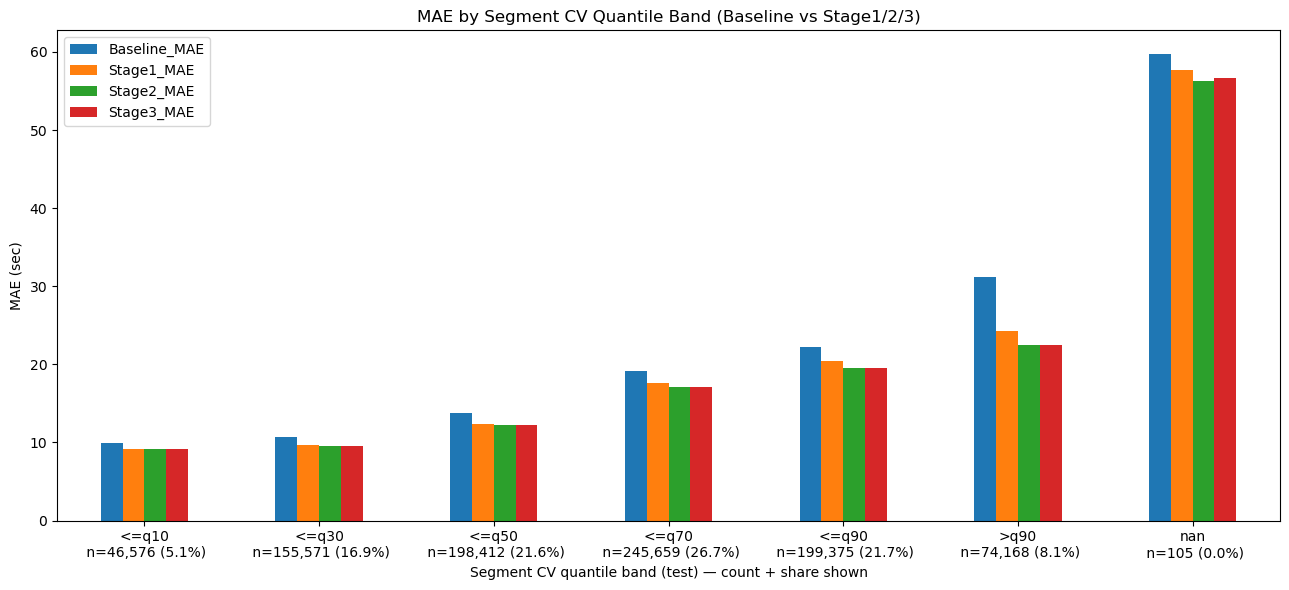

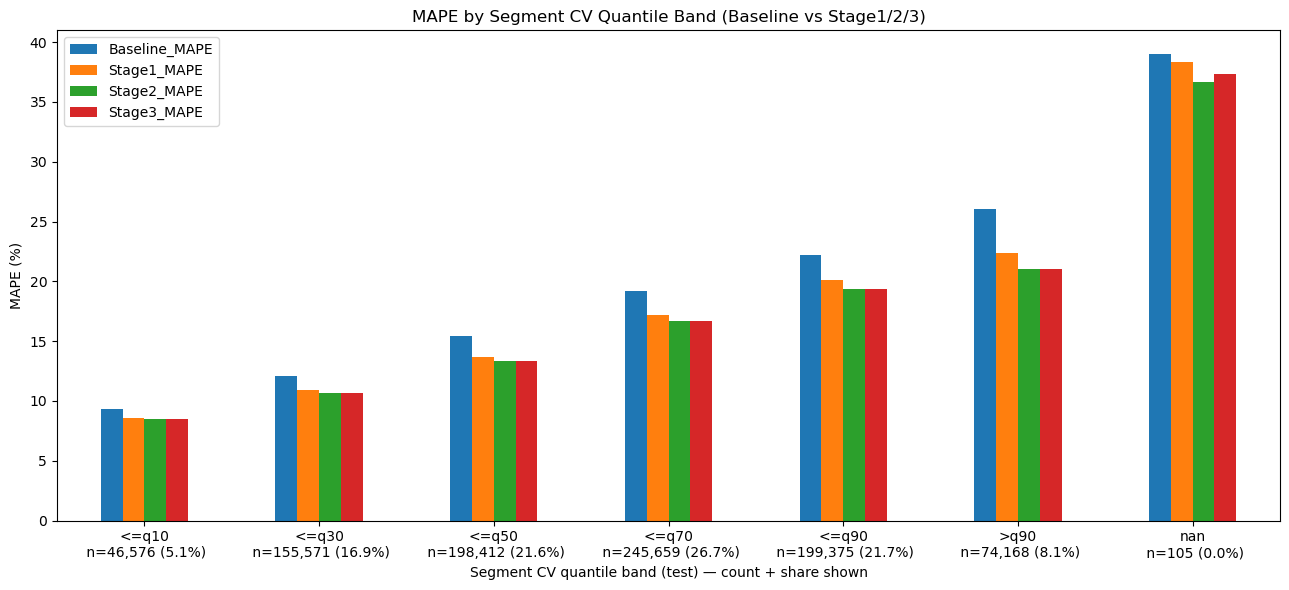

In [111]:
# After you created perf_by_q
total_n = perf_by_q["n"].sum()
perf_by_q["share_pct"] = perf_by_q["n"] / total_n * 100.0

# Build labels like: "<=q10\nn=123,456 (13.4%)"
perf_by_q["band_label"] = perf_by_q.apply(
    lambda r: f"{r['band']}\n n={int(r['n']):,} ({r['share_pct']:.1f}%)",
    axis=1
)


import matplotlib.pyplot as plt

# --- MAE bar chart ---
plot_mae = perf_by_q.set_index("band_label")[["Baseline_MAE","Stage1_MAE","Stage2_MAE","Stage3_MAE"]]
ax = plot_mae.plot(kind="bar", figsize=(13,6), rot=0)
ax.set_ylabel("MAE (sec)")
ax.set_xlabel("Segment CV quantile band (test) — count + share shown")
ax.set_title("MAE by Segment CV Quantile Band (Baseline vs Stage1/2/3)")
plt.tight_layout()
plt.show()

# --- MAPE bar chart ---
plot_mape = perf_by_q.set_index("band_label")[["Baseline_MAPE","Stage1_MAPE","Stage2_MAPE","Stage3_MAPE"]]
ax = plot_mape.plot(kind="bar", figsize=(13,6), rot=0)
ax.set_ylabel("MAPE (%)")
ax.set_xlabel("Segment CV quantile band (test) — count + share shown")
ax.set_title("MAPE by Segment CV Quantile Band (Baseline vs Stage1/2/3)")
plt.tight_layout()
plt.show()

,feature,gain,split,gain_share
45,SegmentKey,8.640777e+06,423209,0.345292
48,cell_id,2.282717e+06,133517,0.091219
46,line,1.446492e+06,141539,0.057803
11,headway_s,8.524723e+05,117421,0.034065
5,dwell_prev_s,7.810901e+05,71266,0.031213
40,line_roll_std_1h,7.069082e+05,104212,0.028249
4,E_prev,6.702393e+05,90674,0.026783
8,E_prev_prev,6.676302e+05,93821,0.026679
12,network_congestion_index,6.513910e+05,87232,0.026030
10,momentum_s,6.114903e+05,75187,0.024436


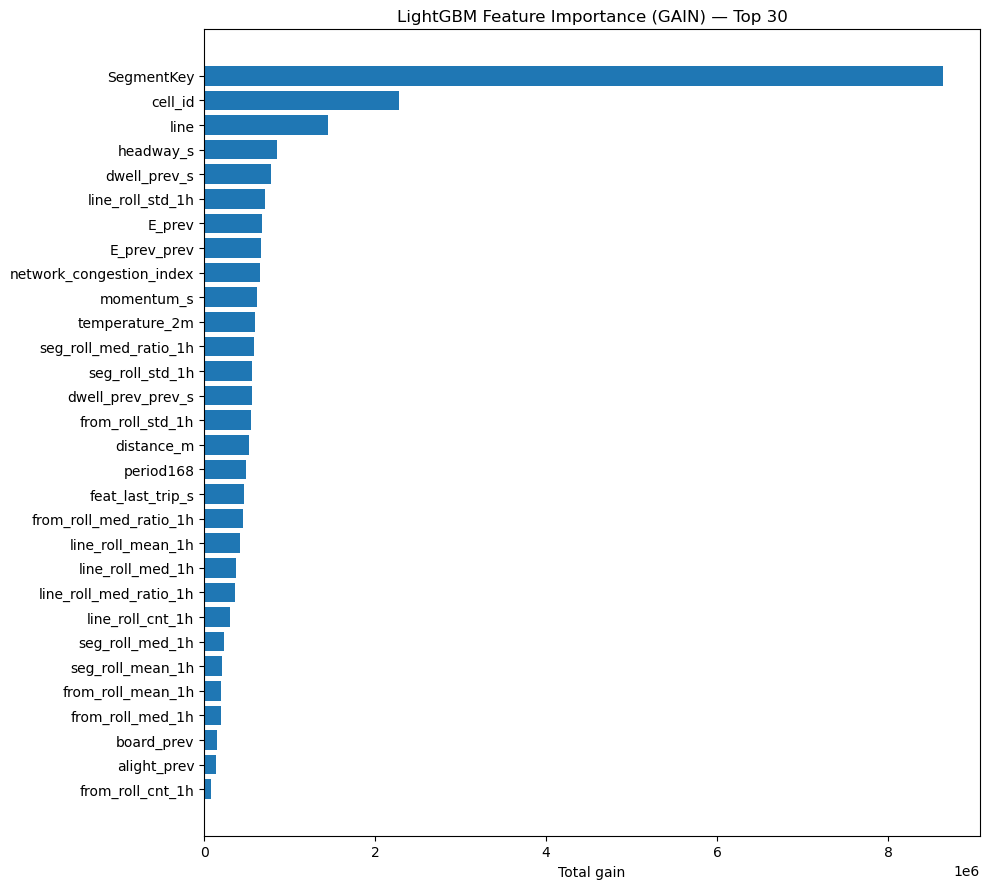

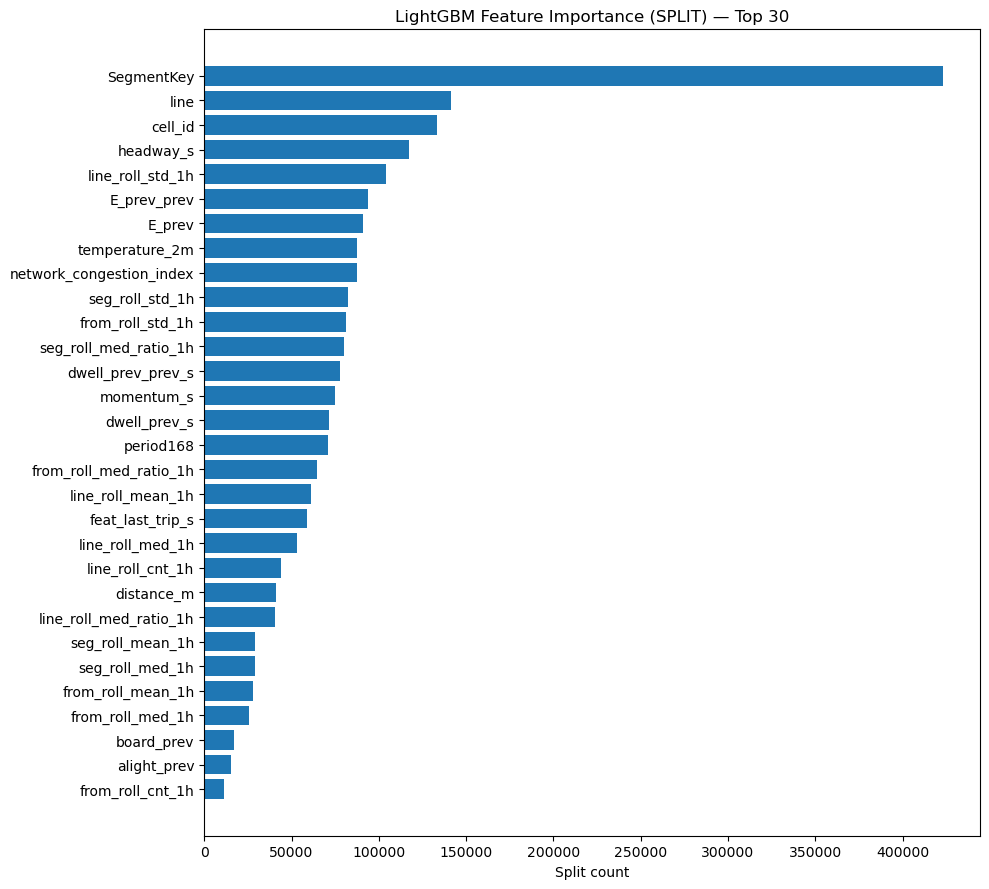

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# bst_stage3 = your trained full model (Booster)
bst = bst_stage3

# 1) Build importance table
imp = pd.DataFrame({
    "feature": bst.feature_name(),
    "gain": bst.feature_importance(importance_type="gain"),
    "split": bst.feature_importance(importance_type="split"),
})

imp["gain_share"] = imp["gain"] / imp["gain"].sum()
imp = imp.sort_values("gain", ascending=False)

display(imp.head(30))  # optional

# 2) Plot top-K by GAIN
TOPK = 30
top = imp.head(TOPK).sort_values("gain")  # sort ascending for horizontal bars

plt.figure(figsize=(10, 9))
plt.barh(top["feature"], top["gain"])
plt.title(f"LightGBM Feature Importance (GAIN) — Top {TOPK}")
plt.xlabel("Total gain")
plt.tight_layout()
plt.show()

# 3) Plot top-K by SPLIT (optional)
top2 = imp.sort_values("split", ascending=False).head(TOPK).sort_values("split")

plt.figure(figsize=(10, 9))
plt.barh(top2["feature"], top2["split"])
plt.title(f"LightGBM Feature Importance (SPLIT) — Top {TOPK}")
plt.xlabel("Split count")
plt.tight_layout()
plt.show()

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_44749/3562328017.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, line), g in p.groupby(["model", "line"], sort=False):


Overall mean MAPE by model (%):
model
Stage3_Full    15.461349
Name: mape_pct, dtype: float32

Best model: Stage3_Full

Top 10 BEST lines (lowest MAPE):
   line  n_used  mape_mean     ci_low    ci_high
42   14   55886  11.034994  10.933633  11.152472
11   12   53429  11.952894  11.667200  12.429952
10   17   40278  12.035576  11.889357  12.200721
64   75     645  12.078509  11.224514  12.926716
9    15   32813  12.900916  12.640233  13.215856
43   18   14427  13.011487  12.722467  13.273548
16   55   15692  13.269950  12.929153  13.722611
18   54    9766  13.396639  13.164803  13.600312
17   50   11165  13.491786  13.175239  13.925357
59   21   11136  13.570642  13.362378  13.822716

Top 10 WORST lines (highest MAPE):
   line  n_used  mape_mean     ci_low    ci_high
53   34     527  24.656981  19.820957  32.634205
44   83    4481  21.872538  20.291750  23.631945
41   91    4756  21.549977  20.592315  22.522106
63   48    2536  20.440869  18.892629  22.200186
6    51    2800  20.002177 

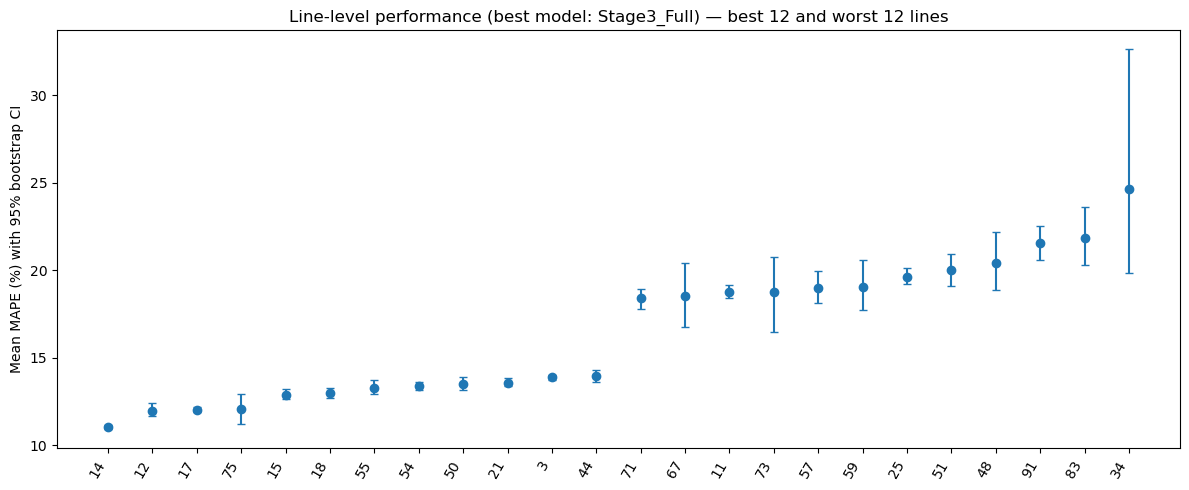

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- settings ---
BOOT = 300          # bootstrap repetitions (200–500 is usually enough)
MAX_N_PER_LINE = 80_000  # cap rows per (model,line) for speed
RNG_SEED = 42

# --- minimal frame ---
p = pred_stage3_test[["model", "line", "pct_err"]].copy()
p = p.dropna(subset=["model", "line", "pct_err"])
p["mape_pct"] = p["pct_err"].astype("float32") * 100.0

# Optional: drop insane outliers if they mess up readability (comment out if you want raw)
# p = p[p["mape_pct"] <= 500]

# --- helper: bootstrap CI for mean ---
rng = np.random.default_rng(RNG_SEED)

def boot_ci_mean(x: np.ndarray, B=BOOT):
    x = x.astype(np.float64, copy=False)
    n = x.size
    if n == 0:
        return np.nan, np.nan, np.nan
    mu = float(x.mean())
    # bootstrap means
    idx = rng.integers(0, n, size=(B, n), endpoint=False)
    means = x[idx].mean(axis=1)
    lo, hi = np.percentile(means, [2.5, 97.5])
    return mu, float(lo), float(hi)

# --- aggregate per (model,line) ---
rows = []
for (model, line), g in p.groupby(["model", "line"], sort=False):
    x = g["mape_pct"].to_numpy()
    if x.size > MAX_N_PER_LINE:
        # subsample without replacement for speed
        x = rng.choice(x, size=MAX_N_PER_LINE, replace=False)

    mu, lo, hi = boot_ci_mean(x)
    rows.append({
        "model": model,
        "line": str(line),
        "n_used": int(x.size),
        "mape_mean": mu,
        "ci_low": lo,
        "ci_high": hi,
    })

line_perf = pd.DataFrame(rows)

# --- pick the best model overall (lowest mean MAPE across all lines/rows in pred_all) ---
overall = p.groupby("model")["mape_pct"].mean().sort_values()
best_model = overall.index[0]
print("Overall mean MAPE by model (%):")
print(overall)
print("\nBest model:", best_model)

best = line_perf[line_perf["model"] == best_model].dropna(subset=["mape_mean"]).copy()
best = best.sort_values("mape_mean")

print("\nTop 10 BEST lines (lowest MAPE):")
print(best.head(10)[["line","n_used","mape_mean","ci_low","ci_high"]])

print("\nTop 10 WORST lines (highest MAPE):")
print(best.tail(10).sort_values("mape_mean", ascending=False)[["line","n_used","mape_mean","ci_low","ci_high"]])

# --- plot: top/bottom lines with CI error bars ---
top_k = 12
plot_df = pd.concat([best.head(top_k), best.tail(top_k)], ignore_index=True)
plot_df["err_low"] = plot_df["mape_mean"] - plot_df["ci_low"]
plot_df["err_high"] = plot_df["ci_high"] - plot_df["mape_mean"]
plot_df["label"] = plot_df["line"].astype(str)

plt.figure(figsize=(12, 5))
plt.errorbar(
    x=np.arange(len(plot_df)),
    y=plot_df["mape_mean"],
    yerr=[plot_df["err_low"], plot_df["err_high"]],
    fmt="o",
    capsize=3,
)
plt.xticks(np.arange(len(plot_df)), plot_df["label"], rotation=60, ha="right")
plt.ylabel("Mean MAPE (%) with 95% bootstrap CI")
plt.title(f"Line-level performance (best model: {best_model}) — best {top_k} and worst {top_k} lines")
plt.tight_layout()
plt.show()

In [120]:
import pandas as pd
import numpy as np

# --- load stops ---
stops = pd.read_csv("../data/stops_df.csv")
stops["MNLP"] = stops["MNLP"].astype(str).str.strip()
stops["X"] = pd.to_numeric(stops["X"], errors="coerce")
stops["Y"] = pd.to_numeric(stops["Y"], errors="coerce")
stops = stops.dropna(subset=["MNLP","X","Y"]).drop_duplicates("MNLP")

# --- choose which model to map ---
MODEL = "Stage3_Full"  # or "Network-Aware" etc.
p = pred_stage3_test.loc[pred_stage3_test["model"] == MODEL, ["line","SegmentKey","pct_err"]].copy()
p = p.dropna(subset=["line","SegmentKey","pct_err"])

p["mape_pct"] = p["pct_err"].astype("float32") * 100.0

# segment-level perf table
seg_perf = (
    p.groupby(["line","SegmentKey"], observed=True, sort=False)
     .agg(n=("mape_pct","size"), mape_mean=("mape_pct","mean"))
     .reset_index()
)

# share within each line
seg_perf["line_total_n"] = seg_perf.groupby("line", observed=True)["n"].transform("sum")
seg_perf["share"] = seg_perf["n"] / seg_perf["line_total_n"]


COVERAGE = 1  # 25% of trips per line

seg_perf = seg_perf.sort_values(["line","share"], ascending=[True, False])
seg_perf["cum_share"] = seg_perf.groupby("line", observed=True)["share"].cumsum()

keep = seg_perf[seg_perf["cum_share"] <= COVERAGE].copy()

print("Kept segments:", len(keep))
print("Kept lines:", keep["line"].nunique())

Kept segments: 3571
Kept lines: 66


In [124]:
from shapely.geometry import LineString
import geopandas as gpd

# split SegmentKey to stop codes
keep[["from_stop","to_stop"]] = keep["SegmentKey"].str.split("→", expand=True)
keep["from_stop"] = keep["from_stop"].astype(str).str.strip()
keep["to_stop"]   = keep["to_stop"].astype(str).str.strip()

# attach coords
st_xy = stops.set_index("MNLP")[["X","Y"]]

keep["x1"] = keep["from_stop"].map(st_xy["X"])
keep["y1"] = keep["from_stop"].map(st_xy["Y"])
keep["x2"] = keep["to_stop"].map(st_xy["X"])
keep["y2"] = keep["to_stop"].map(st_xy["Y"])

keep = keep.dropna(subset=["x1","y1","x2","y2"])

# build lines
keep["geometry"] = [
    LineString([(x1,y1),(x2,y2)])
    for x1,y1,x2,y2 in zip(keep["x1"],keep["y1"],keep["x2"],keep["y2"])
]

gseg = gpd.GeoDataFrame(keep, geometry="geometry", crs="EPSG:21781")
gseg["lw"] = 0.2 + 2.5 * (gseg["n"] / gseg["n"].max())
print(gseg.shape)

(3313, 15)


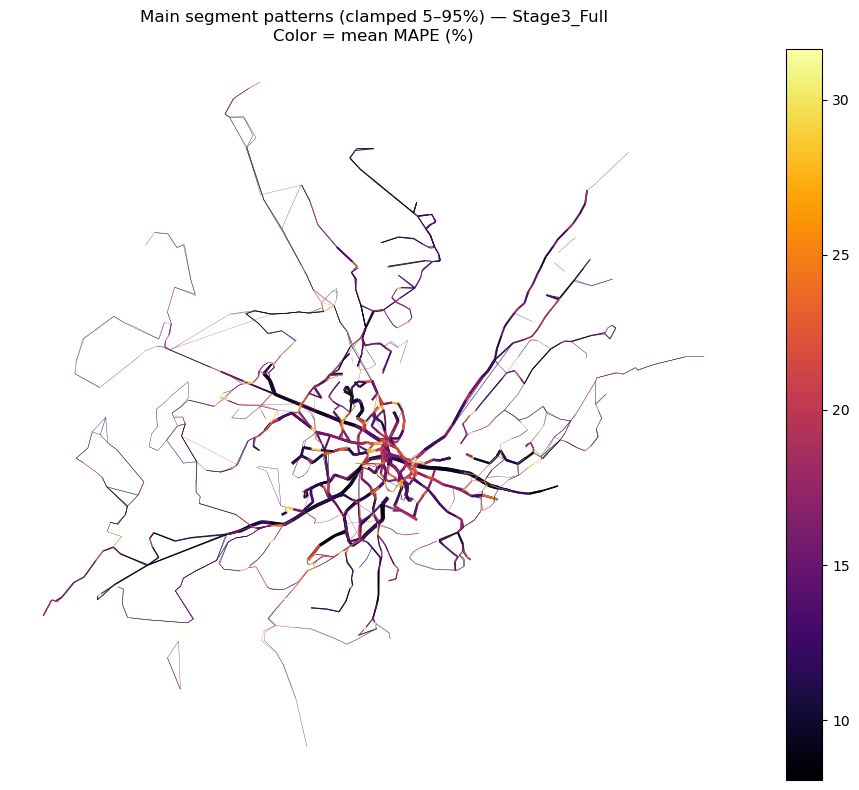

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

vmin = np.nanpercentile(gseg["mape_mean"], 5)
vmax = np.nanpercentile(gseg["mape_mean"], 95)

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # linear, but clamped

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="mape_mean",
    linewidth=gseg["lw"],
    cmap="inferno",          # try: "plasma", "magma", "viridis", "turbo"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Main segment patterns (clamped 5–95%) — {MODEL}\nColor = mean MAPE (%)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

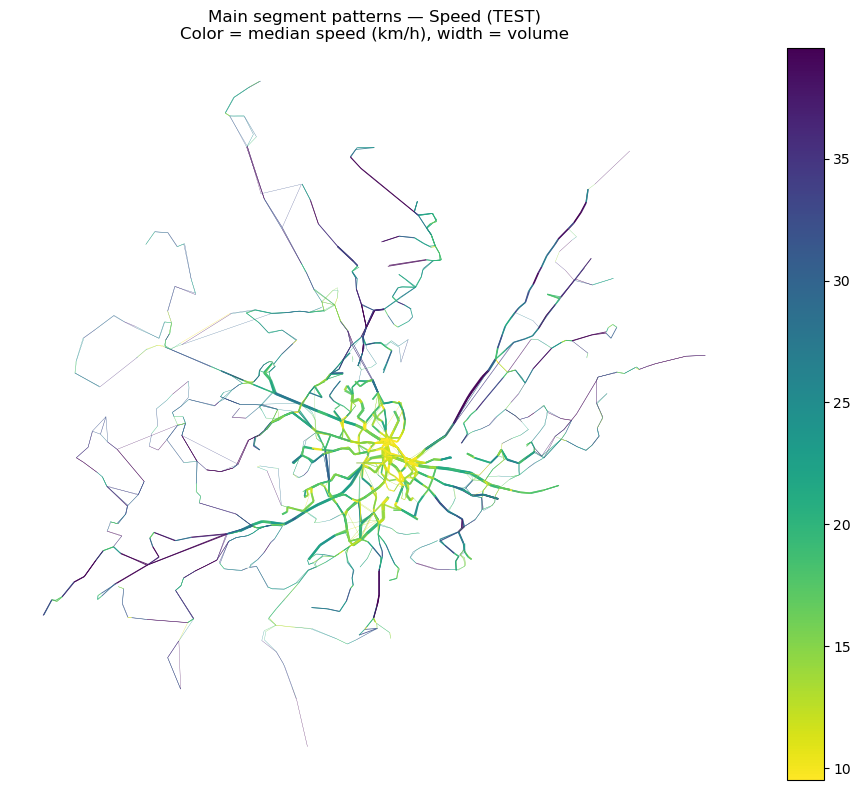

In [180]:
import pandas as pd
import numpy as np

# --- load stops ---
stops = pd.read_csv("../data/stops_df.csv")
stops["MNLP"] = stops["MNLP"].astype(str).str.strip()
stops["X"] = pd.to_numeric(stops["X"], errors="coerce")
stops["Y"] = pd.to_numeric(stops["Y"], errors="coerce")
stops = stops.dropna(subset=["MNLP","X","Y"]).drop_duplicates("MNLP", keep="first")

# --- build per-row speed on TEST (from df_ml, not pred table) ---
df_test = df_ml.loc[mask_test, ["line","SegmentKey","distance_m","link_s"]].copy()
df_test = df_test.dropna(subset=["line","SegmentKey","distance_m","link_s"])
df_test = df_test[(df_test["distance_m"] > 0) & (df_test["link_s"] > 0)]

df_test["speed_kmh"] = (df_test["distance_m"] / df_test["link_s"]) * 3.6

# segment-level speed table
seg_speed = (
    df_test.groupby(["line","SegmentKey"], observed=True, sort=False)
           .agg(n=("speed_kmh","size"),
                speed_med=("speed_kmh","median"),
                speed_mean=("speed_kmh","mean"))
           .reset_index()
)

# share within each line (for "main patterns" filtering)
seg_speed["line_total_n"] = seg_speed.groupby("line", observed=True)["n"].transform("sum")
seg_speed["share"] = seg_speed["n"] / seg_speed["line_total_n"]

# keep top coverage per line (set COVERAGE=0.25 if you want 25%)
COVERAGE = 1.0
seg_speed = seg_speed.sort_values(["line","share"], ascending=[True, False])
seg_speed["cum_share"] = seg_speed.groupby("line", observed=True)["share"].cumsum()
keep = seg_speed[seg_speed["cum_share"] <= COVERAGE].copy()

# thickness by volume
den = max(float(keep["n"].max()), 1.0)
keep["lw"] = 0.2 + 2.5 * (keep["n"] / den)

# --- geometry from SegmentKey ---
from shapely.geometry import LineString
import geopandas as gpd

keep[["from_stop","to_stop"]] = keep["SegmentKey"].astype(str).str.split("→", n=1, expand=True)
keep["from_stop"] = keep["from_stop"].astype(str).str.strip()
keep["to_stop"]   = keep["to_stop"].astype(str).str.strip()

st_xy = stops.set_index("MNLP")[["X","Y"]]
keep["x1"] = keep["from_stop"].map(st_xy["X"])
keep["y1"] = keep["from_stop"].map(st_xy["Y"])
keep["x2"] = keep["to_stop"].map(st_xy["X"])
keep["y2"] = keep["to_stop"].map(st_xy["Y"])
keep = keep.dropna(subset=["x1","y1","x2","y2"])

keep["geometry"] = [
    LineString([(x1,y1),(x2,y2)])
    for x1,y1,x2,y2 in zip(keep["x1"],keep["y1"],keep["x2"],keep["y2"])
]

gseg = gpd.GeoDataFrame(keep, geometry="geometry", crs="EPSG:21781")

# --- plot (clamp 5–95% to avoid a washed-out map) ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

vmin = np.nanpercentile(gseg["speed_med"], 5)
vmax = np.nanpercentile(gseg["speed_med"], 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="speed_med",       # or "speed_mean"
    linewidth=gseg["lw"],
    cmap="viridis_r",           # try "plasma", "magma", "turbo"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Main segment patterns — Speed (TEST)\nColor = median speed (km/h), width = volume")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [172]:
import numpy as np
import pandas as pd

p = pred_stage3_test.copy()

# 1) Attach distance_m from df_ml TEST slice (fast, avoids merges)
# Assumes pred_stage3_test was created from df_ml.loc[mask_test] in the same order.
dist = df_ml.loc[mask_test, "distance_m"].to_numpy()
assert len(dist) == len(p), "Length mismatch: pred_stage3_test vs df_ml[mask_test]. Check ordering."
p["distance_m"] = dist.astype("float32")

# 2) Time bucket
p["time_bucket"] = pd.to_datetime(p["link_start_time"]).dt.floor("1H")

# 3) Speed (m/s) and speed (km/h)
p["speed_mps"] = (p["distance_m"] / np.maximum(p["y_true"], 1e-6)).astype("float32")
p["speed_kph"] = (p["speed_mps"] * 3.6).astype("float32")

# 4) Convenience
p["mape_pct"] = (p["pct_err"] * 100.0).astype("float32")

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_44749/2648314711.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p["time_bucket"] = pd.to_datetime(p["link_start_time"]).dt.floor("1H")


In [173]:
# Segment-level free-flow proxy
free_flow = p.groupby("SegmentKey", observed=True)["speed_mps"].quantile(0.85).rename("free_flow_mps")

# Attach and compute slow ratio (0..1+; lower = slower)
p = p.join(free_flow, on="SegmentKey")
p["slow_ratio"] = (p["speed_mps"] / np.maximum(p["free_flow_mps"], 1e-6)).astype("float32")

In [174]:
agg = (
    p.groupby(["SegmentKey", "line", "dir", "time_bucket"], observed=True)
     .agg(
         n=("y_true", "size"),
         speed_med=("speed_mps", "median"),
         speed_p10=("speed_mps", lambda s: np.nanpercentile(s, 10)),
         speed_p90=("speed_mps", lambda s: np.nanpercentile(s, 90)),
         slow_ratio_med=("slow_ratio", "median"),
         mape_mean=("mape_pct", "mean"),
     )
     .reset_index()
)

# Instability: robust spread relative to median speed
agg["speed_iqr90_10"] = (agg["speed_p90"] - agg["speed_p10"]).astype("float32")
agg["instability"] = (agg["speed_iqr90_10"] / np.maximum(agg["speed_med"], 1e-6)).astype("float32")

In [175]:
# Define "slow" and "unstable" thresholds globally (quantile-based)
slow_thr = agg["slow_ratio_med"].quantile(0.25)      # bottom 25% speed ratio
unst_thr = agg["instability"].quantile(0.75)         # top 25% instability

agg["is_slow"] = (agg["slow_ratio_med"] <= slow_thr)
agg["is_unstable"] = (agg["instability"] >= unst_thr)

def quadrant(row):
    if row["is_slow"] and row["is_unstable"]:
        return "Slow + Unstable"
    if row["is_slow"] and (not row["is_unstable"]):
        return "Slow + Stable"
    if (not row["is_slow"]) and row["is_unstable"]:
        return "Fast + Unstable"
    return "Fast + Stable"

agg["quadrant"] = agg.apply(quadrant, axis=1)

In [176]:
agg["dow"] = agg["time_bucket"].dt.dayofweek
agg["hod"] = agg["time_bucket"].dt.hour + agg["time_bucket"].dt.minute / 60.0

# Example: focus on Slow+Unstable buckets only
b = agg[agg["quadrant"] == "Slow + Unstable"].copy()

# Pick top-K worst segments by average slowness+instability (with minimum support)
seg_rank = (
    b.groupby("SegmentKey", observed=True)
     .agg(n=("n","sum"), slow=("slow_ratio_med","mean"), inst=("instability","mean"))
)
seg_rank = seg_rank[seg_rank["n"] >= 50].copy()
seg_rank["score"] = (1 - seg_rank["slow"]) + seg_rank["inst"]
topK = seg_rank.sort_values("score", ascending=False).head(20).index

b_top = b[b["SegmentKey"].isin(topK)].copy()

# Heatmap table: mean slow_ratio by (dow, hod) for topK combined
heat = (
    b_top.groupby(["dow","hod"], observed=True)
         .agg(slow_ratio=("slow_ratio_med","mean"), n=("n","sum"))
         .reset_index()
)

In [182]:
print("Speed_kph summary:", p["speed_kph"].describe(percentiles=[.01,.05,.5,.95,.99]))
print("Slow ratio summary:", agg["slow_ratio_med"].describe(percentiles=[.05,.25,.5,.75,.95]))
print("Instability summary:", agg["instability"].describe(percentiles=[.05,.25,.5,.75,.95]))
print(agg["quadrant"].value_counts())

Speed_kph summary: count    919866.000000
mean         18.917490
std          10.077148
min           0.000000
1%            0.000000
5%            6.791555
50%          17.236364
95%          37.687500
99%          48.936260
max         608.399963
Name: speed_kph, dtype: float64
Slow ratio summary: count    3.010760e+05
mean     2.950340e+01
std      1.314228e+04
min      0.000000e+00
5%       5.062456e-01
25%      7.162997e-01
50%      8.360366e-01
75%      9.391709e-01
95%      1.127685e+00
max      7.030864e+06
Name: slow_ratio_med, dtype: float64
Instability summary: count    3.010760e+05
mean     1.135307e+04
std      2.340433e+05
min      0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      1.497835e-01
75%      3.295447e-01
95%      7.342500e-01
max      3.330000e+07
Name: instability, dtype: float64
quadrant
Fast + Stable      182832
Slow + Stable       42975
Fast + Unstable     42975
Slow + Unstable     32294
Name: count, dtype: int64


In [183]:
import numpy as np
import pandas as pd

# --- segment-level summary from agg (collapse over time) ---
seg_map = (
    agg.groupby(["line","dir","SegmentKey"], observed=True, sort=False)
       .agg(
           n=("n","sum"),
           speed_kph_mean=("speed_med", lambda s: float(np.nanmean(s) * 3.6)),  # speed_med is m/s
           slow_ratio_mean=("slow_ratio_med","mean"),
           instability_mean=("instability","mean"),
           mape_mean=("mape_mean","mean"),
       )
       .reset_index()
)

# share within each line (by counts)
seg_map["line_total_n"] = seg_map.groupby("line", observed=True)["n"].transform("sum")
seg_map["share"] = seg_map["n"] / seg_map["line_total_n"]

# keep top coverage within each line (main trip patterns)
COVERAGE = 1  # e.g. 25% of trips per line; set 1.0 to keep all
seg_map = seg_map.sort_values(["line","share"], ascending=[True, False])
seg_map["cum_share"] = seg_map.groupby("line", observed=True)["share"].cumsum()
keep = seg_map[seg_map["cum_share"] <= COVERAGE].copy()

print("Kept segments:", len(keep), "| Kept lines:", keep["line"].nunique())

Kept segments: 3647 | Kept lines: 66


In [184]:
import numpy as np
import pandas as pd

EPS = 1e-6

# pick which split to compute "instability" on
# (use mask_test if you're analysing test period bottlenecks)
base = df_ml.loc[mask_test, ["link_start_time","SegmentKey","line","dir","distance_m","link_s"]].copy()

base["speed_mps"] = base["distance_m"] / base["link_s"]
base.loc[~np.isfinite(base["speed_mps"]), "speed_mps"] = np.nan
base.loc[(base["speed_mps"] <= 0) | (base["speed_mps"] > 40), "speed_mps"] = np.nan  # sanity cap (~144 km/h)

base["time_bucket"] = pd.to_datetime(base["link_start_time"]).dt.floor("15min")

# median speed per 15-min bucket (reduces noise)
tb = (
    base.groupby(["line","dir","SegmentKey","time_bucket"], observed=True, sort=False)
        .agg(speed_med=("speed_mps","median"),
             n=("speed_mps","size"))
        .reset_index()
)

# CV over time (std/mean across time buckets)
seg_cv = (
    tb.groupby(["line","dir","SegmentKey"], observed=True, sort=False)
      .agg(speed_med_mean=("speed_med","mean"),
           speed_med_std=("speed_med","std"),
           n_buckets=("time_bucket","nunique"),
           n_obs=("n","sum"))
      .reset_index()
)

seg_cv["cv_speed"] = seg_cv["speed_med_std"] / np.maximum(seg_cv["speed_med_mean"], EPS)
seg_cv["cv_speed_pct"] = 100.0 * seg_cv["cv_speed"]

In [185]:
import geopandas as gpd
from shapely.geometry import LineString

# --- load stops ---
stops = pd.read_csv("../data/stops_df.csv")
stops.columns = stops.columns.str.strip()
stops["MNLP"] = stops["MNLP"].astype(str).str.strip()
stops["X"] = pd.to_numeric(stops["X"], errors="coerce")
stops["Y"] = pd.to_numeric(stops["Y"], errors="coerce")
stops = stops.dropna(subset=["MNLP","X","Y"]).drop_duplicates("MNLP", keep="first")

st_xy = stops.set_index("MNLP")[["X","Y"]]

# split SegmentKey
keep[["from_stop","to_stop"]] = keep["SegmentKey"].astype(str).str.split("→", n=1, expand=True)
keep["from_stop"] = keep["from_stop"].astype(str).str.strip()
keep["to_stop"]   = keep["to_stop"].astype(str).str.strip()

# map coords
keep["x1"] = keep["from_stop"].map(st_xy["X"])
keep["y1"] = keep["from_stop"].map(st_xy["Y"])
keep["x2"] = keep["to_stop"].map(st_xy["X"])
keep["y2"] = keep["to_stop"].map(st_xy["Y"])
keep = keep.dropna(subset=["x1","y1","x2","y2"]).copy()

# geometry
keep["geometry"] = [
    LineString([(x1,y1),(x2,y2)])
    for x1,y1,x2,y2 in zip(keep["x1"],keep["y1"],keep["x2"],keep["y2"])
]

gseg = gpd.GeoDataFrame(keep, geometry="geometry", crs="EPSG:21781")

# linewidth by volume
gseg["lw"] = 0.2 + 2.5 * (gseg["n"] / gseg["n"].max())

import matplotlib.colors as mcolors
import numpy as np

def clamp_norm(series, lo=5, hi=95):
    vmin = np.nanpercentile(series.to_numpy(), lo)
    vmax = np.nanpercentile(series.to_numpy(), hi)
    return mcolors.Normalize(vmin=vmin, vmax=vmax)

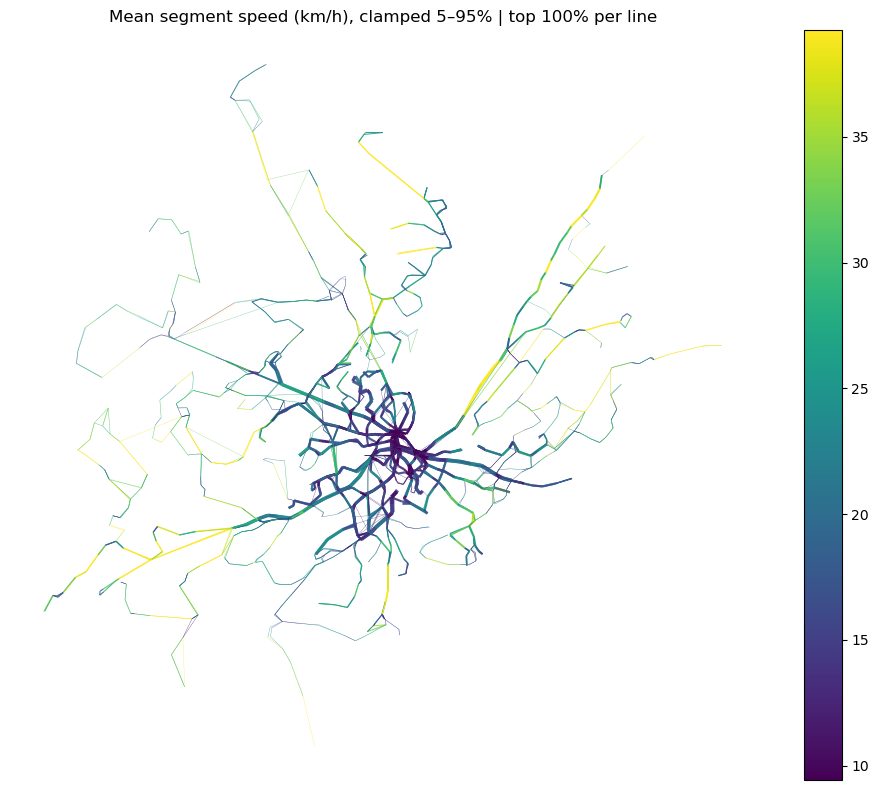

In [165]:
import matplotlib.pyplot as plt

norm = clamp_norm(gseg["speed_kph_mean"], 5, 95)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="speed_kph_mean",
    linewidth=gseg["lw"],
    cmap="viridis",          # try "magma", "plasma", "turbo"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Mean segment speed (km/h), clamped 5–95% | top {int(COVERAGE*100)}% per line")
ax.set_axis_off()
plt.tight_layout()
plt.show()

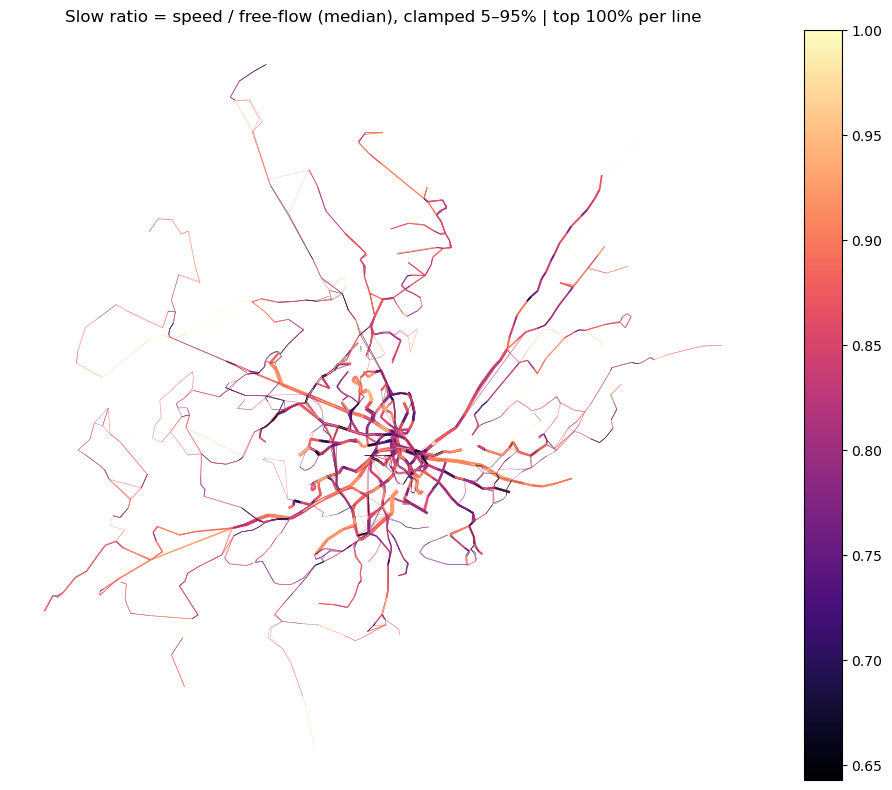

In [186]:
import matplotlib.pyplot as plt

norm = clamp_norm(gseg["slow_ratio_mean"], 5, 95)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="slow_ratio_mean",
    linewidth=gseg["lw"],
    cmap="magma",            # invert with "magma_r"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Slow ratio = speed / free-flow (median), clamped 5–95% | top {int(COVERAGE*100)}% per line")
ax.set_axis_off()
plt.tight_layout()
plt.show()

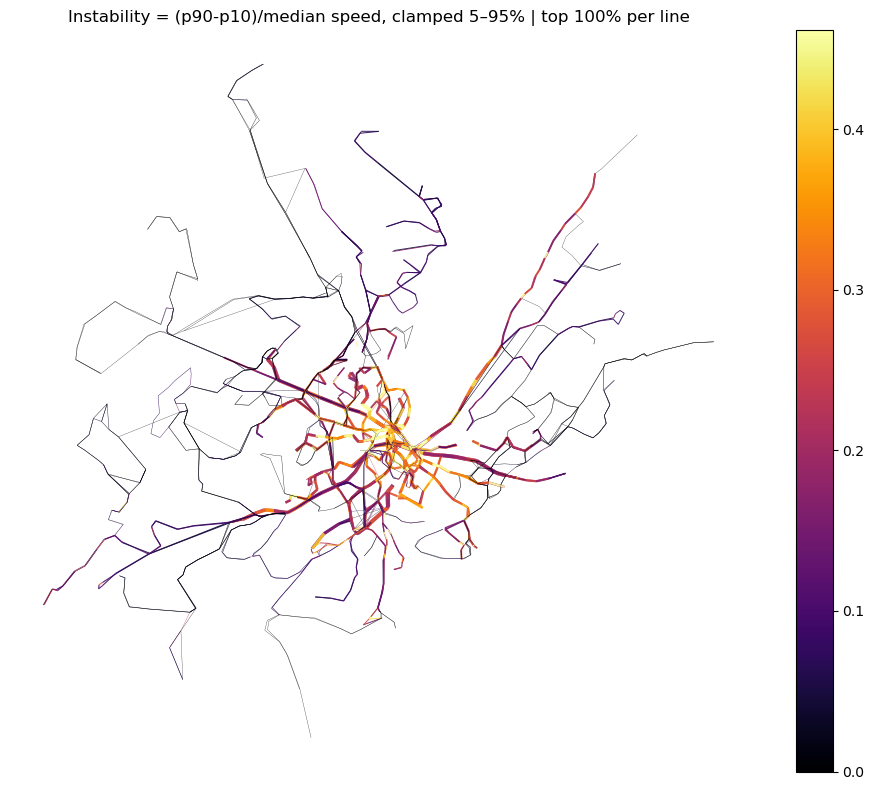

In [187]:
import matplotlib.pyplot as plt

norm = clamp_norm(gseg["instability_mean"], 5, 95)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="instability_mean",
    linewidth=gseg["lw"],
    cmap="inferno",          # invert with "inferno_r"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Instability = (p90-p10)/median speed, clamped 5–95% | top {int(COVERAGE*100)}% per line")
ax.set_axis_off()
plt.tight_layout()
plt.show()

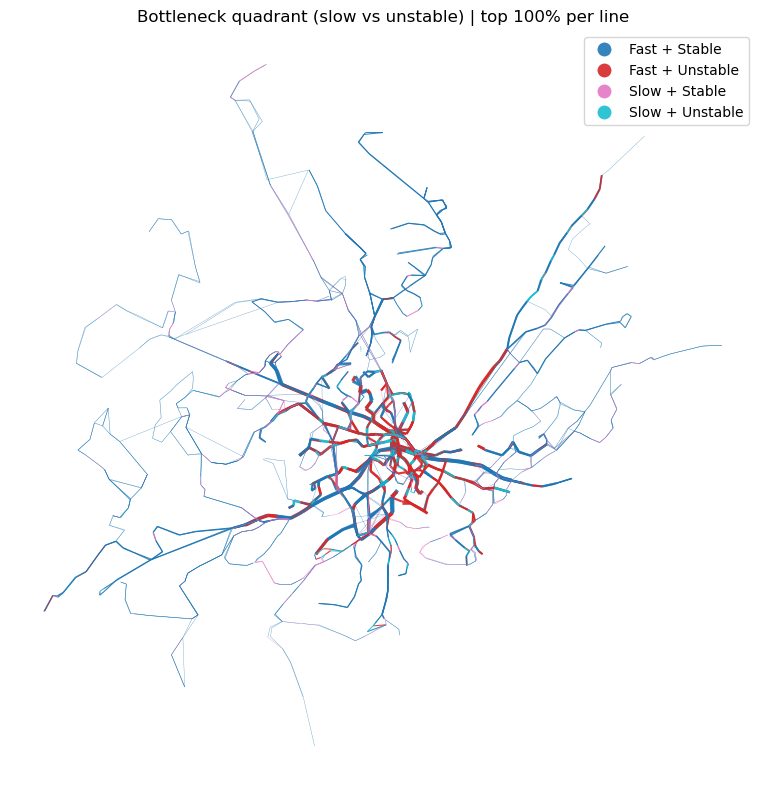

In [189]:
# thresholds based on segment-level distribution (you can tune these)
slow_thr = gseg["slow_ratio_mean"].quantile(0.25)
unst_thr = gseg["instability_mean"].quantile(0.75)

gseg["quadrant"] = np.select(
    [
        (gseg["slow_ratio_mean"] <= slow_thr) & (gseg["instability_mean"] >= unst_thr),
        (gseg["slow_ratio_mean"] <= slow_thr) & (gseg["instability_mean"] <  unst_thr),
        (gseg["slow_ratio_mean"] >  slow_thr) & (gseg["instability_mean"] >= unst_thr),
    ],
    ["Slow + Unstable", "Slow + Stable", "Fast + Unstable"],
    default="Fast + Stable"
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="quadrant",
    categorical=True,
    legend=True,
    linewidth=gseg["lw"],
    alpha=0.9
)
ax.set_title(f"Bottleneck quadrant (slow vs unstable) | top {int(COVERAGE*100)}% per line")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make sure datetime
p["link_start_time"] = pd.to_datetime(p["link_start_time"], errors="coerce")
p = p.dropna(subset=["link_start_time", "mape_pct"])

BUCKET = "1H"   # change to "30min" or "15min" if needed
p["time_bucket"] = p["link_start_time"].dt.floor(BUCKET)

p["date"] = p["link_start_time"].dt.floor("D")
p["hour"] = p["link_start_time"].dt.hour
p["dow"]  = p["link_start_time"].dt.dayofweek   # 0=Mon ... 6=Sun

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_44749/247396374.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  p["time_bucket"] = p["link_start_time"].dt.floor(BUCKET)


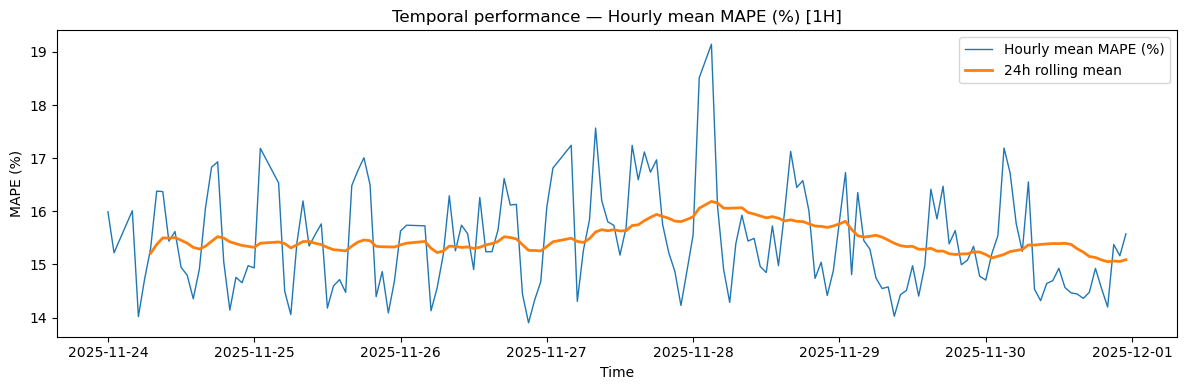

In [191]:
ts = (p.groupby("time_bucket", sort=False, observed=True)
        .agg(n=("mape_pct","size"), mape_mean=("mape_pct","mean"))
        .reset_index())

ts = ts.sort_values("time_bucket")
ts["mape_roll_24h"] = ts["mape_mean"].rolling(24, min_periods=6).mean()

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ts["time_bucket"], ts["mape_mean"], linewidth=1, label="Hourly mean MAPE (%)")
ax.plot(ts["time_bucket"], ts["mape_roll_24h"], linewidth=2, label="24h rolling mean")

ax.set_title(f"Temporal performance — Hourly mean MAPE (%) [{BUCKET}]")
ax.set_ylabel("MAPE (%)")
ax.set_xlabel("Time")
ax.legend()
plt.tight_layout()
plt.show()

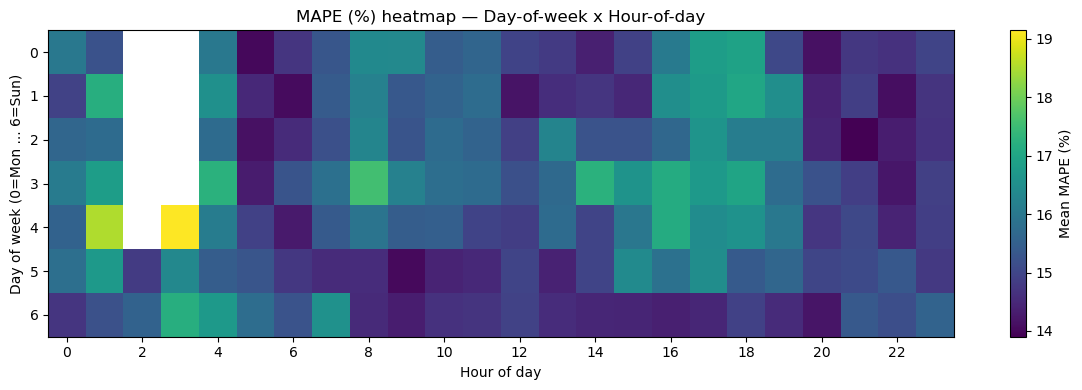

In [192]:
grid = (p.groupby(["dow","hour"], observed=True)
          .agg(mape_mean=("mape_pct","mean"), n=("mape_pct","size"))
          .reset_index())

heat = grid.pivot(index="dow", columns="hour", values="mape_mean")

fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(heat.values, aspect="auto")

ax.set_title("MAPE (%) heatmap — Day-of-week x Hour-of-day")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Day of week (0=Mon ... 6=Sun)")
ax.set_xticks(np.arange(0, 24, 2))
ax.set_xticklabels([str(h) for h in range(0,24,2)])
ax.set_yticks(np.arange(7))
ax.set_yticklabels([str(i) for i in range(7)])


cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Mean MAPE (%)")
plt.tight_layout()
plt.show()


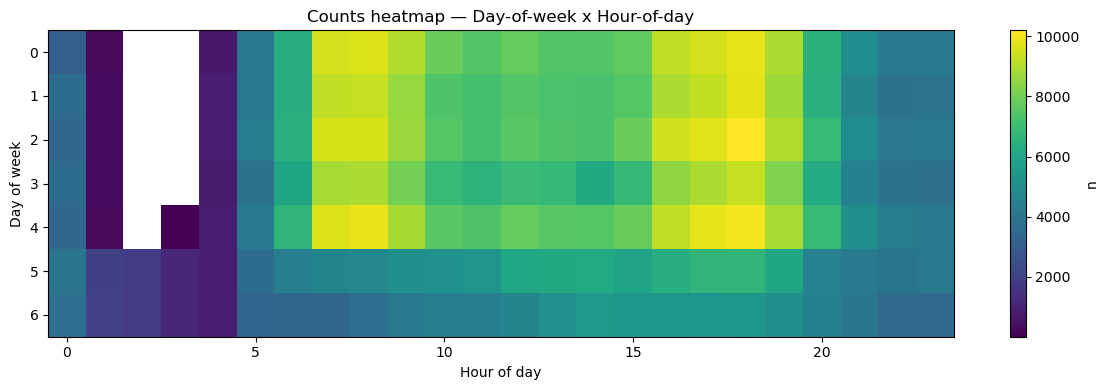

In [193]:
heat_n = grid.pivot(index="dow", columns="hour", values="n")
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(heat_n.values, aspect="auto")
ax.set_title("Counts heatmap — Day-of-week x Hour-of-day")
ax.set_xlabel("Hour of day"); ax.set_ylabel("Day of week")
plt.colorbar(im, ax=ax, label="n")
plt.tight_layout()
plt.show()

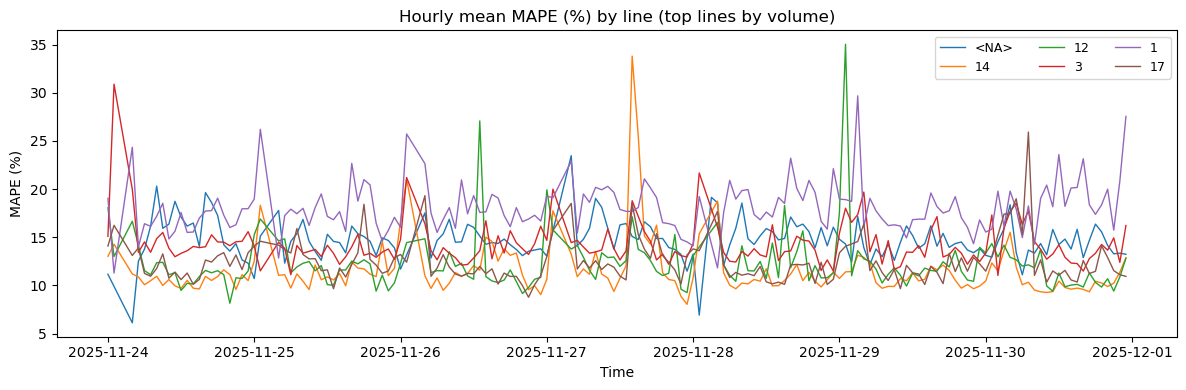

In [194]:
line_n = (p.groupby("line", observed=True)["mape_pct"].size().sort_values(ascending=False))
top_lines = line_n.head(6).index.tolist()   # change 6 to what you want

ts_line = (p[p["line"].isin(top_lines)]
           .groupby(["time_bucket","line"], observed=True, sort=False)
           .agg(n=("mape_pct","size"), mape_mean=("mape_pct","mean"))
           .reset_index()
           .sort_values("time_bucket"))

fig, ax = plt.subplots(figsize=(12,4))
for ln in top_lines:
    s = ts_line[ts_line["line"] == ln]
    ax.plot(s["time_bucket"], s["mape_mean"], linewidth=1, label=str(ln))

ax.set_title("Hourly mean MAPE (%) by line (top lines by volume)")
ax.set_ylabel("MAPE (%)"); ax.set_xlabel("Time")
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

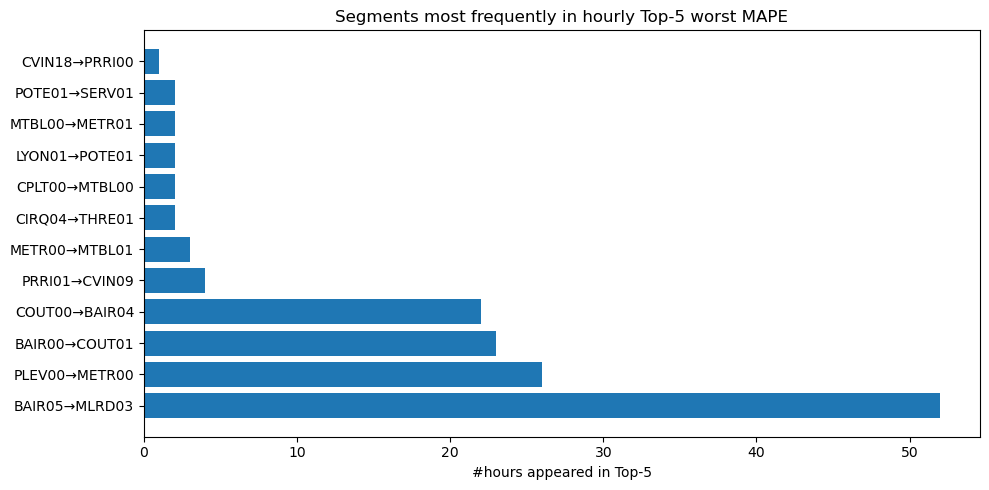

In [196]:
# hourly per-segment MAPE (can be big)
seg_hour = (p.groupby(["time_bucket","SegmentKey"], observed=True, sort=False)
              .agg(n=("mape_pct","size"), mape_mean=("mape_pct","mean"))
              .reset_index())

# keep reliable rows
seg_hour = seg_hour[seg_hour["n"] >= 30]  # adjust

# per hour, pick top 5 worst segments
seg_hour = seg_hour.sort_values(["time_bucket","mape_mean"], ascending=[True, False])
topk = seg_hour.groupby("time_bucket", observed=True).head(5)

# example: plot counts of how often a segment appears in "top 5"
seg_counts = (topk.groupby("SegmentKey", observed=True)
                 .size()
                 .sort_values(ascending=False)
                 .head(20))

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(seg_counts.index.astype(str), seg_counts.values)
ax.set_title("Segments most frequently in hourly Top-5 worst MAPE")
ax.set_xlabel("#hours appeared in Top-5")
plt.tight_layout()
plt.show()

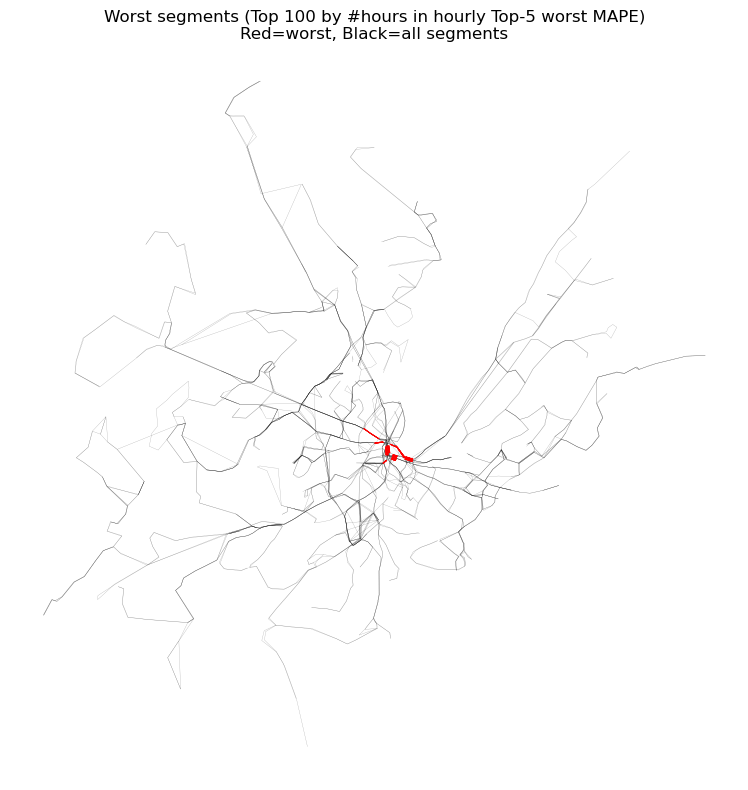

In [197]:
# From your earlier step 5 outputs:
# topk: rows = [time_bucket, SegmentKey, n, mape_mean] for top-5 worst per hour
# seg_counts: Series indexed by SegmentKey with counts (#hours in top-5)

# If you don't have seg_counts saved, rebuild quickly:
seg_counts = (topk.groupby("SegmentKey", observed=True)
                 .size()
                 .sort_values(ascending=False))

TOPN = 100   # how many worst segments to highlight
worst_keys = seg_counts.head(TOPN).index.tolist()

# Create highlight GeoDataFrame
g_all = gseg.copy()

g_worst = g_all[g_all["SegmentKey"].isin(worst_keys)].copy()

# Optional: thickness by how frequently it appears in top-5
g_worst["bad_hours"] = g_worst["SegmentKey"].map(seg_counts).fillna(0).astype(int)

# line width scaling (optional)
if len(g_worst) > 0:
    mx = max(g_worst["bad_hours"].max(), 1)
    g_worst["lw_red"] = 0.5 + 3.5 * (g_worst["bad_hours"] / mx)
else:
    g_worst["lw_red"] = 2.0

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 1) background = all segments in black
g_all.plot(
    ax=ax,
    color="black",
    linewidth=0.2,
    alpha=0.35
)

# 2) overlay = worst segments in red
g_worst.plot(
    ax=ax,
    color="red",
    linewidth=g_worst["lw_red"],   # or a constant like 2.0
    alpha=0.95
)

ax.set_title(f"Worst segments (Top {TOPN} by #hours in hourly Top-5 worst MAPE)\nRed=worst, Black=all segments")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL = "Stage3_Full"   # adjust if your model label differs

p = pred_stage3_test.loc[pred_stage3_test["model"] == MODEL].copy()
p["link_start_time"] = pd.to_datetime(p["link_start_time"], errors="coerce")
p = p.dropna(subset=["link_start_time", "line", "pct_err", "abs_err", "y_true", "y_pred"])

p["mape_pct"] = p["pct_err"].astype("float32") * 100.0
p["hour"] = p["link_start_time"].dt.hour
p["dow"]  = p["link_start_time"].dt.dayofweek

In [200]:
line_perf = (
    p.groupby("line", observed=True)
     .agg(
         n=("mape_pct","size"),
         mape_mean=("mape_pct","mean"),
         mape_std=("mape_pct","std"),
         mape_p50=("mape_pct", lambda s: np.percentile(s, 50)),
         mape_p90=("mape_pct", lambda s: np.percentile(s, 90)),
         mae_mean=("abs_err","mean"),
         mae_p90=("abs_err", lambda s: np.percentile(s, 90)),
     )
     .reset_index()
)

line_perf["share"] = line_perf["n"] / line_perf["n"].sum()
line_perf = line_perf.sort_values("mape_mean", ascending=True)

print(line_perf.head(20))   # best lines by mean MAPE
print("\nWorst lines:")
print(line_perf.sort_values("mape_mean", ascending=False).head(20))

    line      n  mape_mean   mape_std   mape_p50   mape_p90   mae_mean  \
4     14  55886  11.034994  14.191205   7.987269  23.755550  12.679087   
3     12  53429  11.952894  44.977989   8.081475  25.422385  12.999812   
6     17  40278  12.035576  15.653814   8.466963  26.617515  11.935922   
56    75    645  12.078508  11.440687   9.084415  25.487533  10.775529   
5     15  32813  12.900916  26.649532   8.846087  28.243276  14.882144   
7     18  14427  13.011487  18.195133   9.062292  28.211441  14.981669   
39    55  15692  13.269950  27.702129   9.418730  27.983750  10.834544   
38    54   9766  13.396638  12.540174  10.022592  28.554007  10.076062   
34    50  11165  13.491787  21.770620  10.248070  28.444439  10.577226   
11    21  11136  13.570642  13.844110   9.999416  28.926538  16.200375   
16     3  41895  13.884522  13.847993  10.030268  30.465014  14.481418   
28    44   6233  13.944297  14.356632   9.841640  30.853431  10.594533   
55    74   1612  13.997499  13.501348 

In [201]:
MIN_N = 1000
line_perf_f = line_perf[line_perf["n"] >= MIN_N].copy()

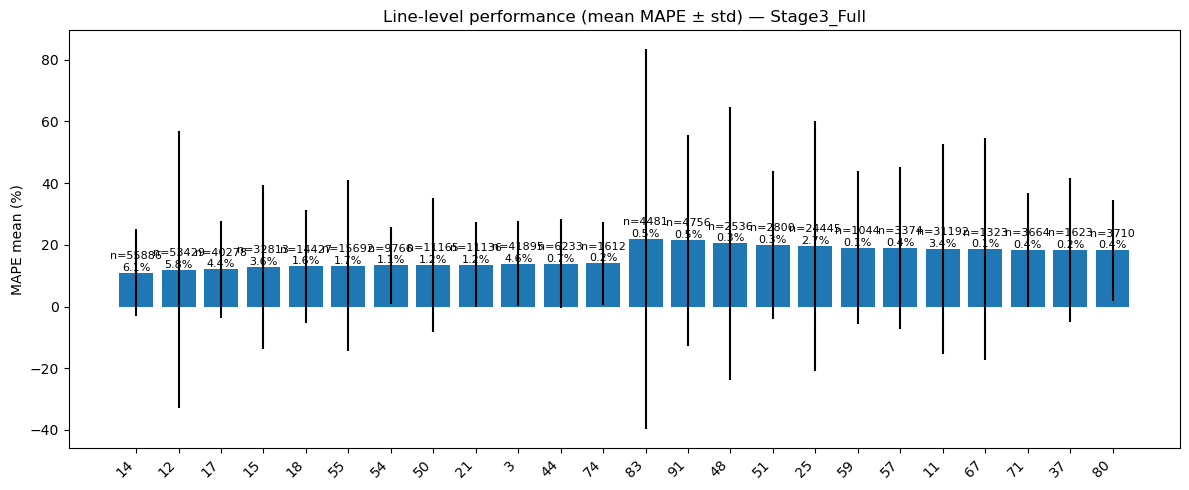

In [202]:
K = 12
use = line_perf_f if "line_perf_f" in globals() else line_perf

best = use.nsmallest(K, "mape_mean")
worst = use.nlargest(K, "mape_mean")
plot_df = pd.concat([best, worst], ignore_index=True)

fig, ax = plt.subplots(figsize=(12,5))
x = np.arange(len(plot_df))
ax.bar(x, plot_df["mape_mean"].values, yerr=plot_df["mape_std"].values)

ax.set_xticks(x)
ax.set_xticklabels(plot_df["line"].astype(str), rotation=45, ha="right")
ax.set_ylabel("MAPE mean (%)")
ax.set_title(f"Line-level performance (mean MAPE ± std) — {MODEL}")

# annotate n and share
for i, (m, n, sh) in enumerate(zip(plot_df["mape_mean"], plot_df["n"], plot_df["share"])):
    ax.text(i, m, f"n={n}\n{sh:.1%}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

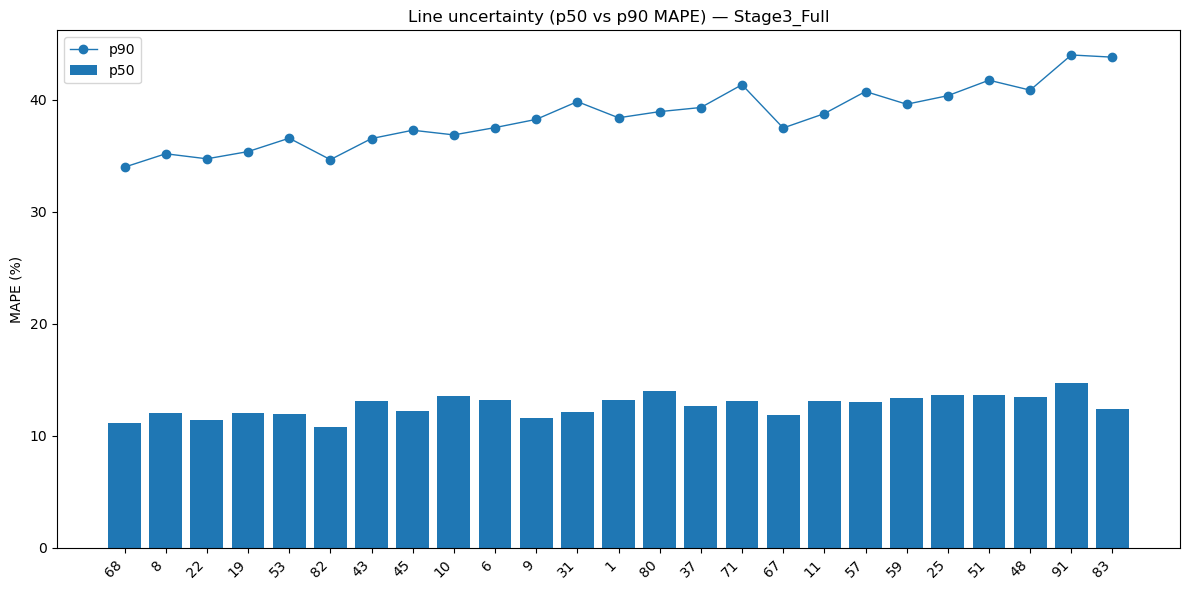

In [203]:
use = line_perf_f if "line_perf_f" in globals() else line_perf
use = use.sort_values("mape_mean").tail(25)  # focus on worst 25; change as needed

fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(use))

ax.bar(x, use["mape_p50"], label="p50")
ax.plot(x, use["mape_p90"], marker="o", linewidth=1, label="p90")

ax.set_xticks(x)
ax.set_xticklabels(use["line"].astype(str), rotation=45, ha="right")
ax.set_ylabel("MAPE (%)")
ax.set_title(f"Line uncertainty (p50 vs p90 MAPE) — {MODEL}")
ax.legend()
plt.tight_layout()
plt.show()

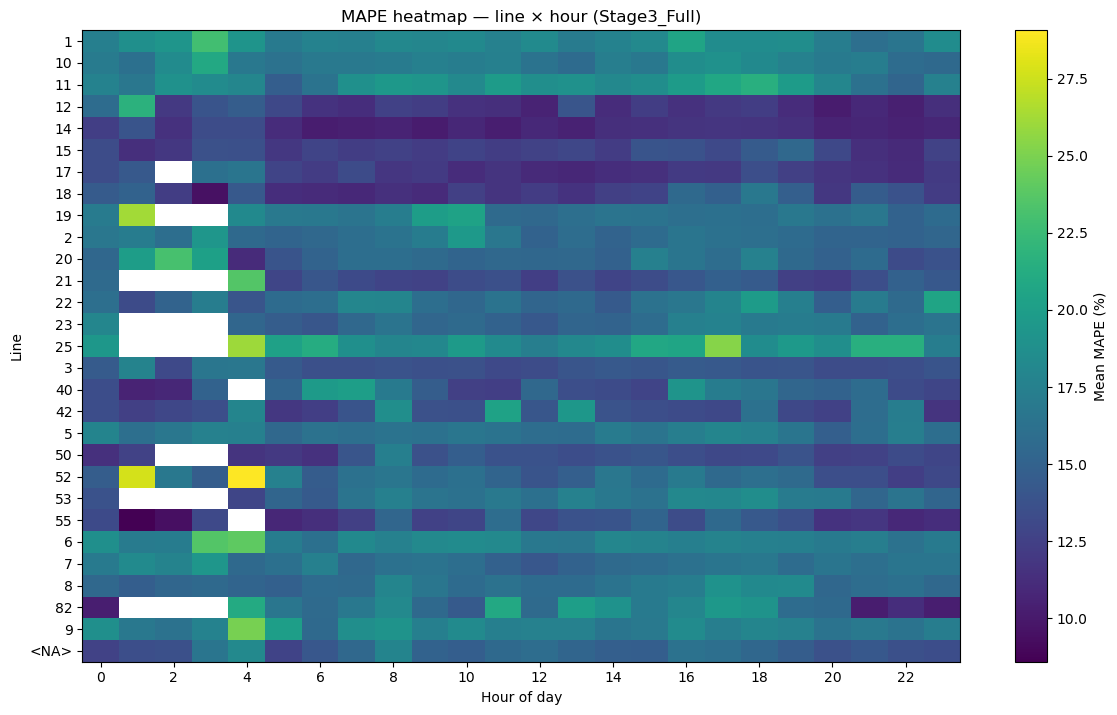

In [205]:
grid = (p.groupby(["line","hour"], observed=True)
          .agg(mape_mean=("mape_pct","mean"), n=("mape_pct","size"))
          .reset_index())

# keep only lines with enough total volume
line_total = grid.groupby("line", observed=True)["n"].sum()
keep_lines = line_total[line_total >= 10000].index  # adjust
grid = grid[grid["line"].isin(keep_lines)]

heat = grid.pivot(index="line", columns="hour", values="mape_mean").fillna(np.nan)

fig, ax = plt.subplots(figsize=(12, max(4, 0.25*heat.shape[0])))
im = ax.imshow(heat.values, aspect="auto")

ax.set_title(f"MAPE heatmap — line × hour ({MODEL})")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Line")
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels([str(h) for h in range(0,24,2)])
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index.astype(str))

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Mean MAPE (%)")
plt.tight_layout()
plt.show()

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_44749/4282287446.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(lines))


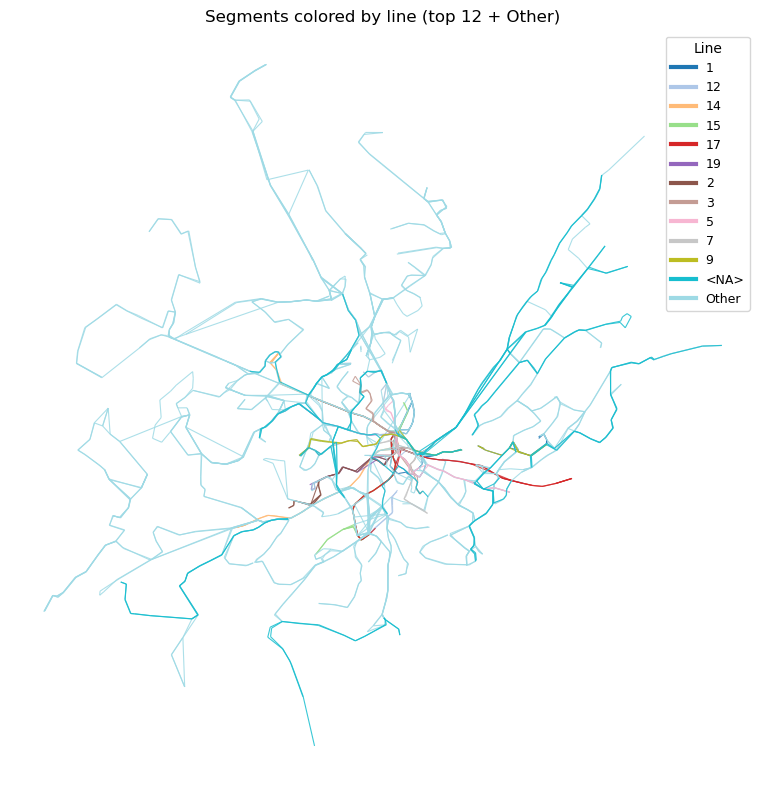

In [207]:
TOPK = 12
line_mass = gseg.groupby("line", observed=True)["n"].sum().sort_values(ascending=False)
top_lines = line_mass.head(TOPK).index.astype(str).tolist()

gseg_plot = gseg.copy()
gseg_plot["line_plot"] = np.where(gseg_plot["line"].astype(str).isin(top_lines),
                                  gseg_plot["line"].astype(str),
                                  "Other")

lines = sorted(gseg_plot["line_plot"].unique())
line2code = {ln:i for i, ln in enumerate(lines)}
gseg_plot["line_code"] = gseg_plot["line_plot"].map(line2code)

cmap = cm.get_cmap("tab20", len(lines))
norm = mcolors.BoundaryNorm(np.arange(-0.5, len(lines)+0.5, 1), cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg_plot.plot(ax=ax, column="line_code", cmap=cmap, norm=norm, linewidth=0.8, alpha=0.85)
ax.set_title(f"Segments colored by line (top {TOPK} + Other)")
ax.set_axis_off()

handles = [plt.Line2D([0],[0], color=cmap(line2code[ln]), lw=3) for ln in lines]
ax.legend(handles, lines, title="Line", loc="upper right", fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()

In [208]:
p

,link_start_time,SegmentKey,line,dir,y_true,y_base,pred_residual,y_pred,residual,abs_err,pct_err,model,mape_pct,hour,dow
3794,2025-11-24 00:01:29,31DC00→PLEV00,9,A,159.0,134.0,2.328404,136.328404,22.671596,22.671596,0.142589,Stage3_Full,14.258866,0,0
3795,2025-11-24 00:36:29,31DC00→PLEV00,9,A,131.0,134.0,5.940244,139.940244,-8.940244,8.940244,0.068246,Stage3_Full,6.824614,0,0
3796,2025-11-24 00:51:53,31DC00→PLEV00,<NA>,R,117.0,134.0,-8.855846,125.144154,-8.144154,8.144154,0.069608,Stage3_Full,6.960815,0,0
3797,2025-11-24 05:07:48,31DC00→PLEV00,9,A,192.0,181.0,7.736900,188.736900,3.263100,3.263100,0.016995,Stage3_Full,1.699531,5,0
3798,2025-11-24 05:42:39,31DC00→PLEV00,9,A,132.0,181.0,2.995221,183.995221,-51.995221,51.995221,0.393903,Stage3_Full,39.390320,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009293,2025-11-28 18:38:42,_PEDOS→PEDO01,80,R,34.0,38.0,-7.054228,30.945772,3.054228,3.054228,0.089830,Stage3_Full,8.983023,18,4
5009294,2025-11-28 19:25:15,_PEDOS→PEDO01,80,R,34.0,32.0,11.829367,43.829367,-9.829367,9.829367,0.289099,Stage3_Full,28.909904,19,4
5009295,2025-11-28 20:54:21,_PEDOS→PEDO01,80,R,40.0,34.5,-7.180797,27.319203,12.680797,12.680797,0.317020,Stage3_Full,31.701994,20,4
5009296,2025-11-28 22:09:08,_PEDOS→PEDO01,80,R,31.0,20.0,-1.646012,18.353988,12.646012,12.646012,0.407936,Stage3_Full,40.793587,22,4


In [90]:
display_cols = ["Model","Split","MAE_sec","MAPE_pct","n"]
print(plot_df[display_cols].to_string(index=False))

              Model    Split   MAE_sec  MAPE_pct      n
Baseline(bl_median)     TEST 17.704191 17.883768 919866
      Stage1_Static     TEST 15.867284 15.995472 919866
     Stage2_Network     TEST 15.359980 15.463044 919866
        Stage3_Full     TEST 15.357267 15.461350 919866
Baseline(bl_median) TEST_sig 35.398464 21.129532  35475
      Stage1_Static TEST_sig 32.921702 19.794350  35475
     Stage2_Network TEST_sig 31.548722 19.108823  35475
        Stage3_Full TEST_sig 31.571996 19.057095  35475
Baseline(bl_median)      VAL 14.822502 17.514177 225315
      Stage1_Static      VAL 13.155207 15.536113 225315
     Stage2_Network      VAL 12.742389 14.878063 225315
        Stage3_Full      VAL 12.742275 14.869161 225315


In [ ]:
# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_error

# # ==============================================================================
# # BLOCK 3: LightGBM Model Training (explicit date splits, no test leakage)
# # ==============================================================================

# # 1) Feature sets
# cat_cols = ["SegmentKey", "line", "dir"]
# for c in cat_cols:
#     df_ml[c] = df_ml[c].astype("category")

# features_reduced = [
#     "distance_m",
#     "period168", "dow", "is_weekend",
#     "E_prev", "dwell_prev_s",
#     "board_prev", "alight_prev",
#     "E_prev_prev", "dwell_prev_prev_s", "momentum_s",
# ]
# features_full = features_reduced + [
#     "headway_s",
#     "network_congestion_index",
#     "feat_last_trip_s",
#     "is_last_trip_fresh",
#     "temperature_2m",
#     "rain",
#     "snowfall",
#     "is_daylight",
# ]
# signal_static_feat_cols = [
#     "cycle_length_s",
#     "cycle_stability_cv",
#     "priority_like_trigger_rate",
#     "signal_variability_index",
# ]
# stage1_feats = features_reduced
# stage2_feats = features_full
# stage3_feats = features_full + signal_static_feat_cols

# # 2) Explicit chronological splits
# TRAIN_END_DATE = pd.Timestamp("2025-11-21 23:59:59")
# VAL_END_DATE   = pd.Timestamp("2025-11-23 23:59:59")
# TEST_END_DATE  = pd.Timestamp("2025-11-30 23:59:59")

# df_ml = df_ml.reset_index(drop=True)
# t = df_ml["link_start_time"]

# mask_train = t <= TRAIN_END_DATE
# mask_val   = (t > TRAIN_END_DATE) & (t <= VAL_END_DATE)
# mask_test  = (t > VAL_END_DATE) & (t <= TEST_END_DATE)

# # 3) LightGBM params
# params = {
#     "objective": "regression_l1",
#     "metric": "mae",
#     "boosting_type": "gbdt",
#     "num_leaves": 800,
#     "min_data_in_leaf": 200,
#     "max_depth": -1,
#     "learning_rate": 0.1,
#     "feature_fraction": 0.8,
#     "verbose": -1,
# }

# def train_model(feats):
#     X = df_ml.loc[:, feats + cat_cols]
#     y = df_ml["target_residual"]
#     dtrain = lgb.Dataset(X.loc[mask_train], label=y.loc[mask_train], categorical_feature=cat_cols)
#     dval   = lgb.Dataset(X.loc[mask_val],   label=y.loc[mask_val],   categorical_feature=cat_cols, reference=dtrain)
#     bst = lgb.train(
#         params,
#         dtrain,
#         num_boost_round=3000,
#         valid_sets=[dtrain, dval],           # validation is inside training window
#         callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)],
#     )
#     return bst

# def mae_total(bst, feats, mask):
#     X = df_ml.loc[mask, feats + cat_cols]
#     preds = bst.predict(X, num_iteration=bst.best_iteration)
#     pred_total = df_ml.loc[mask, "bl_median"] + preds
#     return mean_absolute_error(df_ml.loc[mask, "link_s"], pred_total)

# # 4) Train three models
# #bst_stage1 = train_model(stage1_feats)
# #bst_stage2 = train_model(stage2_feats)
# bst_stage3 = train_model(stage3_feats)

# # 5) Evaluate on full test set
# results = []
# for name, feats, bst in [
#     #("Without-Context", stage1_feats, bst_stage1),
#     #("Network-Aware",   stage2_feats, bst_stage2),
#     ("Signal-Related",  stage3_feats, bst_stage3),
# ]:
#     mae = mae_total(bst, feats, mask_test)
#     results.append({"Model": name, "Test_MAE_sec": mae})

# results_df = pd.DataFrame(results).sort_values("Test_MAE_sec")
# print(results_df)

# # 6) Optional: evaluate only on signal-covered test rows
# mask_sig = df_ml[signal_static_feat_cols].notna().any(axis=1)
# mask_sig_test = mask_test & mask_sig
# if mask_sig_test.any():
#     sig_results = []
#     for name, feats, bst in [
#         #("Without-Context", stage1_feats, bst_stage1),
#         #("Network-Aware",   stage2_feats, bst_stage2),
#         ("Signal-Related",  stage3_feats, bst_stage3),
#     ]:
#         mae = mae_total(bst, feats, mask_sig_test)
#         sig_results.append({"Model": name, "SigRows_Test_MAE_sec": mae})
#     print("\nSignal-covered test rows only:")
#     print(pd.DataFrame(sig_results).sort_values("SigRows_Test_MAE_sec"))
# else:
#     print("\nNo signal-covered rows in test split; skipped subset eval.")

In [106]:
from pathlib import Path
import json
import lightgbm as lgb

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Save boosters
bst_stage1.save_model(models_dir / "bst_stage1.txt")
bst_stage2.save_model(models_dir / "bst_stage2.txt")
bst_stage3.save_model(models_dir / "bst_stage3.txt")

# (Optional) save metadata for reproducibility
meta = {
    "params": params,
    "feature_sets": {
        "stage1": stage1_feats,
        "stage2": stage2_feats,
        "stage3": stage3_feats,
    },
    "train_end": str(TRAIN_END_DATE),
    "val_end": str(VAL_END_DATE),
    "test_end": str(TEST_END_DATE),
    "best_iteration": {
        "stage1": bst_stage1.best_iteration,
        "stage2": bst_stage2.best_iteration,
        "stage3": bst_stage3.best_iteration,
    },
}
(models_dir / "models_meta.json").write_text(json.dumps(meta, indent=2))

2744

In [14]:
import lightgbm as lgb
from pathlib import Path
import json

models_dir = Path("models")

# Reload boosters
bst_stage1 = lgb.Booster(model_file=models_dir / "bst_stage1.txt")
bst_stage2 = lgb.Booster(model_file=models_dir / "bst_stage2.txt")
bst_stage3 = lgb.Booster(model_file=models_dir / "bst_stage3.txt")

# (Optional) verify metadata
meta_path = models_dir / "models_meta.json"
if meta_path.exists():
    meta = json.loads(meta_path.read_text())
    print("Loaded meta:", meta.get("best_iteration", {}))

# Ensure categorical dtypes (needed for predict)
cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

features_reduced = [
    "distance_m",
    "period168", "dow", "is_weekend",
    "E_prev", "dwell_prev_s",
    "board_prev", "alight_prev",
    "E_prev_prev", "dwell_prev_prev_s", "momentum_s",
]
features_full = features_reduced + [
    "headway_s",
    "network_congestion_index",
    "feat_last_trip_s",
    "is_last_trip_fresh",
    "temperature_2m",
    "rain",
    "snowfall",
    "is_daylight",
]
signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]
stage1_feats = features_reduced
stage2_feats = features_full
stage3_feats = features_full + signal_static_feat_cols

# 2) Explicit chronological splits
TRAIN_END_DATE = pd.Timestamp("2025-11-21 23:59:59")
VAL_END_DATE   = pd.Timestamp("2025-11-24 23:59:59")
TEST_END_DATE  = pd.Timestamp("2025-11-30 23:59:59")

df_ml = df_ml.reset_index(drop=True)
t = df_ml["link_start_time"]

mask_train = t <= TRAIN_END_DATE
mask_val   = (t > TRAIN_END_DATE) & (t <= VAL_END_DATE)
mask_test  = (t > VAL_END_DATE) & (t <= TEST_END_DATE)


Loaded meta: {'stage1': 3000, 'stage2': 1677, 'stage3': 2958}


In [15]:
gc.collect()

19

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

EPS = 1e-6
num_threads = -1

id_cols = ["link_start_time", "SegmentKey", "line", "dir"]

# Slice ONCE
base_out = df_ml.loc[mask_test, id_cols].copy()
y_test   = df_ml.loc[mask_test, "link_s"].to_numpy()
bl_test  = df_ml.loc[mask_test, "bl_median"].to_numpy()

# Build feature matrices ONCE (big win)
X1 = df_ml.loc[mask_test, stage1_feats + cat_cols]
X2 = df_ml.loc[mask_test, stage2_feats + cat_cols]
X3 = df_ml.loc[mask_test, stage3_feats + cat_cols]

def eval_model(name, X, bst):
    preds = bst.predict(X, num_iteration=bst.best_iteration, num_threads=num_threads)
    y_hat = bl_test + preds
    mae = mean_absolute_error(y_test, y_hat)
    mape = np.mean(np.abs((y_test - y_hat) / np.maximum(np.abs(y_test), EPS))) * 100.0
    return mae, mape, y_hat

rows = []
pred_frames = []

for name, X, bst in [
    ("Without-Context", X1, bst_stage1),
    ("Network-Aware",   X2, bst_stage2),
    ("Signal-Related",  X3, bst_stage3),
]:
    mae, mape, y_hat = eval_model(name, X, bst)
    rows.append({"Model": name, "Test_MAE_sec": mae, "Test_MAPE_pct": mape})

    # If you truly need per-row outputs, build them here (still expensive):
    out = base_out.copy()
    out["y_true"] = y_test
    out["y_base"] = bl_test
    out["y_pred"] = y_hat
    out["residual"] = out["y_true"] - out["y_pred"]
    out["abs_err"] = np.abs(out["residual"])
    out["pct_err"] = out["abs_err"] / np.maximum(np.abs(out["y_true"]), EPS)
    out["model"] = name
    pred_frames.append(out)

results_df = pd.DataFrame(rows).sort_values("Test_MAE_sec")
print(results_df)

pred_all = pd.concat(pred_frames, ignore_index=True)

             Model  Test_MAE_sec  Test_MAPE_pct
2   Signal-Related     15.798339      16.167032
1    Network-Aware     15.814356      16.195347
0  Without-Context     15.886204      16.052515


In [17]:
gc.collect()

8

In [19]:
pred_all.to_parquet("../app_data/test_preds.parquet", index=False)
pred_all.to_csv("../app_data/test_preds.csv", index=False)

In [95]:
import pandas as pd

def feature_importance_df(bst, feature_names):
    return (pd.DataFrame({
        "feature": feature_names,
        "gain": bst.feature_importance(importance_type="gain"),
        "split": bst.feature_importance(importance_type="split"),
    })
    .sort_values("gain", ascending=False)
    .reset_index(drop=True))

# For each stage, pass the exact column order used in training/predict
#fi1 = feature_importance_df(bst_stage1, stage1_feats + cat_cols)
#fi2 = feature_importance_df(bst_stage2, stage2_feats + cat_cols)
fi3 = feature_importance_df(bst_stage3, stage3_feats + cat_cols)

#print("Stage1 top 15:\n", fi1.head(15))
#print("\nStage2 top 15:\n", fi2.head(15))
print("\nStage3 top 15:\n", fi3.head(15))


Stage3 top 15:
                      feature          gain   split
0                 SegmentKey  8.640777e+06  423209
1                    cell_id  2.282717e+06  133517
2                       line  1.446492e+06  141539
3                  headway_s  8.524723e+05  117421
4               dwell_prev_s  7.810901e+05   71266
5           line_roll_std_1h  7.069082e+05  104212
6                     E_prev  6.702393e+05   90674
7                E_prev_prev  6.676302e+05   93821
8   network_congestion_index  6.513910e+05   87232
9                 momentum_s  6.114903e+05   75187
10            temperature_2m  5.982692e+05   87557
11     seg_roll_med_ratio_1h  5.830635e+05   80184
12           seg_roll_std_1h  5.642981e+05   82526
13         dwell_prev_prev_s  5.556889e+05   77870
14          from_roll_std_1h  5.485723e+05   80949


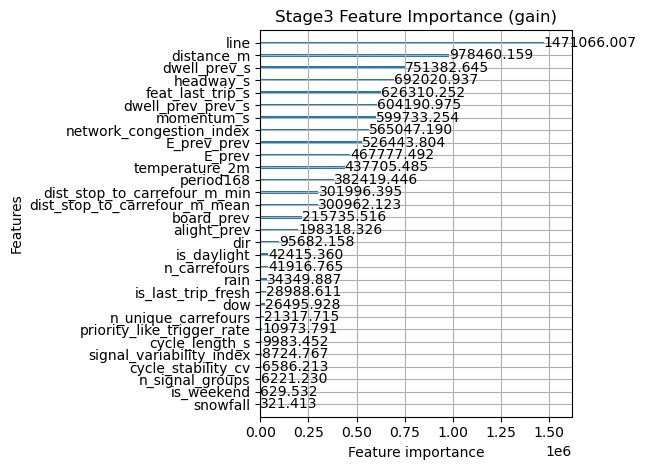

In [63]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb.plot_importance(bst_stage3, importance_type="gain", max_num_features=30)
plt.title("Stage3 Feature Importance (gain)")
plt.tight_layout()
plt.show()

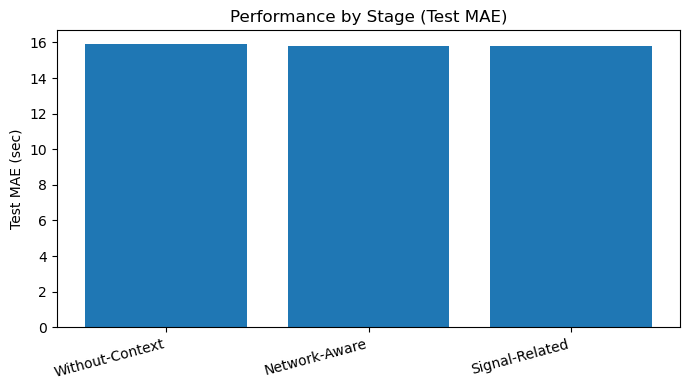

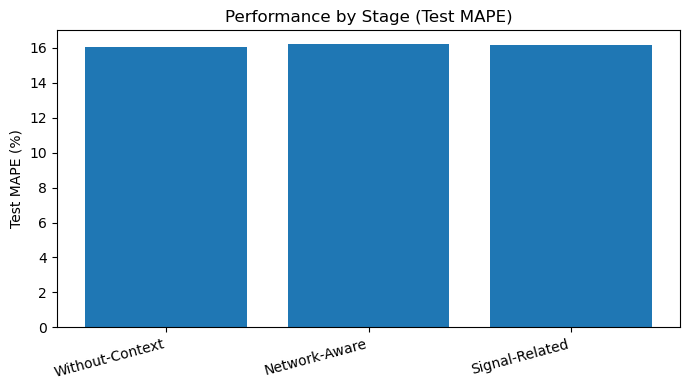

            Baseline     Stage1     Stage2     Stage3
cv_bucket                                            
Low CV     12.103959  11.146333  11.217869  11.213711
Med CV     17.985938  16.528748  16.476637  16.454549
High CV    22.827255  19.894233  19.658304  19.637241


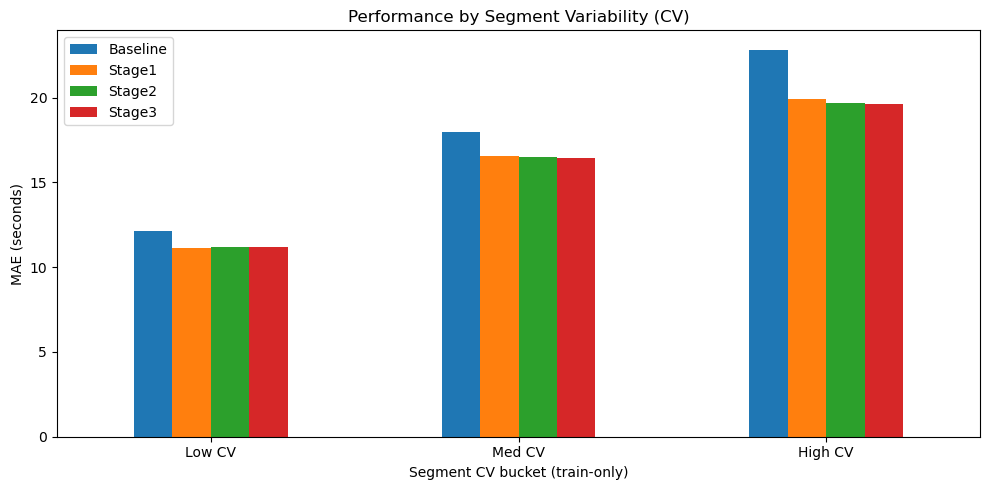

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

EPS = 1e-6

# --- 0) Build Segment CV on TRAIN only (no leakage) ---
train_seg_stats = (
    df_ml.loc[mask_train, ["SegmentKey", "link_s"]]
      .groupby("SegmentKey", observed=True, sort=False)["link_s"]
      .agg(["mean", "std", "count"])
)

train_seg_stats["cv"] = train_seg_stats["std"] / np.maximum(train_seg_stats["mean"], EPS)

# Optional: drop very-low-sample segments to avoid noisy CV
MIN_N = 30
train_seg_stats.loc[train_seg_stats["count"] < MIN_N, "cv"] = np.nan

cv_map = train_seg_stats["cv"].astype("float32")  # index: SegmentKey

# --- 1) Prepare TEST arrays + baseline ---
seg_test = df_ml.loc[mask_test, "SegmentKey"]
y_test   = df_ml.loc[mask_test, "link_s"].to_numpy()
bl_test  = df_ml.loc[mask_test, "bl_median"].to_numpy()

# Map CV to test rows
cv_test = seg_test.map(cv_map).to_numpy()
valid_cv = ~pd.isna(cv_test)

# Baseline prediction
pred_base = bl_test
err_base = np.abs(y_test - pred_base)

# --- 2) Predict each stage on TEST (use multithreading) ---
num_threads = -1

X1 = df_ml.loc[mask_test, stage1_feats + cat_cols]
X2 = df_ml.loc[mask_test, stage2_feats + cat_cols]
X3 = df_ml.loc[mask_test, stage3_feats + cat_cols]

pred1 = bl_test + bst_stage1.predict(X1, num_iteration=bst_stage1.best_iteration, num_threads=num_threads)
pred2 = bl_test + bst_stage2.predict(X2, num_iteration=bst_stage2.best_iteration, num_threads=num_threads)
pred3 = bl_test + bst_stage3.predict(X3, num_iteration=bst_stage3.best_iteration, num_threads=num_threads)

err1 = np.abs(y_test - pred1)
err2 = np.abs(y_test - pred2)
err3 = np.abs(y_test - pred3)

# --- 3) Bucket by CV (choose one: quantile buckets OR fixed bins) ---

# Option A: quantile buckets (balanced counts)
cv_series = pd.Series(cv_test[valid_cv])
bucket = pd.qcut(cv_series, q=3, labels=["Low CV", "Med CV", "High CV"])

# Option B: fixed bins (interpretability)
# bins = [0, 0.1, 0.25, 0.5, 1.0, np.inf]
# labels = ["<0.10", "0.10–0.25", "0.25–0.50", "0.50–1.00", "≥1.00"]
# bucket = pd.cut(cv_series, bins=bins, labels=labels, include_lowest=True)

# Build a small eval frame (only rows with a CV)
eval_df = pd.DataFrame({
    "cv_bucket": bucket.astype("category"),
    "Baseline": err_base[valid_cv],
    "Stage1":   err1[valid_cv],
    "Stage2":   err2[valid_cv],
    "Stage3":   err3[valid_cv],
})

# --- 4) Aggregate MAE by bucket ---
mae_by_bucket = eval_df.groupby("cv_bucket", observed=True).mean()  # mean abs error = MAE
print(mae_by_bucket)

# --- 5) Plot grouped bars ---
ax = mae_by_bucket.plot(kind="bar", figsize=(10, 5), rot=0)
plt.ylabel("MAE (seconds)")
plt.xlabel("Segment CV bucket (train-only)")
plt.title("Performance by Segment Variability (CV)")
plt.tight_layout()
plt.show()

model      Network-Aware  Signal-Related  Without-Context
cv_bucket                                                
Low CV         11.217869       11.213711        11.146333
Med CV         16.476637       16.454549        16.528748
High CV        19.658304       19.637241        19.894233


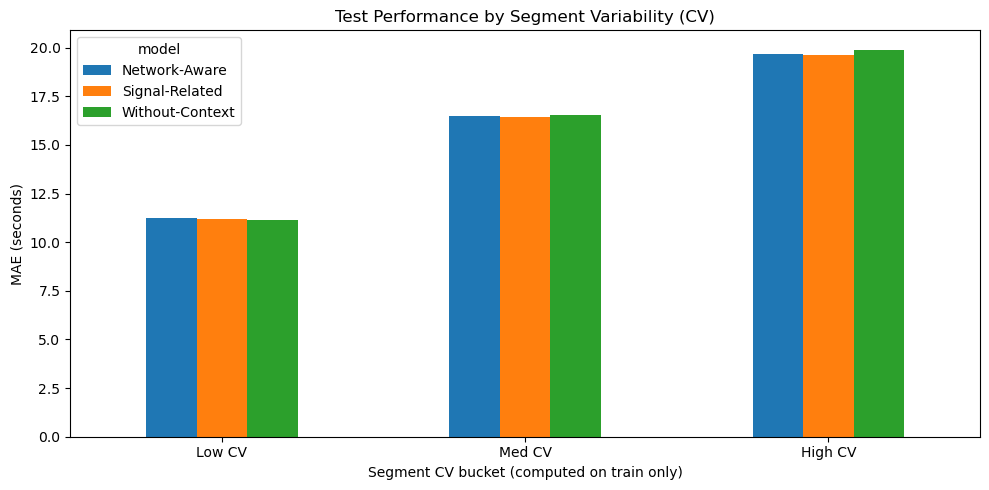

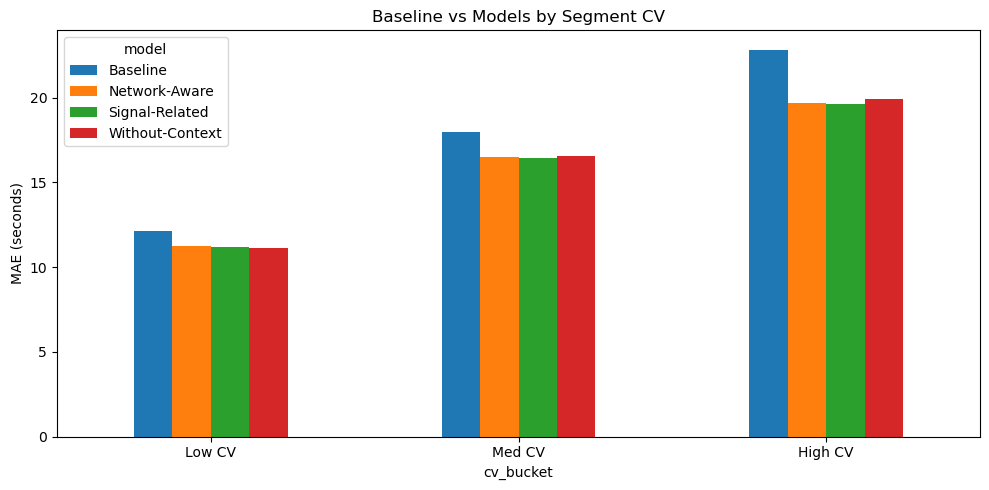

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EPS = 1e-6

# 1) Compute segment CV on TRAIN only (avoid leakage)
train_stats = (
    df_ml.loc[mask_train, ["SegmentKey", "link_s"]]
      .groupby("SegmentKey", observed=True, sort=False)["link_s"]
      .agg(["mean", "std", "count"])
)

train_stats["cv"] = train_stats["std"] / np.maximum(train_stats["mean"], EPS)

# Optional: drop unstable CV estimates
MIN_N = 30
train_stats.loc[train_stats["count"] < MIN_N, "cv"] = np.nan

cv_map = train_stats["cv"].astype("float32")  # index is SegmentKey

# 2) Map CV into pred_all
pred_all["seg_cv"] = pred_all["SegmentKey"].map(cv_map)

# Keep rows where we have a CV estimate
pred_cv = pred_all.dropna(subset=["seg_cv"]).copy()

# 3) Make CV buckets (pick ONE)
# A) Quantile buckets (balanced counts)
pred_cv["cv_bucket"] = pd.qcut(pred_cv["seg_cv"], q=3, labels=["Low CV", "Med CV", "High CV"])

# B) Fixed bins (more interpretable)
# bins = [0, 0.1, 0.25, 0.5, 1.0, np.inf]
# labels = ["<0.10", "0.10–0.25", "0.25–0.50", "0.50–1.00", "≥1.00"]
# pred_cv["cv_bucket"] = pd.cut(pred_cv["seg_cv"], bins=bins, labels=labels, include_lowest=True)

# 4) Compute MAE by (bucket, model)
mae_tbl = (
    pred_cv.groupby(["cv_bucket", "model"], observed=True)["abs_err"]
      .mean()
      .unstack("model")
)

print(mae_tbl)

# 5) Plot
ax = mae_tbl.plot(kind="bar", figsize=(10, 5), rot=0)
plt.ylabel("MAE (seconds)")
plt.xlabel("Segment CV bucket (computed on train only)")
plt.title("Test Performance by Segment Variability (CV)")
plt.tight_layout()
plt.show()

base = pred_all[pred_all["model"] == pred_all["model"].iloc[0]].copy()
base["model"] = "Baseline"
base["abs_err"] = np.abs(base["y_true"] - base["y_base"])
base["seg_cv"] = base["SegmentKey"].map(cv_map)
base = base.dropna(subset=["seg_cv"])
base["cv_bucket"] = pd.qcut(base["seg_cv"], q=3, labels=["Low CV","Med CV","High CV"])

pred_cv_with_base = pd.concat([pred_cv, base], ignore_index=True)
mae_tbl = pred_cv_with_base.groupby(["cv_bucket","model"], observed=True)["abs_err"].mean().unstack("model")
mae_tbl.plot(kind="bar", figsize=(10,5), rot=0)
plt.ylabel("MAE (seconds)")
plt.title("Baseline vs Models by Segment CV")
plt.tight_layout()
plt.show()

In [26]:
import numpy as np
import pandas as pd

# 1) Define coverage on the TEST split (row-level)
sig_cols = ["cycle_length_s","cycle_stability_cv","priority_like_trigger_rate","signal_variability_index"]
mask_sig_row_test = mask_test & df_ml[sig_cols].notna().all(axis=1)   # strict: all 4 present
# mask_sig_row_test = mask_test & df_ml[sig_cols].notna().any(axis=1) # looser: any present

print("Signal-covered test rows:", int(mask_sig_row_test.sum()))

# 2) Build a table of only those rows in pred_all (must match test window)
sig_rows = df_ml.loc[mask_sig_row_test, ["link_start_time","SegmentKey","line","dir"]].copy()
sig_rows["key"] = (
    sig_rows["link_start_time"].astype("datetime64[ns]").astype(str) + "|" +
    sig_rows["SegmentKey"].astype(str) + "|" +
    sig_rows["line"].astype(str) + "|" +
    sig_rows["dir"].astype(str)
)

pa = pred_all.copy()
pa["key"] = (
    pa["link_start_time"].astype("datetime64[ns]").astype(str) + "|" +
    pa["SegmentKey"].astype(str) + "|" +
    pa["line"].astype(str) + "|" +
    pa["dir"].astype(str)
)

pa_sig = pa[pa["key"].isin(set(sig_rows["key"]))].copy()

# 3) Compare Stage2 vs Stage3 on these rows
comp = (
    pa_sig[pa_sig["model"].isin(["Network-Aware","Signal-Related"])]
      .groupby("model", observed=True)["abs_err"]
      .agg(["count","mean","median"])
      .rename(columns={"mean":"MAE_sec","median":"MedAE_sec"})
)



# Keep only the two models we compare
tmp = pa_sig[pa_sig["model"].isin(["Network-Aware", "Signal-Related"])][
    ["key", "model", "abs_err"]
].copy()

# pivot_table will aggregate duplicates (mean abs_err for same key+model)
wide = tmp.pivot_table(index="key", columns="model", values="abs_err", aggfunc="mean")

# paired improvement (positive = Signal-Related better)
delta = wide["Network-Aware"] - wide["Signal-Related"]

print("Paired keys:", wide.dropna().shape[0])
print("Mean improvement (sec):", float(delta.mean()))
print("Median improvement (sec):", float(delta.median()))
print("% keys improved:", float((delta > 0).mean()))

Signal-covered test rows: 7416
Paired keys: 7414
Mean improvement (sec): 0.03557231895286075
Median improvement (sec): -0.029142830528819275
% keys improved: 0.4940652818991098


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_30513/1709485820.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, line), g in p.groupby(["model", "line"], sort=False):


Overall mean MAPE by model (%):
model
Without-Context    16.052515
Signal-Related     16.167032
Network-Aware      16.195347
Name: mape_pct, dtype: float64

Best model: Without-Context

Top 10 BEST lines (lowest MAPE):
   line  n_used  mape_mean     ci_low    ci_high
50   73       7  10.169596   3.574768  17.954970
43   14   45180  11.406265  11.271603  11.537447
64   75     516  11.963903  10.955629  13.040469
10   17   33912  12.189703  12.025947  12.363393
11   12   44834  12.243360  11.882260  12.734871
9    15   28305  12.865347  12.597707  13.168678
42   18   11659  13.382372  13.045403  13.773173
16   55   13318  13.621541  13.302541  13.922501
59   21    9290  13.766627  13.465356  14.073817
18   54    9093  13.990529  13.698740  14.293681

Top 10 WORST lines (highest MAPE):
   line  n_used  mape_mean     ci_low    ci_high
54   34     324  26.472341  20.967419  35.993294
6    51    2760  23.544890  21.606478  25.461699
44   83    3659  23.527121  21.487089  26.144309
41   91   

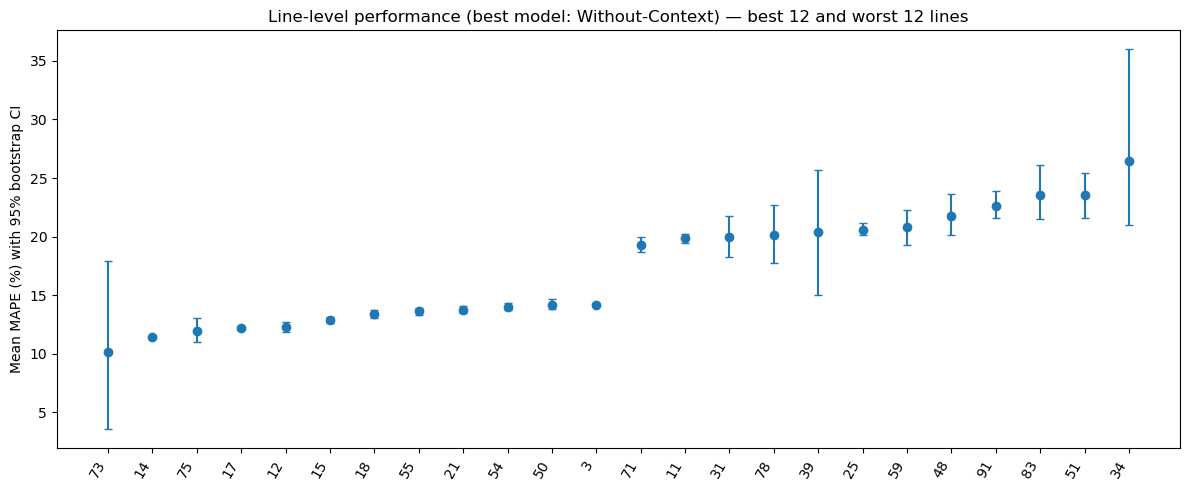

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- settings ---
BOOT = 300          # bootstrap repetitions (200–500 is usually enough)
MAX_N_PER_LINE = 80_000  # cap rows per (model,line) for speed
RNG_SEED = 42

# --- minimal frame ---
p = pred_all[["model", "line", "pct_err"]].copy()
p = p.dropna(subset=["model", "line", "pct_err"])
p["mape_pct"] = p["pct_err"].astype("float32") * 100.0

# Optional: drop insane outliers if they mess up readability (comment out if you want raw)
# p = p[p["mape_pct"] <= 500]

# --- helper: bootstrap CI for mean ---
rng = np.random.default_rng(RNG_SEED)

def boot_ci_mean(x: np.ndarray, B=BOOT):
    x = x.astype(np.float64, copy=False)
    n = x.size
    if n == 0:
        return np.nan, np.nan, np.nan
    mu = float(x.mean())
    # bootstrap means
    idx = rng.integers(0, n, size=(B, n), endpoint=False)
    means = x[idx].mean(axis=1)
    lo, hi = np.percentile(means, [2.5, 97.5])
    return mu, float(lo), float(hi)

# --- aggregate per (model,line) ---
rows = []
for (model, line), g in p.groupby(["model", "line"], sort=False):
    x = g["mape_pct"].to_numpy()
    if x.size > MAX_N_PER_LINE:
        # subsample without replacement for speed
        x = rng.choice(x, size=MAX_N_PER_LINE, replace=False)

    mu, lo, hi = boot_ci_mean(x)
    rows.append({
        "model": model,
        "line": str(line),
        "n_used": int(x.size),
        "mape_mean": mu,
        "ci_low": lo,
        "ci_high": hi,
    })

line_perf = pd.DataFrame(rows)

# --- pick the best model overall (lowest mean MAPE across all lines/rows in pred_all) ---
overall = p.groupby("model")["mape_pct"].mean().sort_values()
best_model = overall.index[0]
print("Overall mean MAPE by model (%):")
print(overall)
print("\nBest model:", best_model)

best = line_perf[line_perf["model"] == best_model].dropna(subset=["mape_mean"]).copy()
best = best.sort_values("mape_mean")

print("\nTop 10 BEST lines (lowest MAPE):")
print(best.head(10)[["line","n_used","mape_mean","ci_low","ci_high"]])

print("\nTop 10 WORST lines (highest MAPE):")
print(best.tail(10).sort_values("mape_mean", ascending=False)[["line","n_used","mape_mean","ci_low","ci_high"]])

# --- plot: top/bottom lines with CI error bars ---
top_k = 12
plot_df = pd.concat([best.head(top_k), best.tail(top_k)], ignore_index=True)
plot_df["err_low"] = plot_df["mape_mean"] - plot_df["ci_low"]
plot_df["err_high"] = plot_df["ci_high"] - plot_df["mape_mean"]
plot_df["label"] = plot_df["line"].astype(str)

plt.figure(figsize=(12, 5))
plt.errorbar(
    x=np.arange(len(plot_df)),
    y=plot_df["mape_mean"],
    yerr=[plot_df["err_low"], plot_df["err_high"]],
    fmt="o",
    capsize=3,
)
plt.xticks(np.arange(len(plot_df)), plot_df["label"], rotation=60, ha="right")
plt.ylabel("Mean MAPE (%) with 95% bootstrap CI")
plt.title(f"Line-level performance (best model: {best_model}) — best {top_k} and worst {top_k} lines")
plt.tight_layout()
plt.show()

In [31]:
pred_all.head()

,link_start_time,SegmentKey,line,dir,y_true,y_base,y_pred,residual,abs_err,pct_err,model,seg_cv
0,2025-11-25 00:05:16,31DC00→PLEV00,9,A,115.0,130.0,130.933742,-15.933742,15.933742,0.138554,Without-Context,0.283742
1,2025-11-25 00:34:40,31DC00→PLEV00,9,A,173.0,130.0,122.290185,50.709815,50.709815,0.293120,Without-Context,0.283742
2,2025-11-25 05:08:06,31DC00→PLEV00,9,A,156.0,177.0,183.832952,-27.832952,27.832952,0.178416,Without-Context,0.283742
3,2025-11-25 05:41:25,31DC00→PLEV00,9,A,187.0,177.0,180.318982,6.681018,6.681018,0.035727,Without-Context,0.283742
4,2025-11-25 05:57:05,31DC00→PLEV00,<NA>,R,209.0,177.0,174.195645,34.804355,34.804355,0.166528,Without-Context,0.283742


In [33]:
import pandas as pd
import numpy as np

# --- load stops ---
stops = pd.read_csv("../data/stops_df.csv")
stops["MNLP"] = stops["MNLP"].astype(str).str.strip()
stops["X"] = pd.to_numeric(stops["X"], errors="coerce")
stops["Y"] = pd.to_numeric(stops["Y"], errors="coerce")
stops = stops.dropna(subset=["MNLP","X","Y"]).drop_duplicates("MNLP")

# --- choose which model to map ---
MODEL = "Signal-Related"  # or "Network-Aware" etc.
p = pred_all.loc[pred_all["model"] == MODEL, ["line","SegmentKey","pct_err"]].copy()
p = p.dropna(subset=["line","SegmentKey","pct_err"])

p["mape_pct"] = p["pct_err"].astype("float32") * 100.0

# segment-level perf table
seg_perf = (
    p.groupby(["line","SegmentKey"], observed=True, sort=False)
     .agg(n=("mape_pct","size"), mape_mean=("mape_pct","mean"))
     .reset_index()
)

# share within each line
seg_perf["line_total_n"] = seg_perf.groupby("line", observed=True)["n"].transform("sum")
seg_perf["share"] = seg_perf["n"] / seg_perf["line_total_n"]


COVERAGE = 1  # 25% of trips per line

seg_perf = seg_perf.sort_values(["line","share"], ascending=[True, False])
seg_perf["cum_share"] = seg_perf.groupby("line", observed=True)["share"].cumsum()

keep = seg_perf[seg_perf["cum_share"] <= COVERAGE].copy()

print("Kept segments:", len(keep))
print("Kept lines:", keep["line"].nunique())

In [49]:
from shapely.geometry import LineString
import geopandas as gpd

# split SegmentKey to stop codes
keep[["from_stop","to_stop"]] = keep["SegmentKey"].str.split("→", expand=True)
keep["from_stop"] = keep["from_stop"].astype(str).str.strip()
keep["to_stop"]   = keep["to_stop"].astype(str).str.strip()

# attach coords
st_xy = stops.set_index("MNLP")[["X","Y"]]

keep["x1"] = keep["from_stop"].map(st_xy["X"])
keep["y1"] = keep["from_stop"].map(st_xy["Y"])
keep["x2"] = keep["to_stop"].map(st_xy["X"])
keep["y2"] = keep["to_stop"].map(st_xy["Y"])

keep = keep.dropna(subset=["x1","y1","x2","y2"])

# build lines
keep["geometry"] = [
    LineString([(x1,y1),(x2,y2)])
    for x1,y1,x2,y2 in zip(keep["x1"],keep["y1"],keep["x2"],keep["y2"])
]

gseg = gpd.GeoDataFrame(keep, geometry="geometry", crs="EPSG:21781")
print(gseg.shape)

(3219, 14)


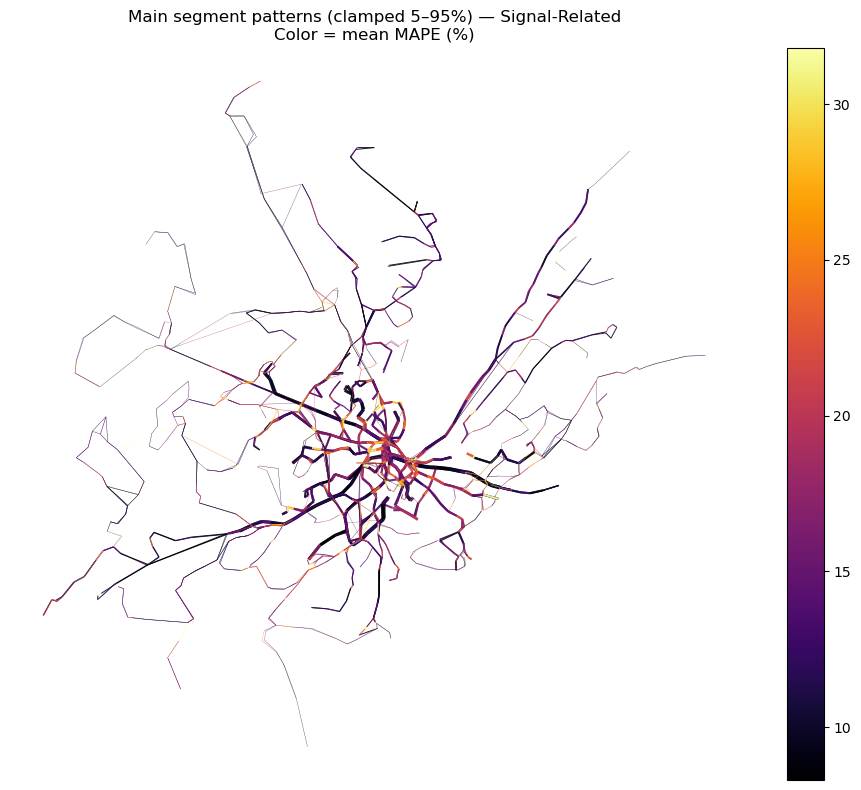

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

vmin = np.nanpercentile(gseg["mape_mean"], 5)
vmax = np.nanpercentile(gseg["mape_mean"], 95)

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # linear, but clamped

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gseg.plot(
    ax=ax,
    column="mape_mean",
    linewidth=gseg["lw"],
    cmap="inferno",          # try: "plasma", "magma", "viridis", "turbo"
    norm=norm,
    legend=True,
    alpha=0.9
)
ax.set_title(f"Main segment patterns (clamped 5–95%) — {MODEL}\nColor = mean MAPE (%)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

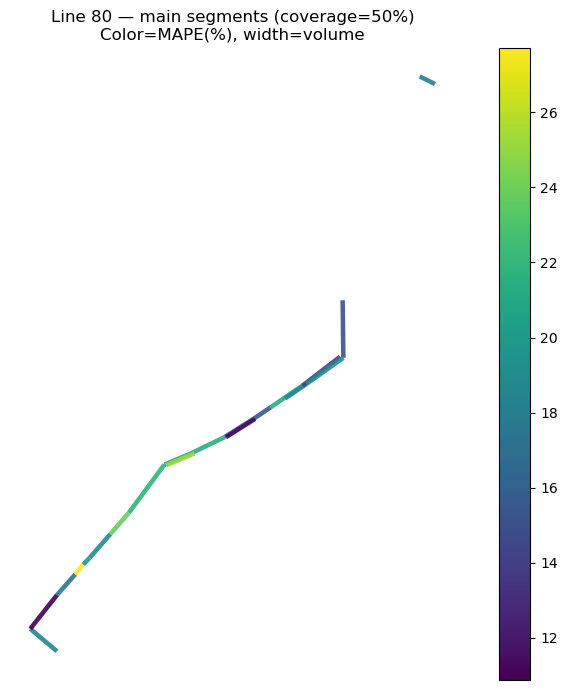

In [47]:
def plot_line(line_id, top_k=None):
    sub = gseg[gseg["line"].astype(str) == str(line_id)].copy()
    if sub.empty:
        print("No data for line", line_id); return
    if top_k is not None:
        sub = sub.sort_values("n", ascending=False).head(top_k)

    sub["lw"] = 0.3 + 3.0 * (sub["n"] / sub["n"].max())

    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    sub.plot(ax=ax, column="mape_mean", linewidth=sub["lw"], legend=True, alpha=0.9)
    ax.set_title(f"Line {line_id} — main segments (coverage={COVERAGE:.0%})\nColor=MAPE(%), width=volume")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# example
plot_line("80")   # change to a real line id in your data

In [ ]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import pandas as pd

# ==============================================================================
# BLOCK 3: LightGBM Model Training
# ==============================================================================
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Prepare Categories
cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

cat_cols_reduced = cat_cols.copy()

# ### --- NEW FEATURE SET DEFINITIONS --- ###

# "Normal" Model: Knows static/cyclic data + its *own* 1-hop & 2-hop history
features_reduced = [
    "distance_m",
    "period168", "dow", "is_weekend",
    "E_prev", "dwell_prev_s",
    "board_prev", "alight_prev", # 1-hop trip info
    "E_prev_prev", "dwell_prev_prev_s", "momentum_s" # 2-hop trip info
]

# "Hero" Model: Knows everything Normal knows + *external* network context
features_full = features_reduced + [
    "headway_s",
    "network_congestion_index",
    "feat_last_trip_s",
    "is_last_trip_fresh",
    # --- NEW FEATURES TO ADD ---
    "temperature_2m",
    "rain",
    "snowfall",
    "is_daylight"
    # --- END NEW FEATURES ---
]

# Define stage feature sets
signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]

stage1_feats = features_reduced  # without context
stage2_feats = features_full     # network-aware
stage3_feats = features_full + signal_static_feat_cols  # add signal

# Recompute masks after all merges/feature adds
df_ml = df_ml.reset_index(drop=True)
mask_train = df_ml["link_start_time"] <= TRAIN_END_DATE
mask_test  = (df_ml["link_start_time"] > TRAIN_END_DATE) & (df_ml["link_start_time"] <= TEST_END_DATE)

# Ensure categorical dtypes after merges
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

params = {
    "objective": "regression_l1", "metric": "mae",
    "boosting_type": "gbdt", "num_leaves": 800,"min_data_in_leaf": 200,
    "max_depth": -1,
    "learning_rate": 0.1, "feature_fraction": 0.8, "verbose": -1
}

def train_model(feats):
    X = df_ml.loc[:, feats + cat_cols]
    y = df_ml["target_residual"]

    dtrain = lgb.Dataset(
        X.loc[mask_fit], label=y.loc[mask_fit],
        categorical_feature=cat_cols
    )
    dvalid = lgb.Dataset(
        X.loc[mask_val], label=y.loc[mask_val],
        categorical_feature=cat_cols, reference=dtrain
    )

    bst = lgb.train(
        params, dtrain,
        num_boost_round=3000,
        valid_sets=[dvalid],  # <-- validation only
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
    )
    return bst

def mae_total(bst, feats, mask):
    X = df_ml.loc[mask, feats + cat_cols]
    preds = bst.predict(X, num_iteration=bst.best_iteration)
    pred_total = df_ml.loc[mask, "bl_median"] + preds
    return mean_absolute_error(df_ml.loc[mask, "link_s"], pred_total)

# Train three models
bst_stage1 = train_model(stage1_feats)
bst_stage2 = train_model(stage2_feats)
bst_stage3 = train_model(stage3_feats)

# Evaluate on full test set
results = []
for name, feats, bst in [
    ("Without-Context", stage1_feats, bst_stage1),
    ("Network-Aware", stage2_feats, bst_stage2),
    ("Signal-Related", stage3_feats, bst_stage3),
]:
    mae = mae_total(bst, feats, mask_test)
    results.append({"Model": name, "Test_MAE_sec": mae})

results_df = pd.DataFrame(results).sort_values("Test_MAE_sec")
print(results_df)

# Optional: evaluate only on signal-covered test rows
mask_sig = df_ml[signal_static_feat_cols].notna().any(axis=1)
mask_sig_test = mask_test & mask_sig
if mask_sig_test.any():
    sig_results = []
    for name, feats, bst in [
        ("Without-Context", stage1_feats, bst_stage1),
        ("Network-Aware", stage2_feats, bst_stage2),
        ("Signal-Related", stage3_feats, bst_stage3),
    ]:
        mae = mae_total(bst, feats, mask_sig_test)
        sig_results.append({"Model": name, "SigRows_Test_MAE_sec": mae})
    print("\nSignal-covered test rows only:")
    print(pd.DataFrame(sig_results).sort_values("SigRows_Test_MAE_sec"))
else:
    print("\nNo signal-covered rows in test split; skipped subset eval.")

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 13.3528	valid_1's l1: 15.5271
[400]	training's l1: 13.1163	valid_1's l1: 15.4513
[600]	training's l1: 12.9794	valid_1's l1: 15.4229
[800]	training's l1: 12.873	valid_1's l1: 15.4095
[1000]	training's l1: 12.7938	valid_1's l1: 15.4008
[1200]	training's l1: 12.7105	valid_1's l1: 15.3923
[1400]	training's l1: 12.6463	valid_1's l1: 15.3863
[1600]	training's l1: 12.585	valid_1's l1: 15.3811
[1800]	training's l1: 12.5264	valid_1's l1: 15.3782
[2000]	training's l1: 12.4764	valid_1's l1: 15.3754
[2200]	training's l1: 12.4354	valid_1's l1: 15.3716
[2400]	training's l1: 12.3934	valid_1's l1: 15.369
[2600]	training's l1: 12.3368	valid_1's l1: 15.3657
[2800]	training's l1: 12.3031	valid_1's l1: 15.3634
[3000]	training's l1: 12.2722	valid_1's l1: 15.3622
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 12.2722	valid_1's l1: 15.3622
Training until validation scores don't improve for 100 rounds
[20

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_43156/4152764765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[c] = df_ml[c].astype("category")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_43156/4152764765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[c] = df_ml[c].astype("category")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_43156/4152764765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Creating masks...
Full Model Train shape: (3863565, 22)
Full Model Test shape:  (1145181, 22)
Training FULL 'Hero' LightGBM...
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 13.4572	valid_1's l1: 15.4888
[200]	training's l1: 13.0821	valid_1's l1: 15.2712
[300]	training's l1: 12.8867	valid_1's l1: 15.1879
[400]	training's l1: 12.7648	valid_1's l1: 15.1516
[500]	training's l1: 12.6731	valid_1's l1: 15.1319
[600]	training's l1: 12.6037	valid_1's l1: 15.1198
[700]	training's l1: 12.5489	valid_1's l1: 15.1094
[800]	training's l1: 12.4847	valid_1's l1: 15.097
[900]	training's l1: 12.432	valid_1's l1: 15.0905
[1000]	training's l1: 12.3763	valid_1's l1: 15.0819
[1100]	training's l1: 12.3271	valid_1's l1: 15.0744
[1200]	training's l1: 12.2695	valid_1's l1: 15.0656
[1300]	training's l1: 12.2244	valid_1's l1: 15.0611
[1400]	training's l1: 12.1891	valid_1's l1: 15.0572
[1500]	training's l1: 12.1528	valid_1's l1: 15.0542
[1600]	training's l1: 12.1173	valid_1's l1

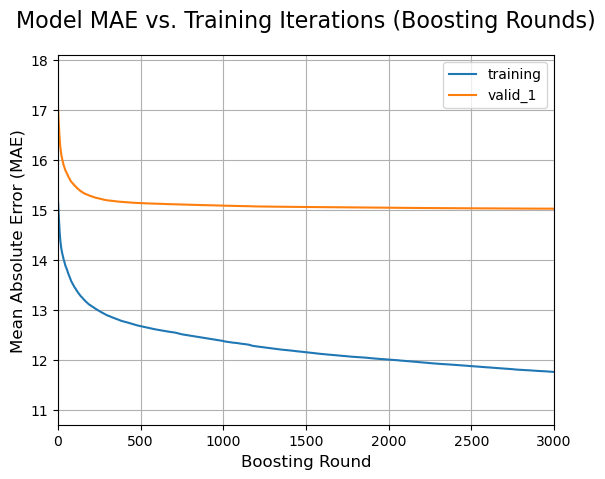

In [ ]:
# ==============================================================================
# BLOCK 3: LightGBM Model Training
# ==============================================================================
import lightgbm as lgb
import gc
from sklearn.metrics import mean_absolute_error

# 1. Prepare Categories
cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

cat_cols_reduced = cat_cols.copy()

# ### --- NEW FEATURE SET DEFINITIONS --- ###

# "Normal" Model: Knows static/cyclic data + its *own* 1-hop & 2-hop history
features_reduced = [
    "distance_m",
    "period168", "dow", "is_weekend",
    "E_prev", "dwell_prev_s",
    "board_prev", "alight_prev", # 1-hop trip info
    "E_prev_prev", "dwell_prev_prev_s", "momentum_s" # 2-hop trip info
]

# "Hero" Model: Knows everything Normal knows + *external* network context
features_full = features_reduced + [
    "headway_s",
    "network_congestion_index",
    "feat_last_trip_s",
    "is_last_trip_fresh",
    # --- NEW FEATURES TO ADD ---
    "temperature_2m",
    "rain",
    "snowfall",
    "is_daylight"
    # --- END NEW FEATURES ---
]

# 2. Define Masks (on df_ml)
print("Creating masks...")
mask_train = df_ml["link_start_time"] <= TRAIN_END_DATE
mask_test  = (df_ml["link_start_time"] > TRAIN_END_DATE) & (df_ml["link_start_time"] <= TEST_END_DATE)

# 3. Create Feature Matrix (X) and Target (y)
#    We use the FULL feature set for our main model
X = df_ml[features_full + cat_cols]
y = df_ml["target_residual"]

# 4. Apply Masks
X_train = X[mask_train]
y_train = y[mask_train]
X_test  = X[mask_test]
y_test  = y[mask_test]

print(f"Full Model Train shape: {X_train.shape}")
print(f"Full Model Test shape:  {X_test.shape}")

# 5. Create LGBM Datasets
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
dtest  = lgb.Dataset(X_test,  label=y_test,  categorical_feature=cat_cols, reference=dtrain)

# 6. Train FULL Model
params = {
    "objective": "regression_l1", "metric": "mae",
    "boosting_type": "gbdt", "num_leaves": 800,"min_data_in_leaf": 200,
    "max_depth": -1,
    "learning_rate": 0.1, "feature_fraction": 0.8, "verbose": -1
}
evals_result = {}  # Create a dictionary to store the results
print("Training FULL 'Hero' LightGBM...")
bst = lgb.train(
    params,
    dtrain,
    num_boost_round=3000, 
    valid_sets=[dtrain, dtest],
    callbacks=[
        lgb.early_stopping(100), 
        lgb.log_evaluation(100),
        # --- THIS IS THE NEW CALLBACK ---
        lgb.record_evaluation(evals_result) 
        # --- END NEW CALLBACK ---
    ]
)
# ==============================================================================
# BLOCK: Plotting Metric (Loss) Curve (Corrected)
# ==============================================================================
import matplotlib.pyplot as plt

print("Plotting training and validation metrics...")

# --- THIS IS THE CHANGE ---
# Remove the metric='mae' argument. 
# The function will find it inside the dictionary.
ax = lgb.plot_metric(evals_result)
# --- END CHANGE ---

plt.title('Model MAE vs. Training Iterations (Boosting Rounds)', fontsize=16, pad=20)
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.show()

In [51]:
gc.collect()

2607

--- RESULTS (Test Set) ---
Baseline MAE: 17.14 seconds
Full Model MAE: 15.02 seconds
Improvement:  12.35% reduction in error
Baseline MAPE: 17.81%
Model MAPE:    15.75%


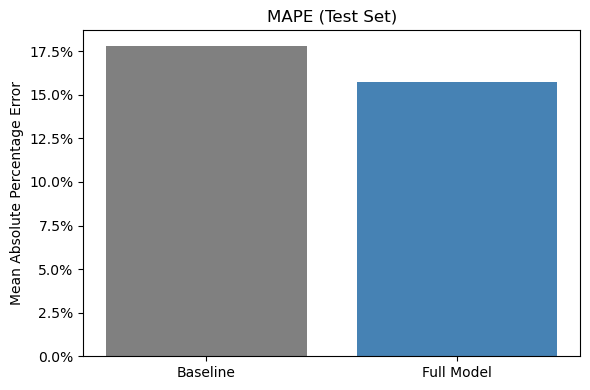


--- Key Drivers of Variance (Full Model) ---
                     Feature    Importance
19                SegmentKey  6.200417e+06
20                      line  1.395765e+06
11                 headway_s  1.249281e+06
12  network_congestion_index  1.170884e+06
5               dwell_prev_s  1.027753e+06
8                E_prev_prev  9.999804e+05
4                     E_prev  9.841683e+05
10                momentum_s  9.038256e+05
1                  period168  8.887839e+05
9          dwell_prev_prev_s  8.683078e+05


In [50]:
# ==============================================================================
# BLOCK 4 & 6: Evaluation & "Hero Feature" Plot
# ==============================================================================

# 1. Generate Predictions from FULL model
pred_residual = bst.predict(X_test, num_iteration=bst.best_iteration)
df_eval = df_ml[mask_test].copy()
df_eval["pred_total"]    = df_eval["bl_median"] + pred_residual
df_eval["actual_total"]  = df_eval["link_s"]
df_eval["err_baseline"] = (df_eval["actual_total"] - df_eval["bl_median"]).abs()
df_eval["err_model"]    = (df_eval["actual_total"] - df_eval["pred_total"]).abs()

# 2. Metrics for FULL model
mae_baseline = df_eval["err_baseline"].mean()
mae_model    = df_eval["err_model"].mean()
print(f"--- RESULTS (Test Set) ---")
# --- RESULTS (Test Set) ---
print(f"Baseline MAE: {mae_baseline:.2f} seconds")
print(f"Full Model MAE: {mae_model:.2f} seconds")
print(f"Improvement:  {1 - (mae_model/mae_baseline):.2%} reduction in error")

df_eval["baseline_mape"] = (
    df_eval["err_baseline"] / df_eval["actual_total"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

df_eval["model_mape"] = (
    df_eval["err_model"] / df_eval["actual_total"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"Baseline MAPE: {df_eval['baseline_mape'].mean():.2%}")
print(f"Model MAPE:    {df_eval['model_mape'].mean():.2%}")

plt.figure(figsize=(6,4))
plt.bar(["Baseline","Full Model"], [
    df_eval["baseline_mape"].mean(),
    df_eval["model_mape"].mean()
], color=["gray","steelblue"])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.1%}"))
plt.ylabel("Mean Absolute Percentage Error")
plt.title("MAPE (Test Set)")
plt.tight_layout()
plt.show()

# 3. Feature Importance for FULL model
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": bst.feature_importance(importance_type="gain")
}).sort_values(by="Importance", ascending=False)
print("\n--- Key Drivers of Variance (Full Model) ---")
print(importance.head(10))



Training REDUCED 'Normal' Model (for comparison)...
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1662]	valid_0's l1: 15.3799


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_43156/2411934560.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")


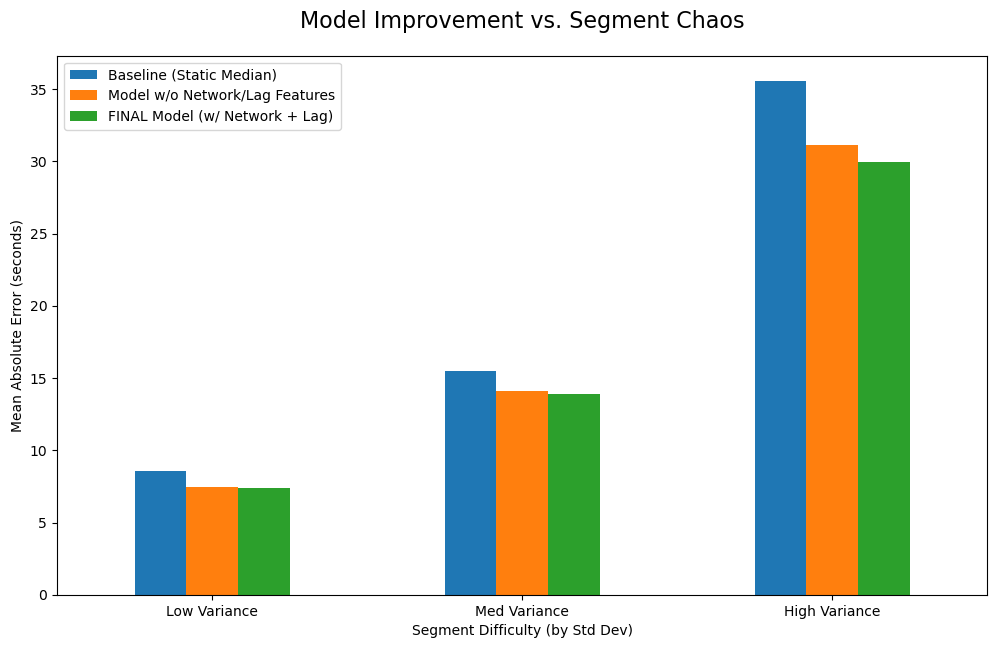

In [55]:
# --- 4. Train the "Reduced" Model (for comparison) ---
print("\nTraining REDUCED 'Normal' Model (for comparison)...")
X_train_reduced = X_train[features_reduced + cat_cols_reduced]
X_test_reduced = X_test[features_reduced + cat_cols_reduced]
dtrain_reduced = lgb.Dataset(X_train_reduced, label=y_train, categorical_feature=cat_cols_reduced)
bst_reduced = lgb.train(
    params, dtrain_reduced,
    num_boost_round=3000, # Faster training
    valid_sets=[lgb.Dataset(X_test_reduced, label=y_test)],
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
)

# 5. Get predictions from the Reduced Model
pred_residual_reduced = bst_reduced.predict(X_test_reduced)
df_eval["pred_reduced_total"] = df_eval["bl_median"] + pred_residual_reduced
df_eval["err_reduced_model"] = (df_eval["actual_total"] - df_eval["pred_reduced_total"]).abs()

# --- 6. Join Variance Data ---
segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")
df_eval_plot = df_eval.join(segment_variance, on="SegmentKey")
bins = [0, 15, 45, 9999]
labels = ["Low Variance", "Med Variance", "High Variance"]
df_eval_plot["variance_bucket"] = pd.cut(df_eval_plot["segment_sigma"], bins=bins, labels=labels)

# --- 7. Plot the "Hero" Bar Chart (Absolute) ---
df_comparison = df_eval_plot.groupby("variance_bucket", as_index=False, observed=True).agg(
    Baseline_MAE=("err_baseline", "mean"),
    Reduced_Model_MAE=("err_reduced_model", "mean"),
    Full_Model_MAE=("err_model", "mean")
)
df_comparison.plot(x="variance_bucket", kind="bar", figsize=(12, 7), rot=0)
plt.ylabel("Mean Absolute Error (seconds)")
plt.xlabel("Segment Difficulty (by Std Dev)")
plt.title("Model Improvement vs. Segment Chaos", fontsize=16, pad=20)
plt.legend([
    "Baseline (Static Median)",
    "Model w/o Network/Lag Features",
    "FINAL Model (w/ Network + Lag)"
])
plt.show()

In [103]:
required = ["carrefour_id","groupe_de_feux","dist_stop_to_carrefour_m","distance_m","bl_median","link_start_time"]
missing = [c for c in required if c not in df_ml.columns]
print("Missing:", missing)
print("Has carrefour_id?", "carrefour_id" in df_ml.columns)

Missing: ['dist_stop_to_carrefour_m']
Has carrefour_id? True


In [104]:
carrefour_df = pd.read_csv("../data/all_carrefour_merged.csv")
carrefour_df.columns = carrefour_df.columns.str.strip()

def norm_line(x):
    x = str(x).strip()
    try: return str(int(float(x)))
    except: return x

carrefour_df["carrefour_id"]  = pd.to_numeric(carrefour_df["numero_carrefour"], errors="coerce")
carrefour_df["stop_left"]     = carrefour_df["stop_left"].astype(str).str.strip()
carrefour_df["stop_right"]    = carrefour_df["stop_right"].astype(str).str.strip()
carrefour_df["groupe_de_feux"]= carrefour_df["groupe_de_feux"].astype(str).str.strip()
carrefour_df["line"]          = carrefour_df["ligne"].apply(norm_line)
carrefour_df["SegmentKey"]    = carrefour_df["stop_left"] + "→" + carrefour_df["stop_right"]
carrefour_df["dist_stop_to_carrefour_m"] = pd.to_numeric(carrefour_df["feux_mesures"], errors="coerce")

carrefour_map = (
    carrefour_df.loc[carrefour_df["carrefour_id"].notna() & carrefour_df["groupe_de_feux"].notna()]
    [["SegmentKey","line","carrefour_id","groupe_de_feux","dist_stop_to_carrefour_m"]]
    .drop_duplicates(subset=["SegmentKey","line"], keep="first")
)

df_ml = df_ml.copy()
df_ml["line"] = df_ml["line"].apply(norm_line)
for col in ["carrefour_id","groupe_de_feux","carrefour_id_x","carrefour_id_y","groupe_de_feux_x","groupe_de_feux_y","carrefour_id_seg","groupe_de_feux_seg"]:
    if col in df_ml.columns:
        df_ml.drop(columns=col, inplace=True)

df_ml = df_ml.merge(carrefour_map, on=["SegmentKey","line"], how="left")
print("Rows with mapped carrefour:", df_ml["carrefour_id"].notna().mean())
print("Unique carrefours mapped:", df_ml["carrefour_id"].nunique(dropna=True))

Rows with mapped carrefour: 0.4443208585185126
Unique carrefours mapped: 348


In [108]:
from pathlib import Path
import numpy as np
import pandas as pd

SIG_ROOT = Path("../data/signal_parquet_db")

# Static-only signal features (no time alignment)
signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]

df_ml = df_ml.copy()
df_ml.drop(columns=["signal_state", "time_to_next_green_s"], inplace=True, errors="ignore")

for c in signal_static_feat_cols:
    if c not in df_ml.columns:
        df_ml[c] = np.nan

mask_sig = df_ml["carrefour_id"].notna() & df_ml["groupe_de_feux"].notna()
rows = df_ml.loc[mask_sig, ["carrefour_id", "groupe_de_feux"]].copy()

print(f"Rows with carrefour+groupe_de_feux: {mask_sig.mean():.2%} ({mask_sig.sum():,})")
print(f"Unique carrefours in df_ml: {df_ml['carrefour_id'].nunique(dropna=True)}")

for cid, sub_cid in rows.groupby("carrefour_id", sort=False):
    path = SIG_ROOT / f"signal_{int(cid)}.parquet"
    if not path.exists():
        continue

    sig = pd.read_parquet(path)
    sig.index = pd.to_datetime(sig.index, errors="coerce")
    sig = sig[~sig.index.isna()].sort_index()
    sig = sig[~sig.index.duplicated(keep="last")]

    for gf, idx in sub_cid.groupby("groupe_de_feux", sort=False).groups.items():
        if gf not in sig.columns:
            continue

        s = pd.to_numeric(sig[gf], errors="coerce").ffill().dropna()
        if s.empty:
            continue

        s_int = s.astype("int8")  # RED=1, GREEN=0

        # green-start events (RED->GREEN is 1->0, diff = -1)
        d = s_int.diff()
        green_starts = s_int.index[d == -1].values.astype("datetime64[ns]")

        # cycle stats
        if len(green_starts) >= 2:
            cyc = np.diff(green_starts).astype("timedelta64[s]").astype("float64")
            cyc = cyc[cyc > 0]
        else:
            cyc = np.array([], dtype="float64")

        if len(cyc) >= 3:
            cycle_length_s = float(np.nanmedian(cyc))
            cycle_stability_cv = float(np.nanstd(cyc) / max(np.nanmean(cyc), 1e-6))
            signal_variability_index = float(
                (np.nanpercentile(cyc, 75) - np.nanpercentile(cyc, 25)) / max(np.nanmedian(cyc), 1e-6)
            )
        elif len(cyc) > 0:
            cycle_length_s = float(np.nanmedian(cyc))
            cycle_stability_cv = float(np.nan)
            signal_variability_index = float(np.nan)
        else:
            cycle_length_s = float(np.nan)
            cycle_stability_cv = float(np.nan)
            signal_variability_index = float(np.nan)

        # priority-like trigger proxy
        change_mask = s_int.diff().fillna(0).ne(0)
        change_times = s_int.index[change_mask].to_list()
        if len(change_times) == 0:
            priority_like_trigger_rate = float(np.nan)
        else:
            bounds = [s_int.index[0]] + change_times + [s_int.index[-1]]
            vals = [int(s_int.iloc[0])] + [int(s_int.loc[t]) for t in change_times]

            durations, states = [], []
            for i in range(len(vals)):
                start = bounds[i]
                end = bounds[i + 1]
                dur_s = (end - start) / np.timedelta64(1, "s")
                if dur_s > 0:
                    durations.append(float(dur_s))
                    states.append(vals[i])

            durations = np.array(durations, dtype="float64")
            states = np.array(states, dtype="int8")

            green_d = durations[states == 0]
            red_d = durations[states == 1]

            if len(green_d) >= 10 or len(red_d) >= 10:
                g_thr = np.nanpercentile(green_d, 90) if len(green_d) else np.nan
                r_thr = np.nanpercentile(red_d, 10) if len(red_d) else np.nan
                flags = []
                if len(green_d):
                    flags.append((green_d > g_thr).mean())
                if len(red_d):
                    flags.append((red_d < r_thr).mean())
                priority_like_trigger_rate = float(np.nanmean(flags)) if flags else float(np.nan)
            else:
                priority_like_trigger_rate = float(np.nan)

        df_ml.loc[idx, "cycle_length_s"] = cycle_length_s
        df_ml.loc[idx, "cycle_stability_cv"] = cycle_stability_cv
        df_ml.loc[idx, "priority_like_trigger_rate"] = priority_like_trigger_rate
        df_ml.loc[idx, "signal_variability_index"] = signal_variability_index

print("Static signal feature non-null share:")
print(df_ml[signal_static_feat_cols].notna().mean())

Rows with carrefour+groupe_de_feux: 44.43% (2,225,852)
Unique carrefours in df_ml: 348
Static signal feature non-null share:
cycle_length_s                0.008994
cycle_stability_cv            0.008994
priority_like_trigger_rate    0.008994
signal_variability_index      0.008994
dtype: float64


In [109]:
gc.collect()

0

In [111]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import pandas as pd

# Define stage feature sets
signal_static_feat_cols = [
    "cycle_length_s",
    "cycle_stability_cv",
    "priority_like_trigger_rate",
    "signal_variability_index",
]

stage1_feats = features_reduced  # without context
stage2_feats = features_full     # network-aware
stage3_feats = features_full + signal_static_feat_cols  # add signal

# Recompute masks after all merges/feature adds
df_ml = df_ml.reset_index(drop=True)
mask_train = df_ml["link_start_time"] <= TRAIN_END_DATE
mask_test  = (df_ml["link_start_time"] > TRAIN_END_DATE) & (df_ml["link_start_time"] <= TEST_END_DATE)

# Ensure categorical dtypes after merges
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

def train_model(feats):
    X = df_ml.loc[:, feats + cat_cols]
    y = df_ml["target_residual"]
    dtrain = lgb.Dataset(X.loc[mask_train], label=y.loc[mask_train], categorical_feature=cat_cols)
    dtest  = lgb.Dataset(X.loc[mask_test],  label=y.loc[mask_test],  categorical_feature=cat_cols, reference=dtrain)
    bst = lgb.train(
        params, dtrain,
        num_boost_round=3000,
        valid_sets=[dtrain, dtest],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)],
    )
    return bst

def mae_total(bst, feats, mask):
    X = df_ml.loc[mask, feats + cat_cols]
    preds = bst.predict(X, num_iteration=bst.best_iteration)
    pred_total = df_ml.loc[mask, "bl_median"] + preds
    return mean_absolute_error(df_ml.loc[mask, "link_s"], pred_total)

# Train three models
bst_stage1 = train_model(stage1_feats)
bst_stage2 = train_model(stage2_feats)
bst_stage3 = train_model(stage3_feats)

# Evaluate on full test set
results = []
for name, feats, bst in [
    ("Without-Context", stage1_feats, bst_stage1),
    ("Network-Aware", stage2_feats, bst_stage2),
    ("Signal-Related", stage3_feats, bst_stage3),
]:
    mae = mae_total(bst, feats, mask_test)
    results.append({"Model": name, "Test_MAE_sec": mae})

results_df = pd.DataFrame(results).sort_values("Test_MAE_sec")
print(results_df)

# Optional: evaluate only on signal-covered test rows
mask_sig = df_ml[signal_static_feat_cols].notna().any(axis=1)
mask_sig_test = mask_test & mask_sig
if mask_sig_test.any():
    sig_results = []
    for name, feats, bst in [
        ("Without-Context", stage1_feats, bst_stage1),
        ("Network-Aware", stage2_feats, bst_stage2),
        ("Signal-Related", stage3_feats, bst_stage3),
    ]:
        mae = mae_total(bst, feats, mask_sig_test)
        sig_results.append({"Model": name, "SigRows_Test_MAE_sec": mae})
    print("\nSignal-covered test rows only:")
    print(pd.DataFrame(sig_results).sort_values("SigRows_Test_MAE_sec"))
else:
    print("\nNo signal-covered rows in test split; skipped subset eval.")

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 13.3528	valid_1's l1: 15.5271
[400]	training's l1: 13.1163	valid_1's l1: 15.4513
[600]	training's l1: 12.9794	valid_1's l1: 15.4229
[800]	training's l1: 12.873	valid_1's l1: 15.4095
[1000]	training's l1: 12.7938	valid_1's l1: 15.4008
[1200]	training's l1: 12.7105	valid_1's l1: 15.3923
[1400]	training's l1: 12.6463	valid_1's l1: 15.3863
[1600]	training's l1: 12.585	valid_1's l1: 15.3811
[1800]	training's l1: 12.5264	valid_1's l1: 15.3782
[2000]	training's l1: 12.4764	valid_1's l1: 15.3754
[2200]	training's l1: 12.4354	valid_1's l1: 15.3716
[2400]	training's l1: 12.3934	valid_1's l1: 15.369
[2600]	training's l1: 12.3368	valid_1's l1: 15.3657
[2800]	training's l1: 12.3031	valid_1's l1: 15.3634
[3000]	training's l1: 12.2722	valid_1's l1: 15.3622
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 12.2722	valid_1's l1: 15.3622
Training until validation scores don't improve for 100 rounds
[20

KeyboardInterrupt: 

In [33]:
# Place after masks are defined (mask_train_full)
train_counts = (
    seg.loc[mask_train_full]
       .groupby(["SegmentKey", "period168"], observed=True)
       .size()
       .rename("n_train")
)
print(train_counts.describe(percentiles=[0.1,0.5, 0.9, 0.99]))
print("Cells with n>=30:", (train_counts >= 30).mean())
print("Cells with n>=50:", (train_counts >= 50).mean())

# Top sparse cells
sparse_cells = train_counts[train_counts < 10].reset_index().sort_values("n_train").head(20)
display(sparse_cells)

count    315468.000000
mean         12.247090
std          12.260238
min           1.000000
10%           3.000000
50%           8.000000
90%          29.000000
99%          57.000000
max         142.000000
Name: n_train, dtype: float64
Cells with n>=30: 0.09534723014695627
Cells with n>=50: 0.020924467774861476


,SegmentKey,period168,n_train
0,31DC00→CVIN14,10,1
125740,POMI02→GSAC05,94,1
57810,CYSD00→LHCY00,88,1
125738,POMI02→GSAC05,92,1
57814,CYSD00→LHCY00,92,1
57829,CYSD00→LHCY00,110,1
125732,POMI02→GSAC05,86,1
57835,CYSD00→LHCY00,116,1
57841,CYSD00→LHCY00,123,1
125741,POMI02→GSAC05,95,1


In [52]:
# Attach n_train per (SegmentKey, period168) to test rows and summarize errors by density
mtrain = mask_train_full if 'mask_train_full' in globals() else mask_train

if 'train_counts' not in globals():
    train_counts = (
        seg.loc[mtrain]
           .groupby(['SegmentKey','period168'], observed=True)
           .size()
           .rename('n_train')
    )

df_eval_checks = df_eval[['SegmentKey','period168','err_baseline','err_model','baseline_mape','model_mape']].copy()
df_eval_checks = df_eval_checks.join(train_counts, on=['SegmentKey','period168'])
df_eval_checks['n_train'] = df_eval_checks['n_train'].fillna(0).astype(int)

bins   = [-1, 0, 4, 9, 19, 34, 49, 9999]
labels = ['cold-start','1-4','5-9','10-19','20-34','35-49','50+']
df_eval_checks['n_bin'] = pd.cut(df_eval_checks['n_train'], bins=bins, labels=labels)

print(f"Cold-start share (test cells unseen in train): {(df_eval_checks['n_train']==0).mean():.2%}")
summary = df_eval_checks.groupby('n_bin', observed=True).agg(
    count=('err_model','size'),
    Baseline_MAE=('err_baseline','mean'),
    Model_MAE=('err_model','mean'),
    Baseline_MAPE=('baseline_mape','mean'),
    Model_MAPE=('model_mape','mean'),
)
display(summary)

Cold-start share (test cells unseen in train): 0.16%


,count,Baseline_MAE,Model_MAE,Baseline_MAPE,Model_MAPE
n_bin,,,,,
cold-start,1859,34.559441,32.961472,0.315367,0.305936
1-4,57681,14.717429,13.025911,0.187935,0.167537
5-9,179823,14.228819,12.729770,0.180126,0.160449
10-19,298509,17.027368,14.995866,0.182263,0.162246
20-34,310884,17.823220,15.484045,0.175998,0.154080
35-49,181977,18.642084,16.219343,0.174458,0.153536
50+,114448,18.673782,16.235510,0.168478,0.148502


In [53]:
import numpy as np
import pandas as pd
from pathlib import Path

# Load carrefour metadata
carrefour_df = pd.read_csv("../data/all_carrefour_merged.csv")
carrefour_df["carrefour_id"] = carrefour_df["numero_carrefour"].apply(lambda x: int(float(x)) if pd.notna(x) else np.nan)
carrefour_df["stop_left"]  = carrefour_df["stop_left"].astype(str).str.strip()
carrefour_df["stop_right"] = carrefour_df["stop_right"].astype(str).str.strip()
carrefour_df["groupe_de_feux"] = carrefour_df["groupe_de_feux"].astype(str).str.strip()
carrefour_df["ligne"] = carrefour_df["ligne"].astype(str).str.strip()
carrefour_df["direction"] = carrefour_df["direction"].astype(str).str.strip()


In [54]:
carrefour_df

,source_file,ligne,direction,numero_carrefour,nom_carrefour,groupe_de_feux,feux_mesures,distances_cumulees_feux,distance_feu_balise,stop_left,stop_right,tab_before_label,distance_td_appel_before,points_appel_dist_cumulee_before,numero_de_balise_before,tab_after_label,distance_td_appel_after,points_appel_dist_cumulee_after,numero_de_balise_after,carrefour_id
0,10_carrefour.csv,10,Aéroport - Rive,362.1,Av Louis-Casaï /Ch du Jonc / piétons,V14,475.0,1011.0,NaN,TOCO00,JVIL00,Tab0,260.0,861.0,13351.0,Tab1,100.0,1021.0,13351.0,362
1,10_carrefour.csv,10,Aéroport - Rive,362.0,Av Louis-Casaï / Ch de Joinville,V3,585.0,1121.0,585.0,TOCO00,JVIL00,Tab1,100.0,1021.0,13351.0,Tab2,15.0,1131.0,13351.0,362
2,10_carrefour.csv,10,Aéroport - Rive,634.0,Avenue Louis Casaï / Rue De-Baptista,nan,399.0,1576.0,399.0,JVIL00,VACA00,Tab1,110.0,1466.0,12639.0,Tab2,15.0,1591.0,12639.0,634
3,10_carrefour.csv,10,Aéroport - Rive,43.0,Av. Louis Casaï / Av. du Pailly,nan,154.0,1816.0,154.0,VACA00,PAIL00,Tab1,90.0,1726.0,12750.0,Tab2,10.0,1826.0,12750.0,43
4,10_carrefour.csv,10,Aéroport - Rive,45.0,Carrefour du Bouchet / Av. Edmond-Vaucher,V1,142.0,2432.0,142.0,BOHT03,FRAN00,Tab1,75.0,2357.0,12745.0,Tab2,10.0,2442.0,12745.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,G_carrefour.csv,G,Rive Corsier-Veigy-P+R,338.0,Rte de Thonon / Rte de Corsier,V1,550.0,8781.0,550.0,REPE00,SOLE00,Tab1,100.0,8681.0,12914.0,Tab2,10.0,8791.0,12914.0,338
2620,G_carrefour.csv,G,Rive Corsier-Veigy-P+R,471.0,Route de Thonon / Route de Veigy,V3,180.0,9270.0,180.0,MNEU01,ANDO00,Tab1,40.0,9230.0,12945.0,Tab2,15.0,9285.0,12945.0,471
2621,L_carrefour.csv,L,Athenaz - Confignon-Croisée,142.1,Rte de Chancy / Hauteur P1R Bernex,B16,72,10939,NaN,PRBE04,CRCO04,Tab3,138.0,10839.0,13180.0,Tab1,26.0,10951.0,13180.0,142
2622,L_carrefour.csv,L,Athenaz - Confignon-Croisée,142.2,Rte de Chancy / Jonction autoroute,V25,110,10977,386.0,PRBE04,CRCO04,Tab1,26.0,10951.0,13180.0,Tab2,15.0,10992.0,13180.0,142
